In [44]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import plotly
plotly.offline.init_notebook_mode(connected = True) # so that it plots locally
plt.rcParams["figure.figsize"] = (27,9)             # increase default plot size for all Matplotlib figures
from datetime import date
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.api import OLS
#increase pandas default max_rows 
pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

In [45]:
# DO THIS EVERY TIME YOU ARE LOADING THE CSV FILE INTO THE IDE OR NOTEBOOK

ames = pd.read_csv('Data/Clean_Ames_Housing_Price.csv', index_col=0)

# Apply mask/filter to examine only null values.
lot_nulls = ames[ames['LotFrontage'].isna()] #lots with no linear feet of street connected to property

# Group lots by configuration
grouped_lots = ames.groupby(['LotConfig']).agg({
   'LotFrontage' : 'mean', 
})

# Replace np.nan with average for lot_config of that type
ames.loc[(ames['LotFrontage'].isna()) & (ames['LotConfig'] == 'Corner'), 'LotFrontage'] = 81.468023
ames.loc[(ames['LotFrontage'].isna()) & (ames['LotConfig'] == 'CulDSac'), 'LotFrontage'] = 56.456790        
ames.loc[(ames['LotFrontage'].isna()) & (ames['LotConfig'] == 'FR2'), 'LotFrontage'] = 59.413793        
ames.loc[(ames['LotFrontage'].isna()) & (ames['LotConfig'] == 'FR3'), 'LotFrontage'] = 79.3       
ames.loc[(ames['LotFrontage'].isna()) & (ames['LotConfig'] == 'Inside'), 'LotFrontage'] = 66.633846

# Clean NaN values with proper coding
ames['Alley'] = ames['Alley'].replace(np.nan, 'NA')
ames['BsmtQual'] = ames['BsmtQual'].replace(np.nan, 'NA')
ames['BsmtCond'] = ames['BsmtCond'].replace(np.nan, 'NA')
ames['BsmtExposure'] = ames['BsmtExposure'].replace(np.nan, 'NA')
ames['BsmtFinType1'] = ames['BsmtFinType1'].replace(np.nan, 'NA')
ames['BsmtFinSF1'] = ames['BsmtFinSF1'].replace(np.nan, 0)
ames['BsmtFinType2'] = ames['BsmtFinType2'].replace(np.nan, 'NA')
ames['BsmtFinSF2'] = ames['BsmtFinSF2'].replace(np.nan, 0)
ames['BsmtUnfSF'] = ames['BsmtUnfSF'].replace(np.nan, 0)
ames['TotalBsmtSF'] = ames['TotalBsmtSF'].replace(np.nan, 'NA')
ames['BsmtFullBath'] = ames['BsmtFullBath'].replace(np.nan, 0)
ames['BsmtHalfBath'] = ames['BsmtHalfBath'].replace(np.nan, 0)
ames['Electrical'] = ames['Electrical'].replace(np.nan, 'SBrkr')
ames['FireplaceQu'] = ames['FireplaceQu'].replace(np.nan, 'NA')
ames['GarageType'] = ames['GarageType'].replace(np.nan, 'NA')
ames['GarageYrBlt'] = ames['GarageYrBlt'].replace(np.nan, 'NA')
ames['GarageFinish'] = ames['GarageFinish'].replace(np.nan, 'NA')
ames['GarageCars'] = ames['GarageCars'].replace(np.nan, 0)
ames['GarageArea'] = ames['GarageArea'].replace(np.nan, 0)
ames['GarageQual'] = ames['GarageQual'].replace(np.nan, 'NA')
ames['GarageCond'] = ames['GarageCond'].replace(np.nan, 'NA')
ames['PoolQC'] = ames['PoolQC'].replace(np.nan, 'NA')
ames['Fence'] = ames['Fence'].replace(np.nan, 'NA')
ames['MiscFeature'] = ames['MiscFeature'].replace(np.nan, 'NA')

# Inspect the property records to see front façades
# https://beacon.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=2&PageID=1104
ames['MasVnrType'].loc[176] = "Stone"
ames['MasVnrType'].loc[359] = "None"
ames['MasVnrType'].loc[754] = "None"
ames['MasVnrType'].loc[788] = "None"
ames['MasVnrType'].loc[872] = "None"
ames['MasVnrType'].loc[892] = "None"
ames['MasVnrType'].loc[952] = "Stone"
ames['MasVnrType'].loc[1042] = "None"
ames['MasVnrType'].loc[1162] = "None"
ames['MasVnrType'].loc[1356] = "None"
ames['MasVnrType'].loc[1554] = "None"
ames['MasVnrType'].loc[2034] = "None"
ames['MasVnrType'].loc[2478] = "None"
ames['MasVnrType'].loc[2537] = "None"

# For the properties with partial height stone façade, assume 4 ft height,
# and for full height, assume 8 ft height
# Assume façade length is the 1.618 length of a house built in the footprint of a golden ration
# sqrt(1.618 * 1stFlrSF)
ames['MasVnrArea'].loc[176] = 4 * (1.618 * ames.loc[176]['1stFlrSF']) ** 0.5
ames['MasVnrArea'].loc[359] = 0
ames['MasVnrArea'].loc[754] = 0
ames['MasVnrArea'].loc[788] = 0
ames['MasVnrArea'].loc[872] = 0
ames['MasVnrArea'].loc[892] = 0
ames['MasVnrArea'].loc[952] = 8 * (1.618 * ames.loc[176]['1stFlrSF']) ** 0.5
ames['MasVnrArea'].loc[1042] = 0
ames['MasVnrArea'].loc[1162] = 0
ames['MasVnrArea'].loc[1356] = 0
ames['MasVnrArea'].loc[1554] = 0
ames['MasVnrArea'].loc[2034] = 0
ames['MasVnrArea'].loc[2478] = 0
ames['MasVnrArea'].loc[2537] = 0

# ames.to_csv('Data/Clean_Ames_HousePrice.csv')

/Users/jchatterjee/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
# Verify that no null values are present
ames.isnull().sum()[0:90]

PID              0
GrLivArea        0
SalePrice        0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr

In [47]:
#Analysis of Ames_HousePrice.csv starts here
data_House_price=ames
data_House_price

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,909176150,856,126000,30,RL,81.468023,7890,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,TA,4,Typ,1,Gd,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,NA,NA,NA,0,3,2010,WD,Normal
2,905476230,1049,139500,120,RL,42.000000,4235,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,Gd,5,Typ,0,NA,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,NA,NA,NA,0,2,2009,WD,Normal
3,911128020,1001,124900,30,C (all),60.000000,6060,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,9,1930,2007,Hip,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,Ex,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,Gd,5,Typ,0,NA,Detchd,1930.0,Unf,1.0,216.0,TA,Po,N,154,0,42,86,0,0,NA,NA,NA,0,11,2007,WD,Normal
4,535377150,1039,114000,70,RL,80.000000,8146,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,Gd,BrkTil,Fa,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,Gd,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,TA,6,Typ,0,NA,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,NA,NA,NA,0,5,2009,WD,Normal
5,534177230,1665,227000,60,RL,70.000000,8400,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,Ex,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,Gd,6,Typ,0,NA,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,0,NA,NA,NA,0,11,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576,903205040,952,121000,30,RL,66.633846,8854,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Unf,6,6,1916,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,Grav,Fa,N,FuseF,952,0,0,0.0,0.0,1,0,2,1,Fa,4,Typ,1,Gd,Detchd,1916.0,Unf,1.0,192.0,Fa,Po,P,0,98,0,0,40,0,NA,NA,NA,0,5,2009,WD,Normal
2577,905402060,1733,139600,20,RL,56.456790,13680,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Fam,1Story,3,5,1955,1955,Hip,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,Slab,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0,GasA,Ex,Y,FuseA,1733,0,0,0.0,0.0,2,0,4,1,TA,8,Min2,1,Gd,Attchd,1955.0,Unf,2.0,452.0,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,6,2009,WD,Normal
2578,909275030,2002,145000,90,RH,82.000000,6270,Pave,NA,Reg,HLS,AllPub,Inside,Gtl,Crawfor,Norm,Norm,Duplex,2Story,5,6,1949,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,284.0,Unf,0.0,717.0,1001.0,GasA,TA,N,FuseA,1001,1001,0,0.0,0.0,2,0,4,2,TA,8,Typ,0,NA,2Types,1949.0,Unf,3.0,871.0,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,8,2007,WD,Normal
2579,907192040,1842,217500,60

In [75]:
# Debug 'NA' value for total basement square footage where there is none
data_House_price.loc[data_House_price.TotalBsmtSF == 'NA','TotalBsmtSF'] = 0

# Assign dummy values for houses with garages that do not have them
no_garage = data_House_price.loc[data_House_price.GarageYrBlt == 'NA'].index.to_list()
for i in no_garage:
    data_House_price.loc[i,'GarageYrBlt'] = max(data_House_price.loc[i,'YearBuilt'],data_House_price.loc[i,'YearRemodAdd'])

In [77]:
sale_price = data_House_price.columns.to_list()[2]
features = data_House_price.columns.to_list()[3:]

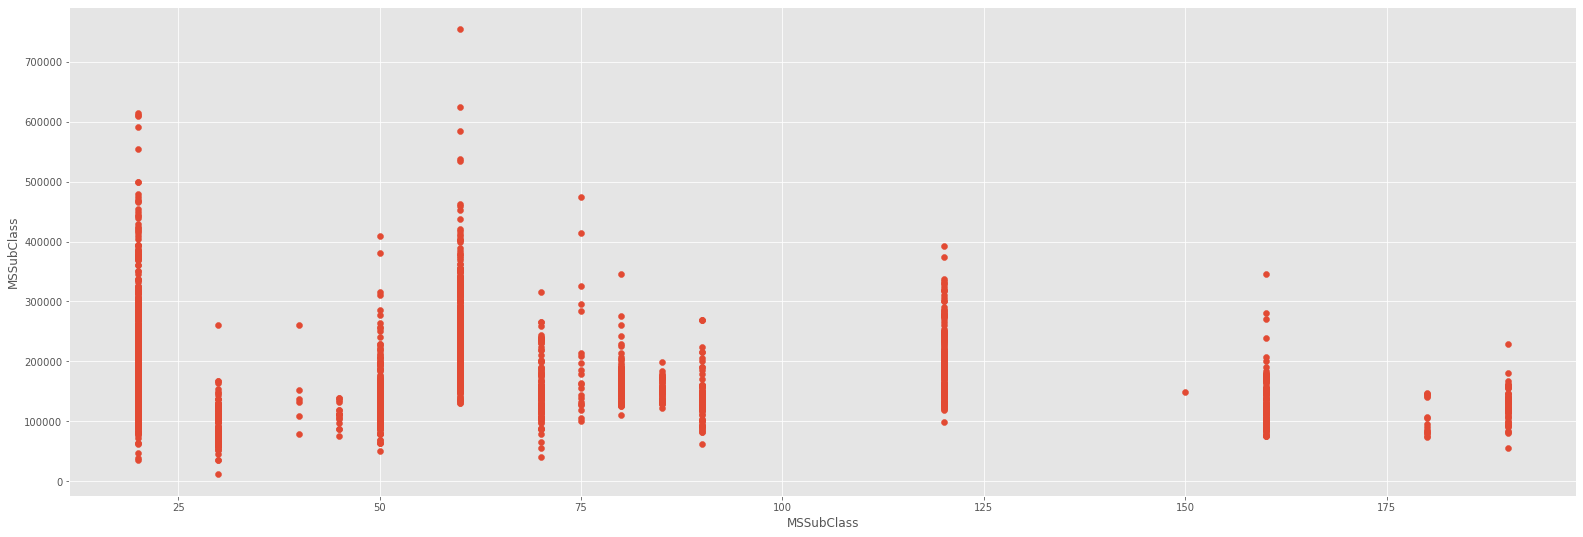

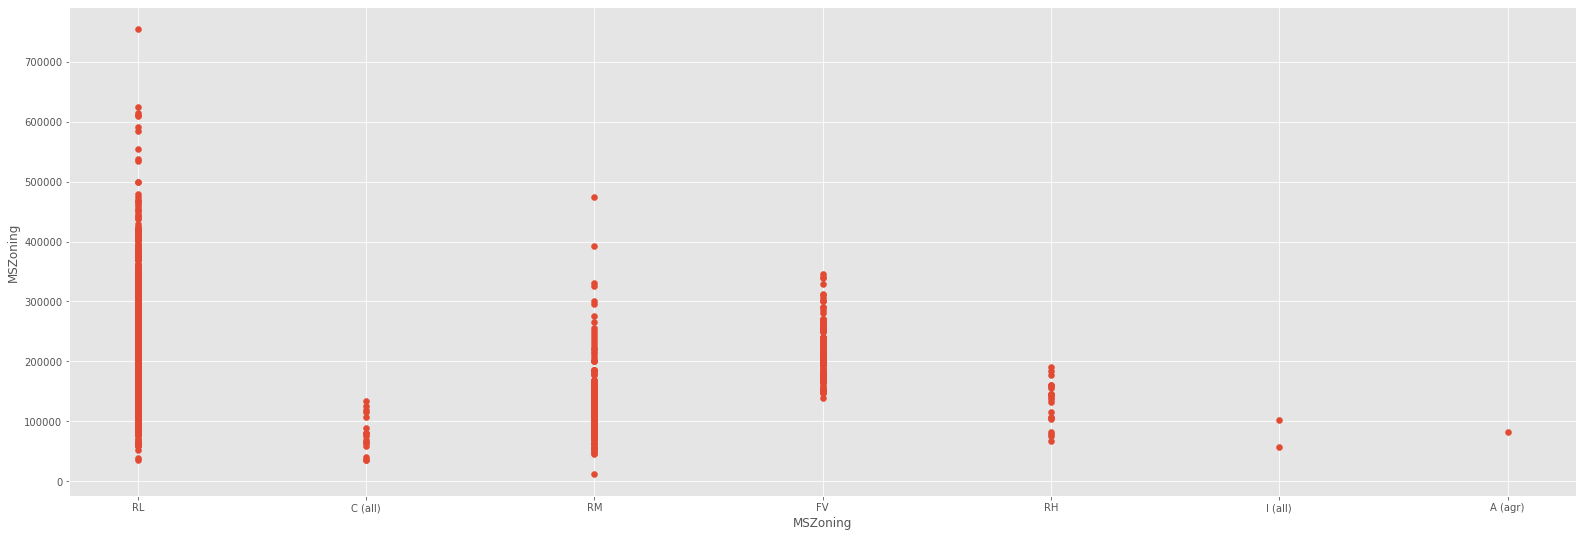

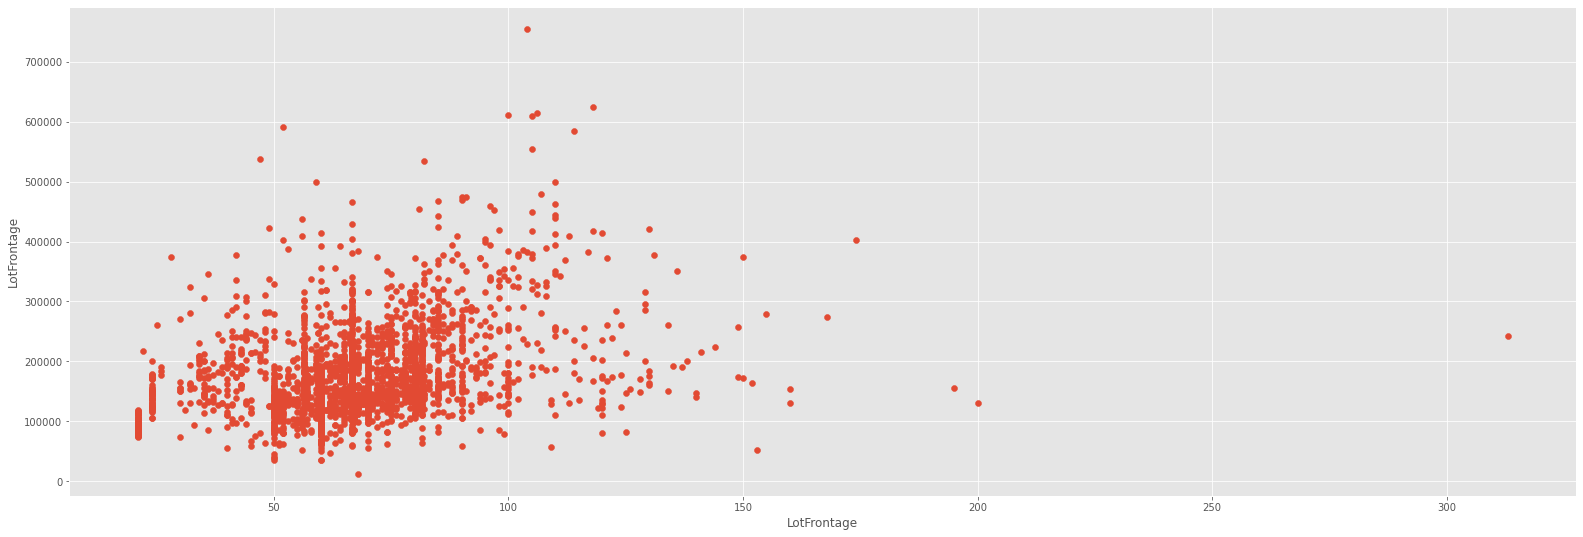

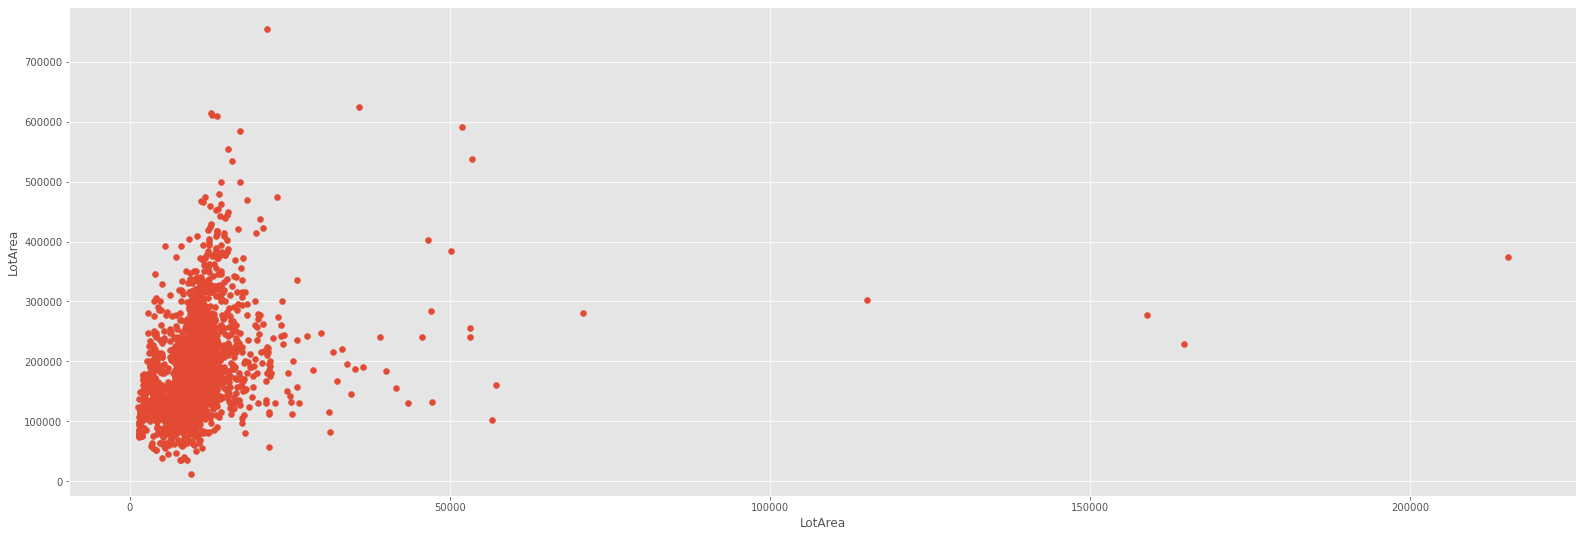

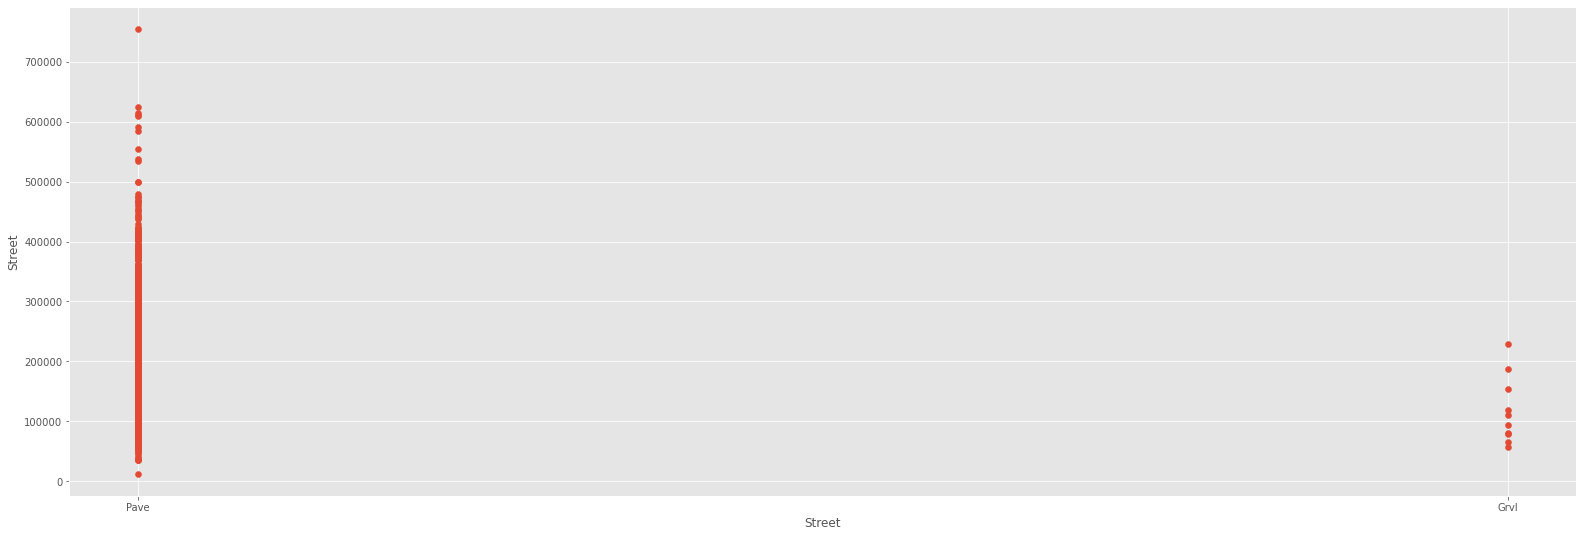

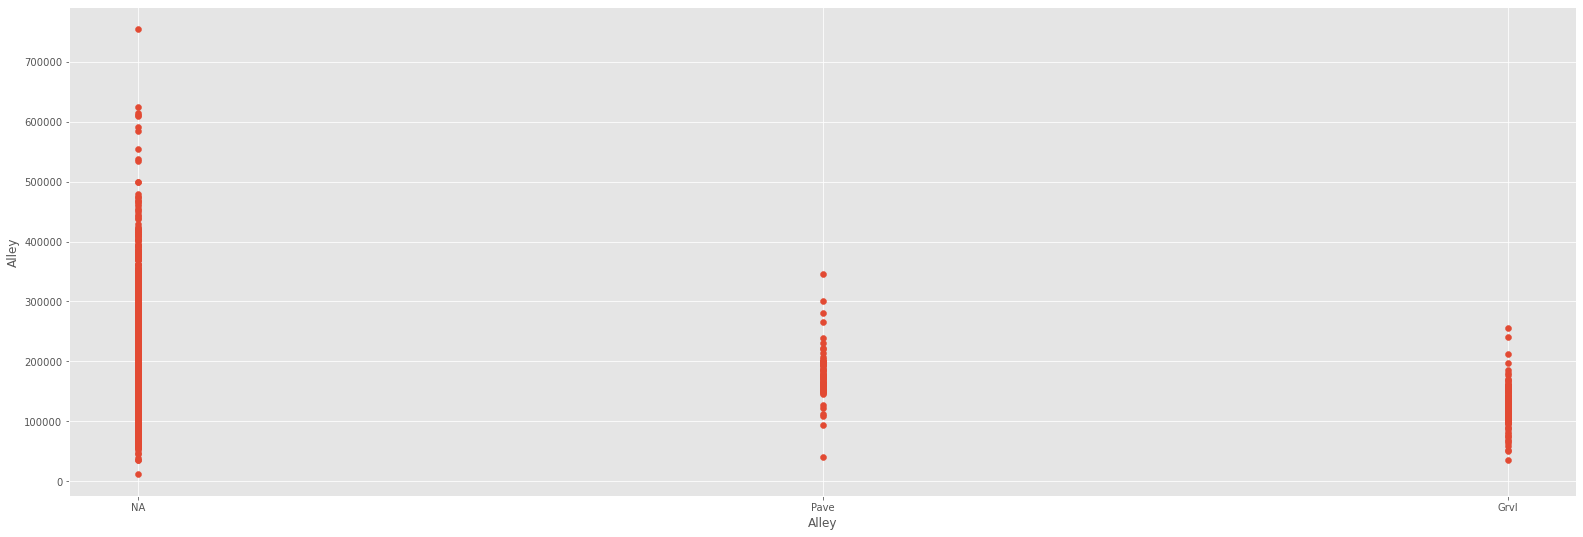

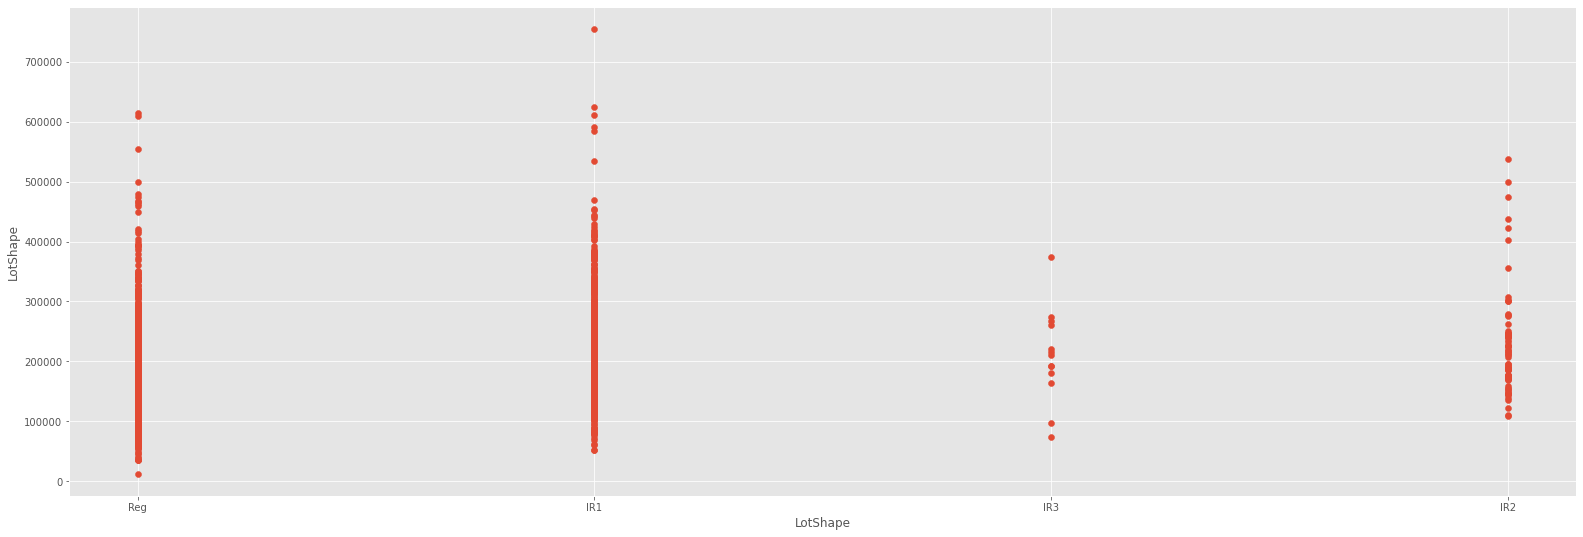

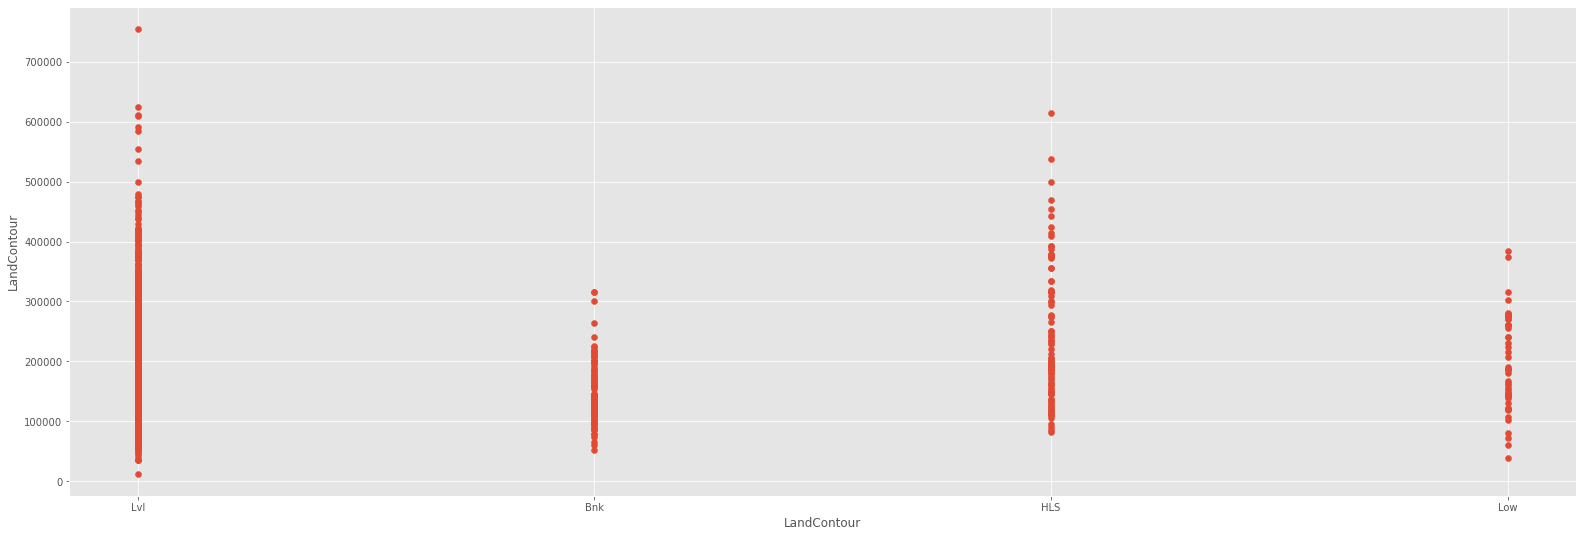

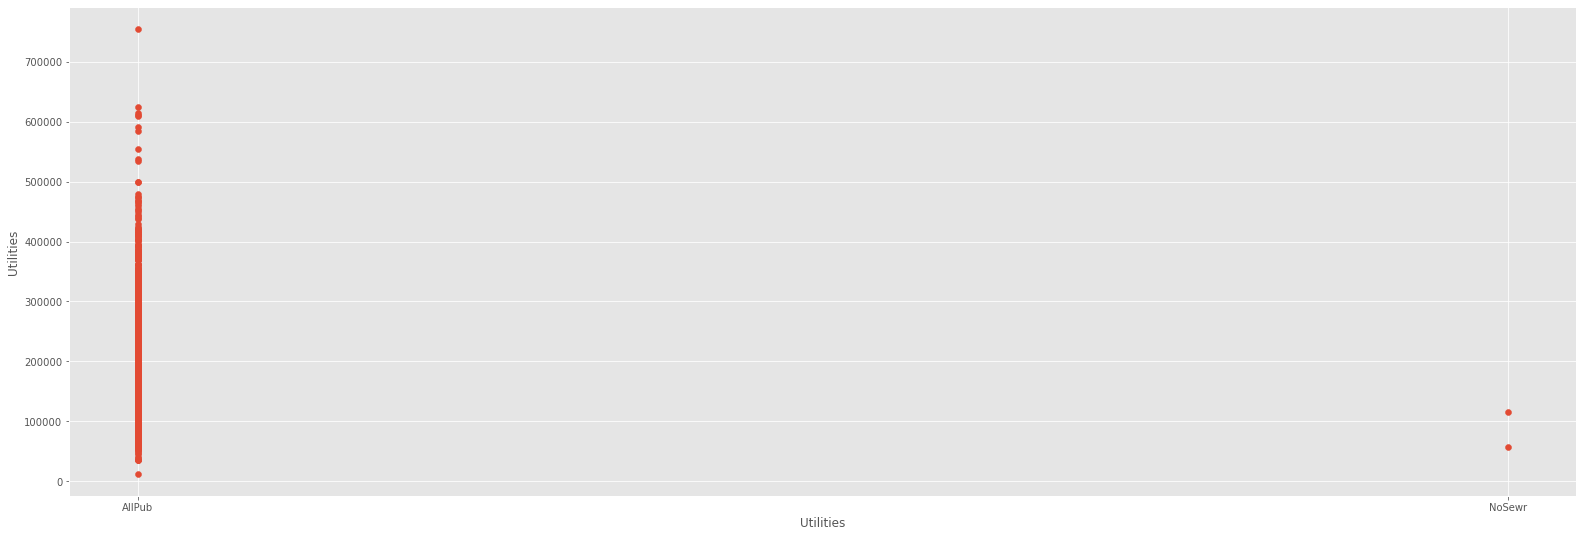

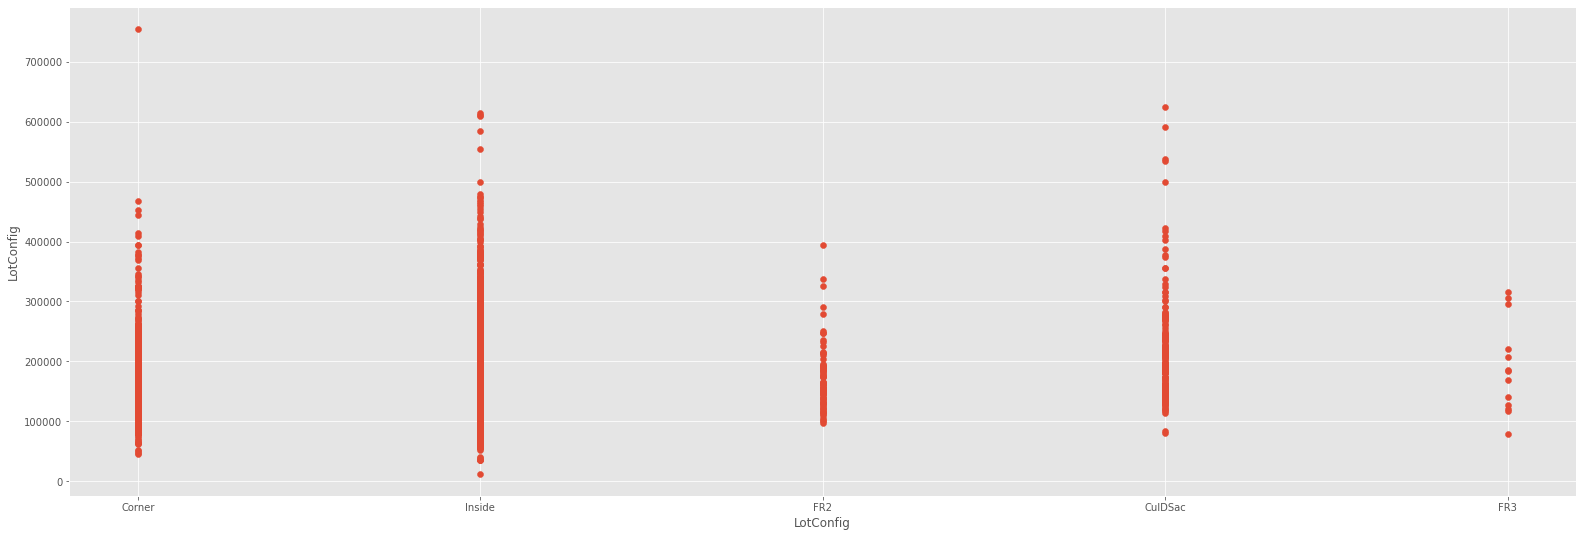

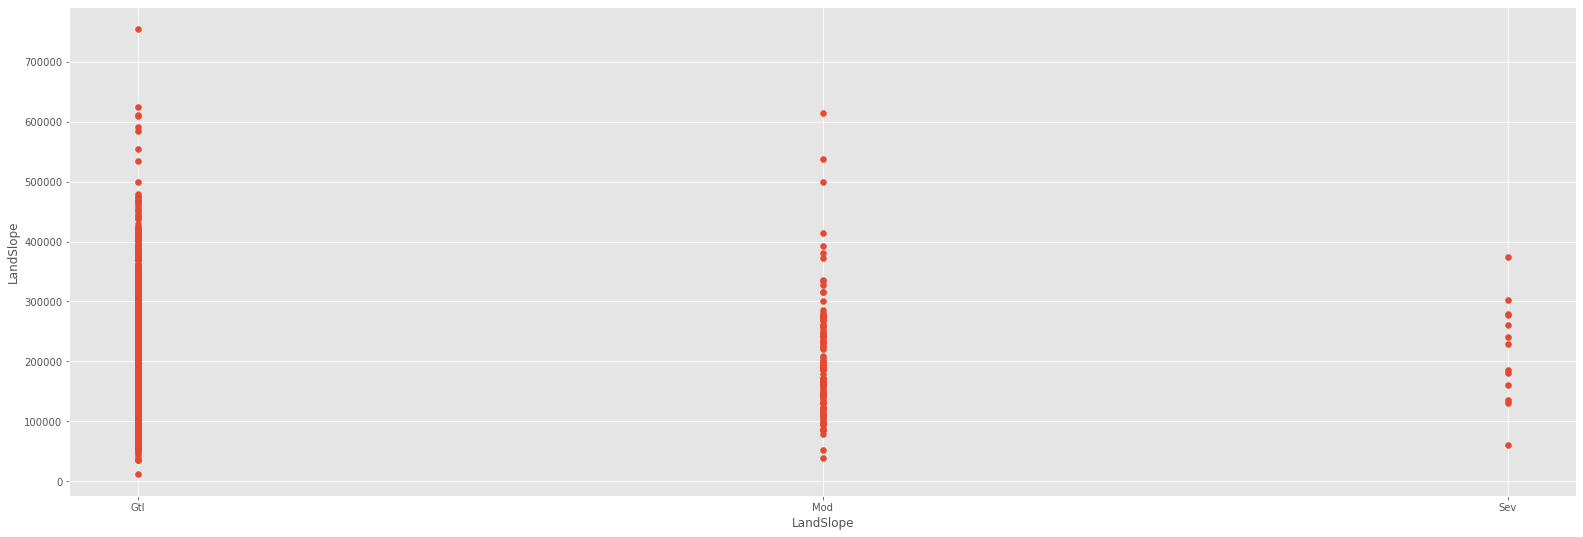

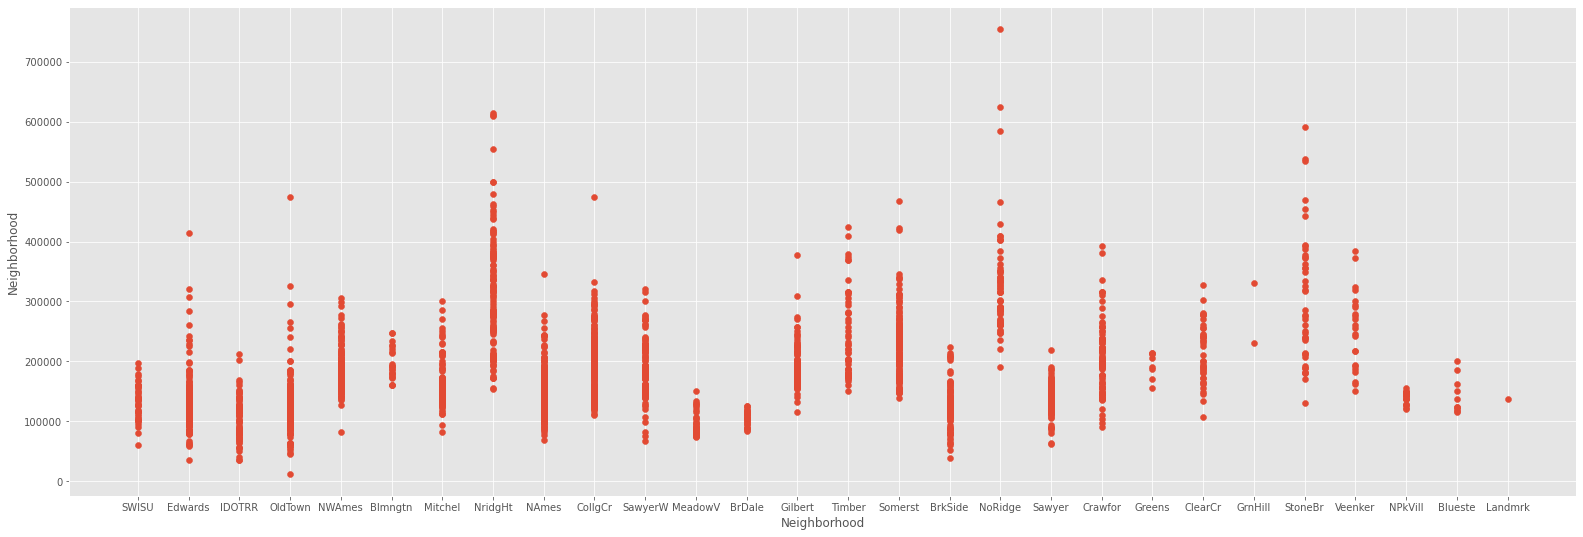

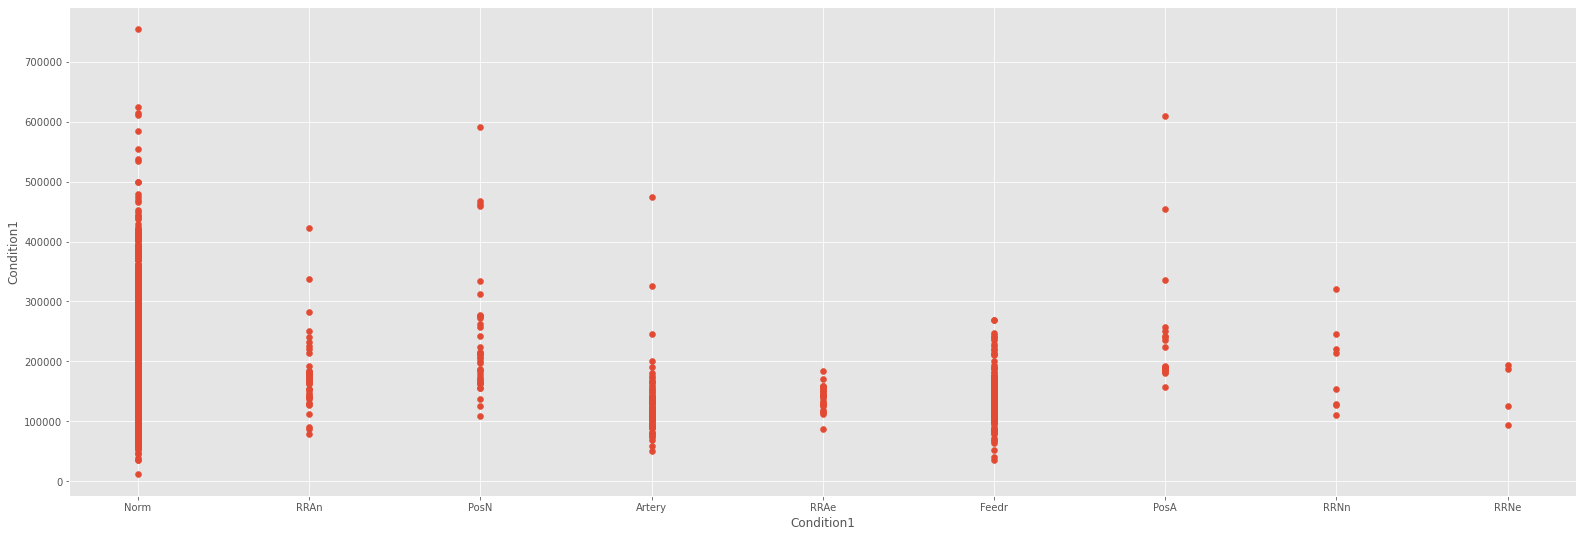

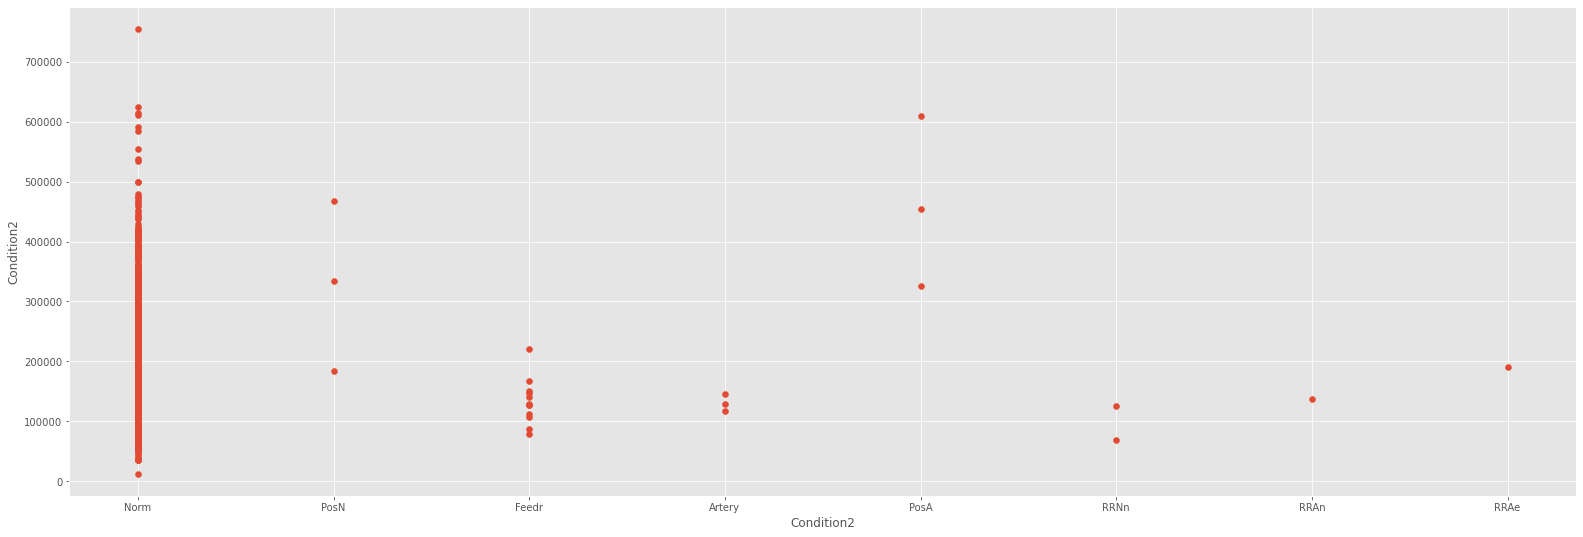

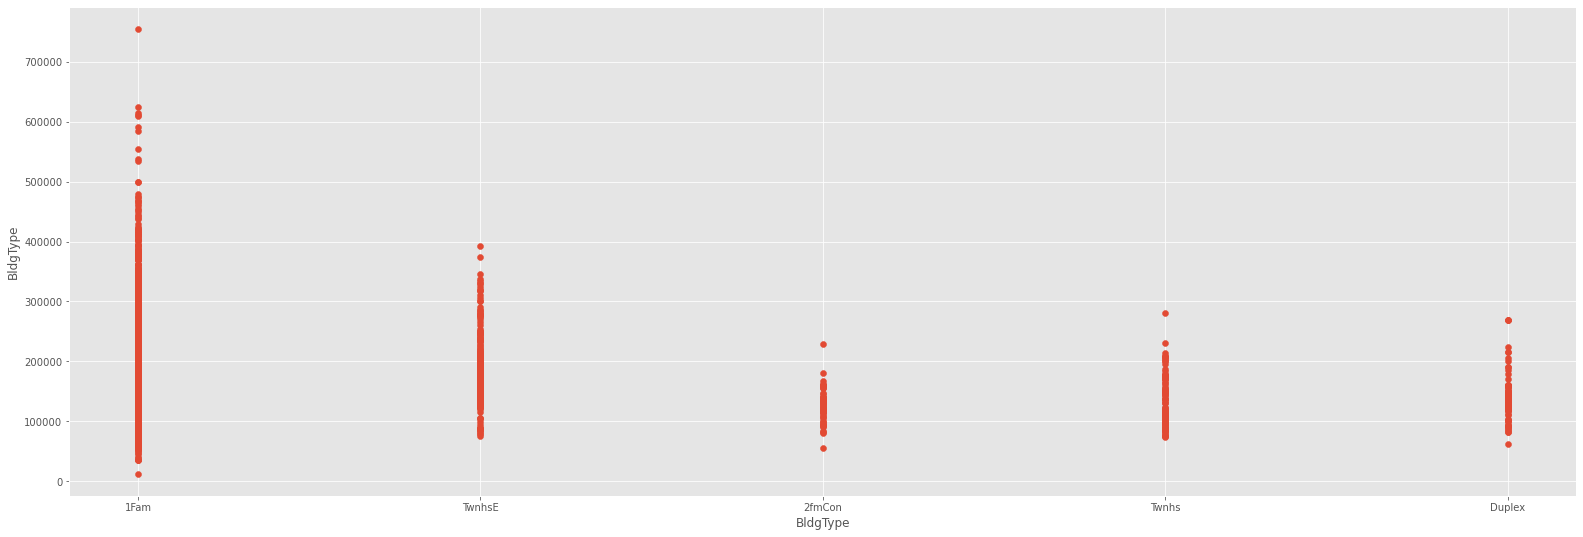

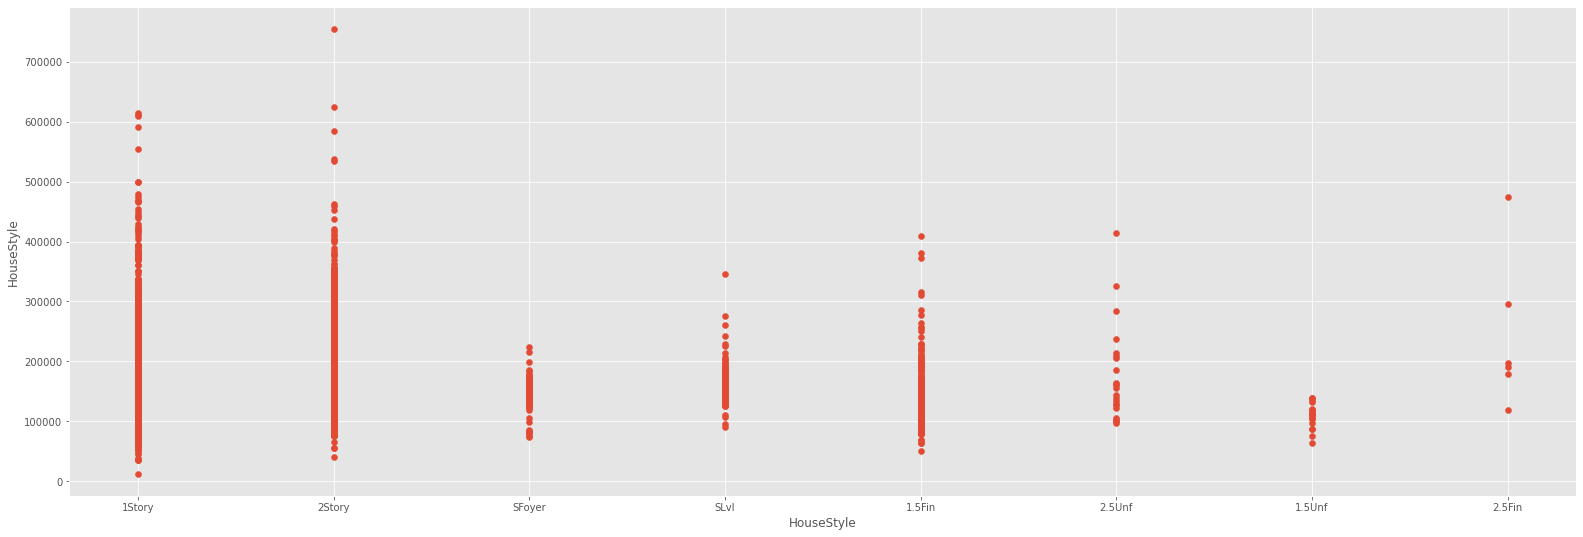

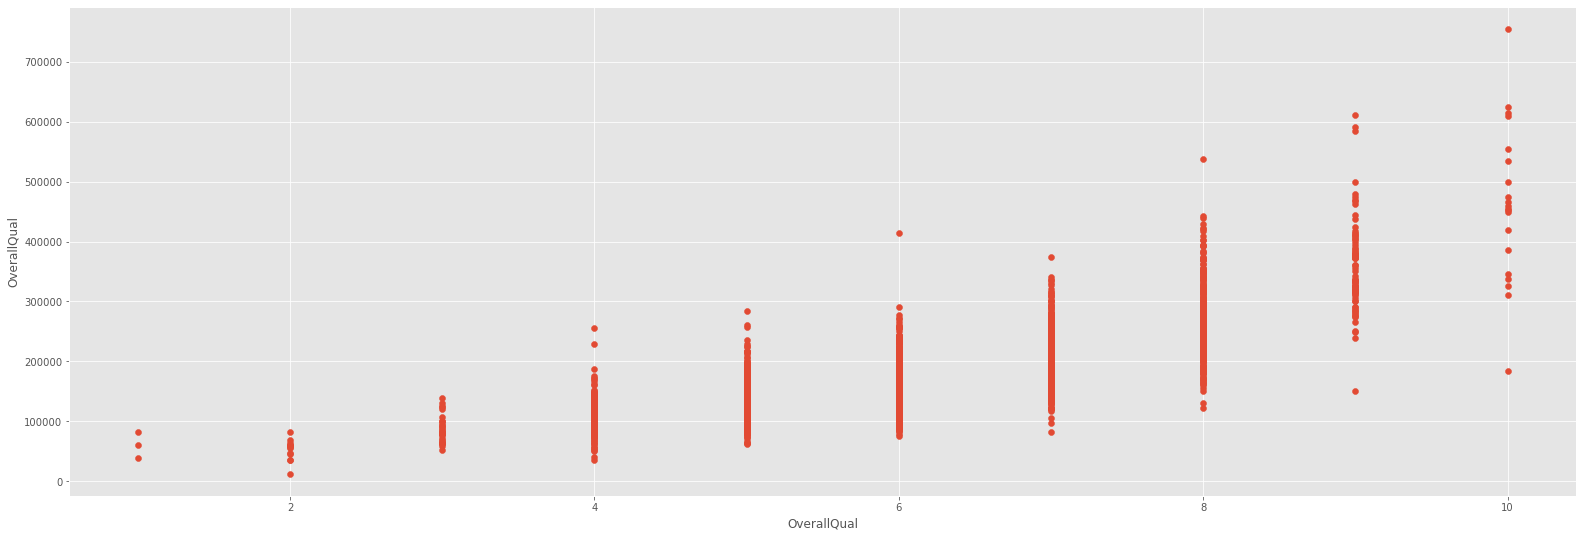

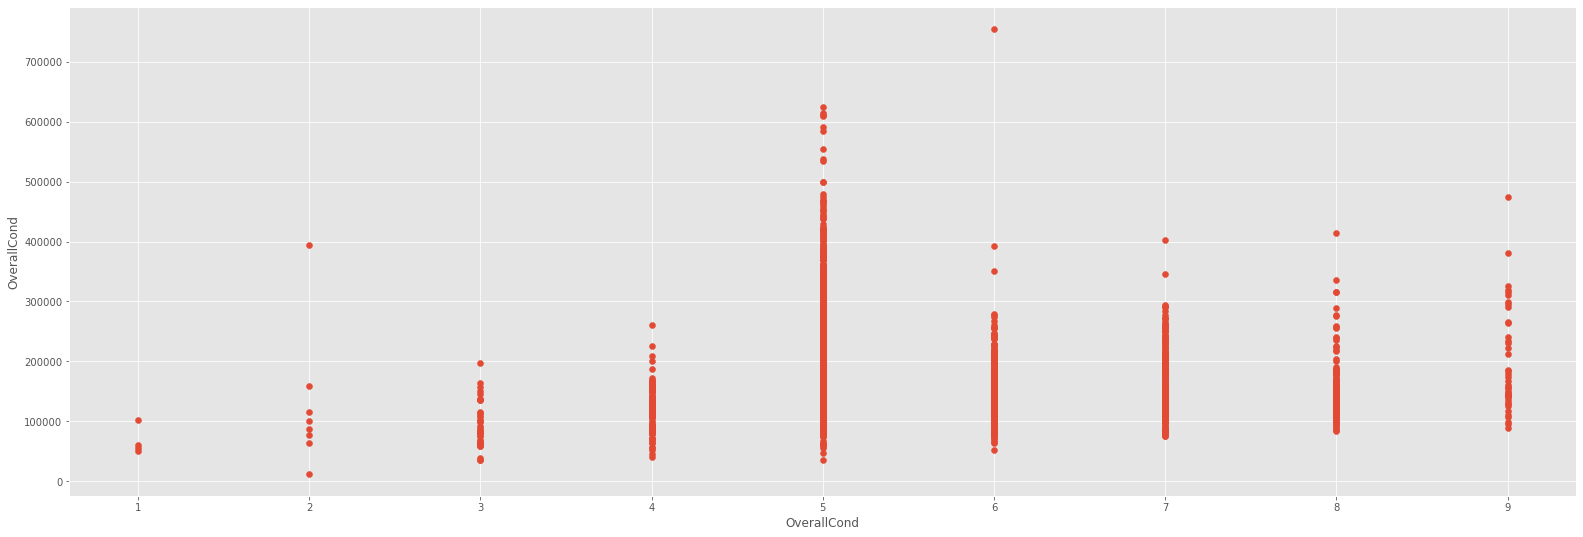

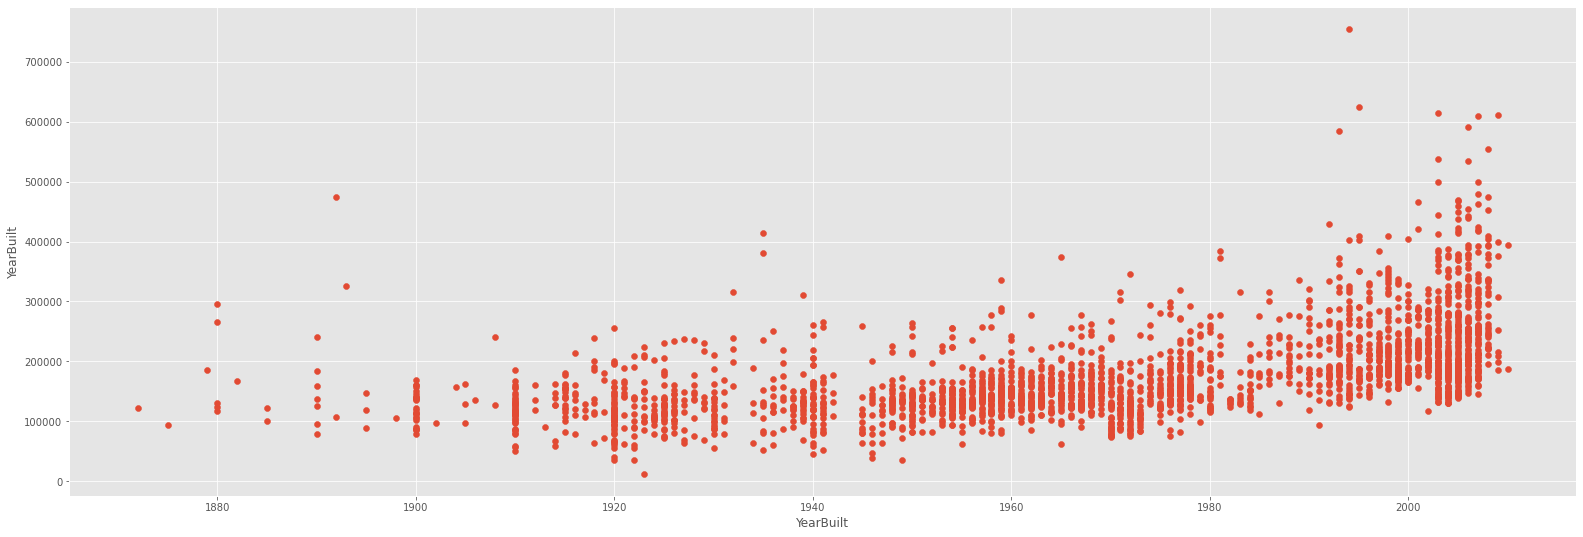

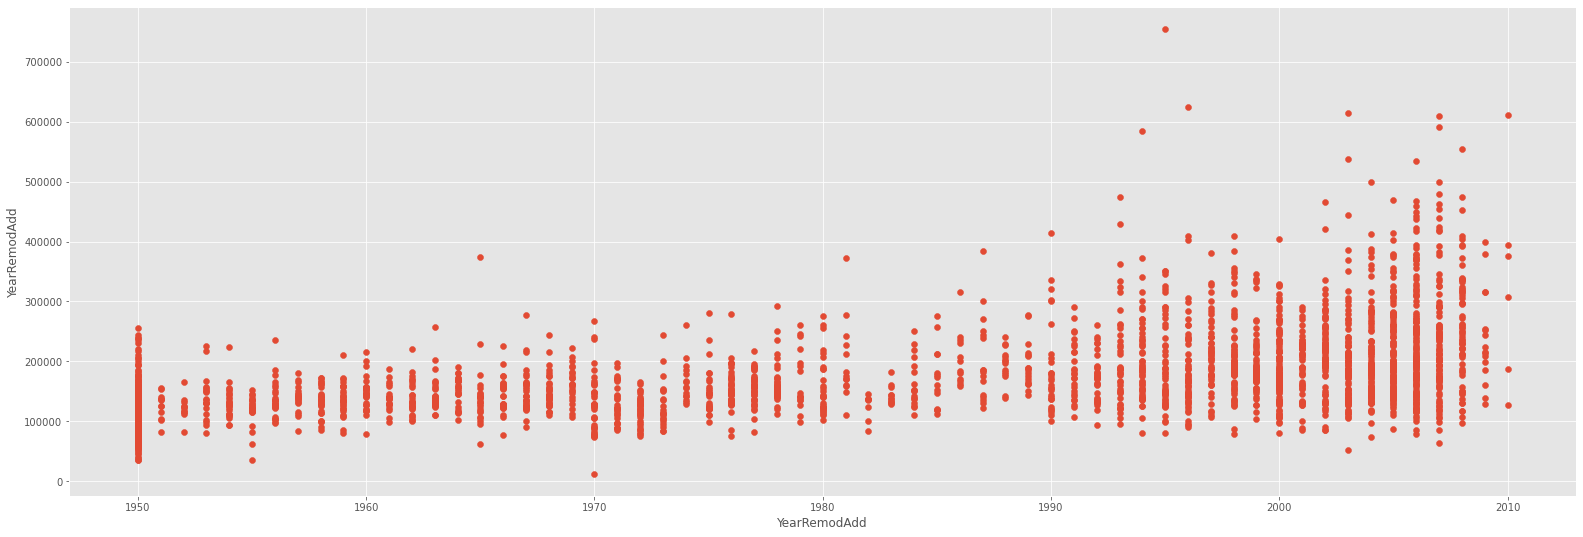

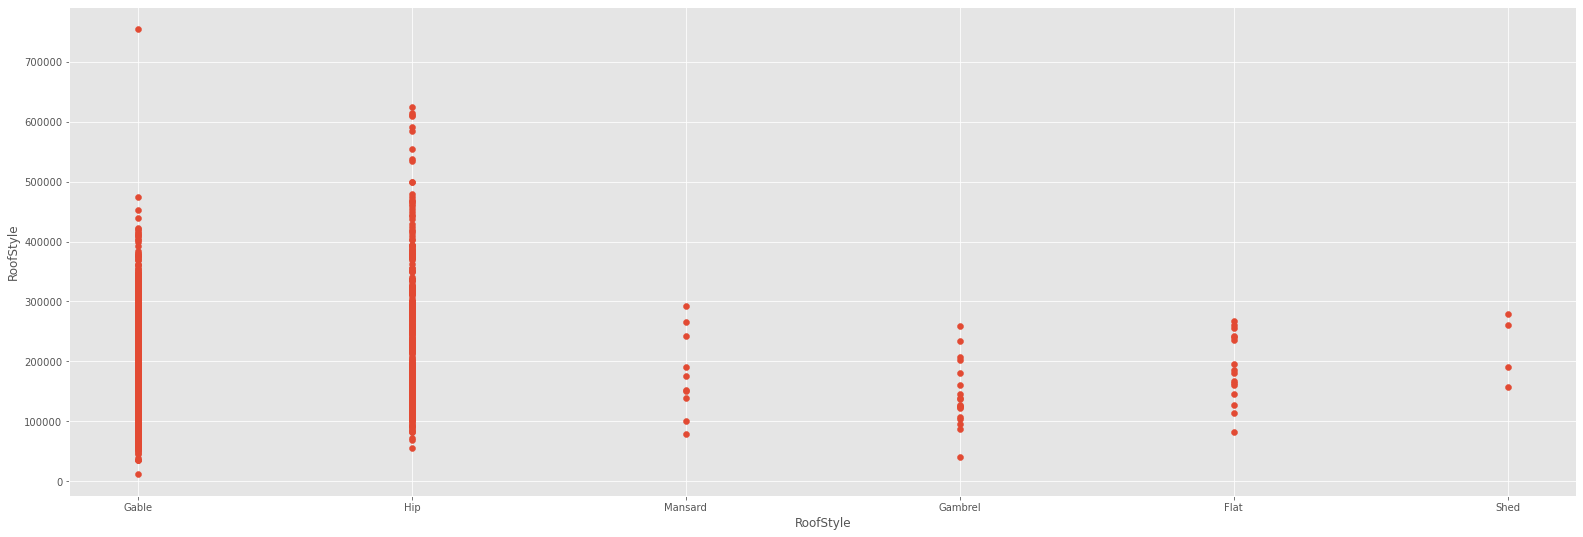

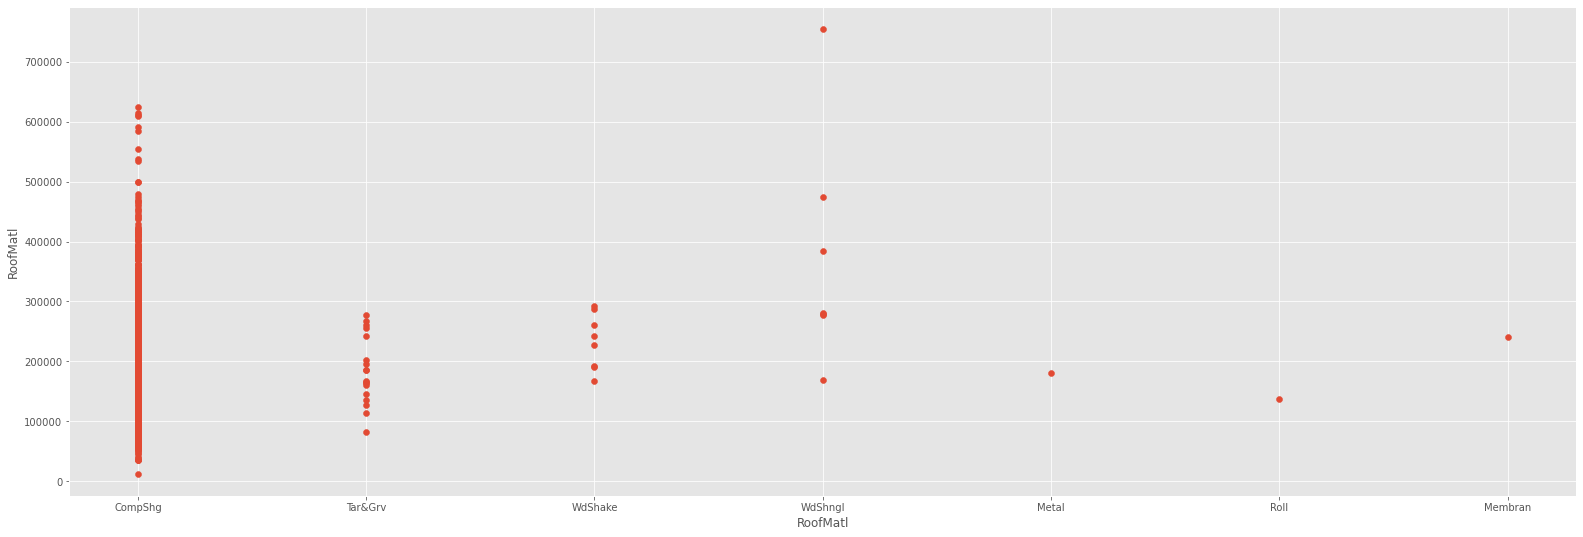

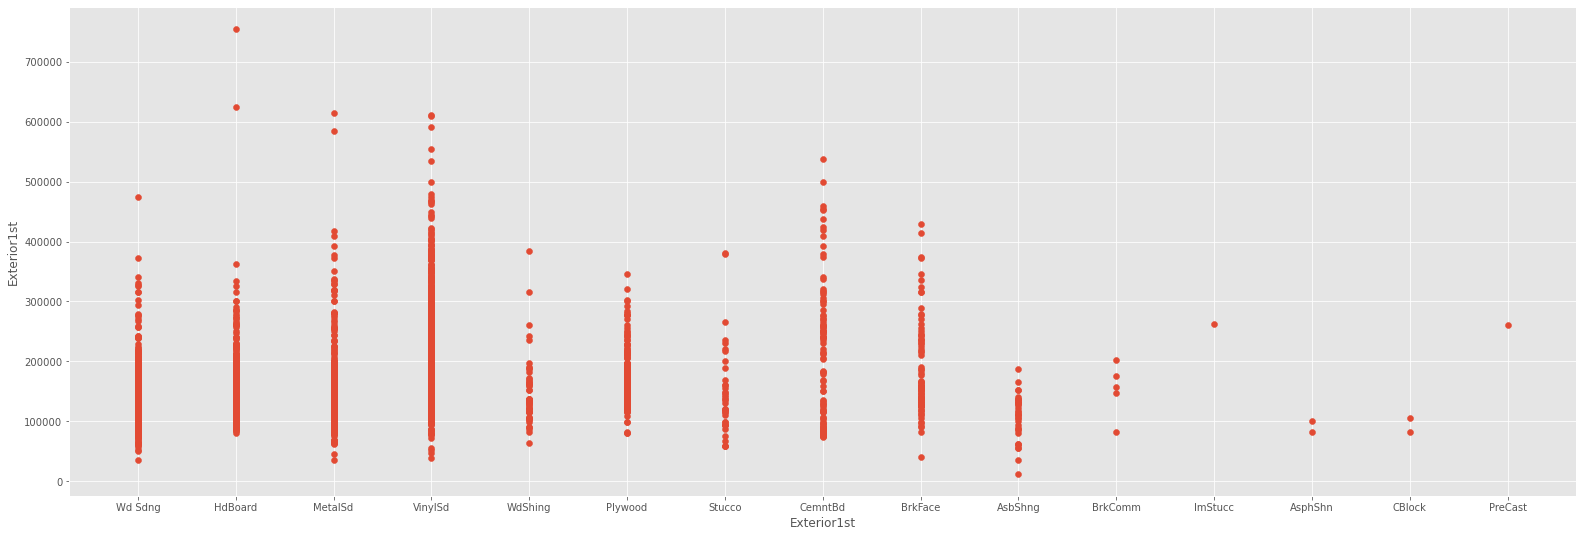

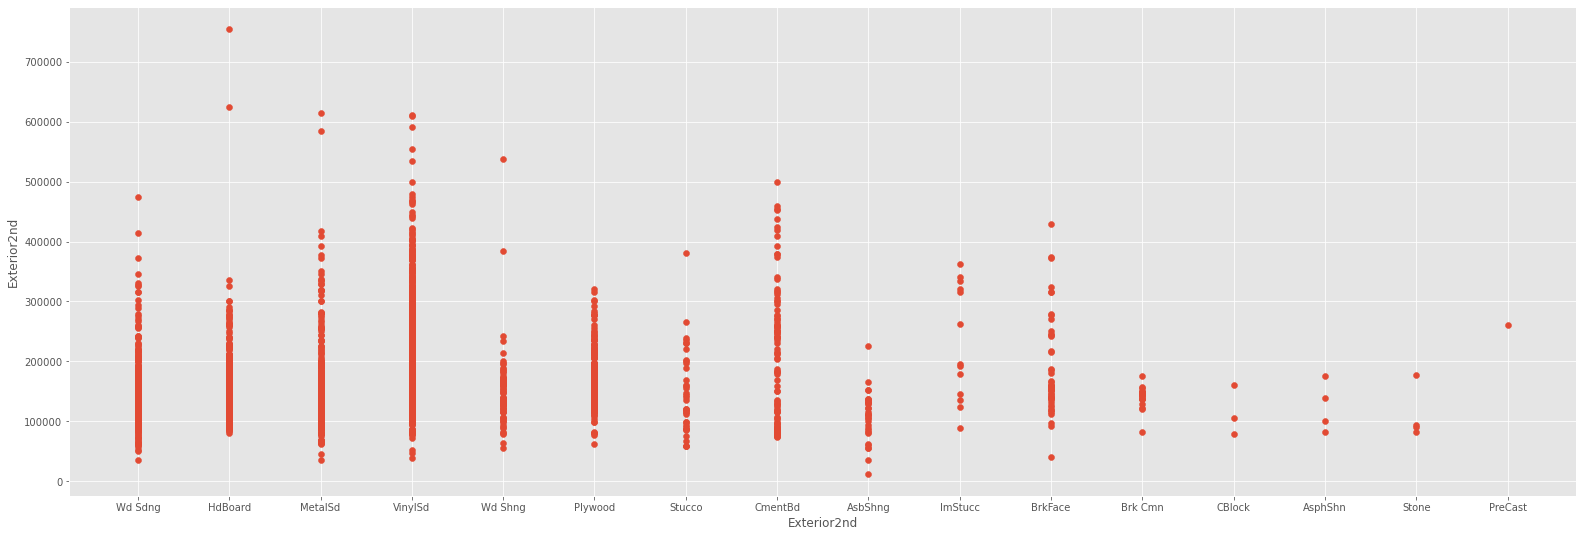

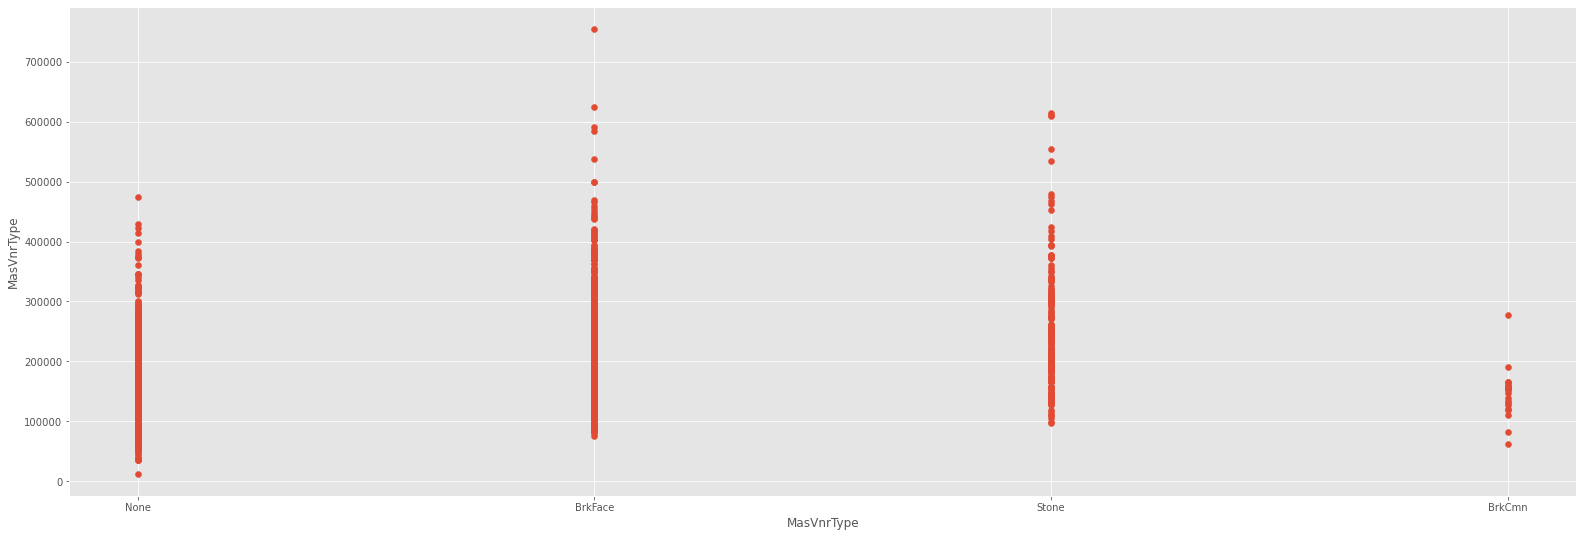

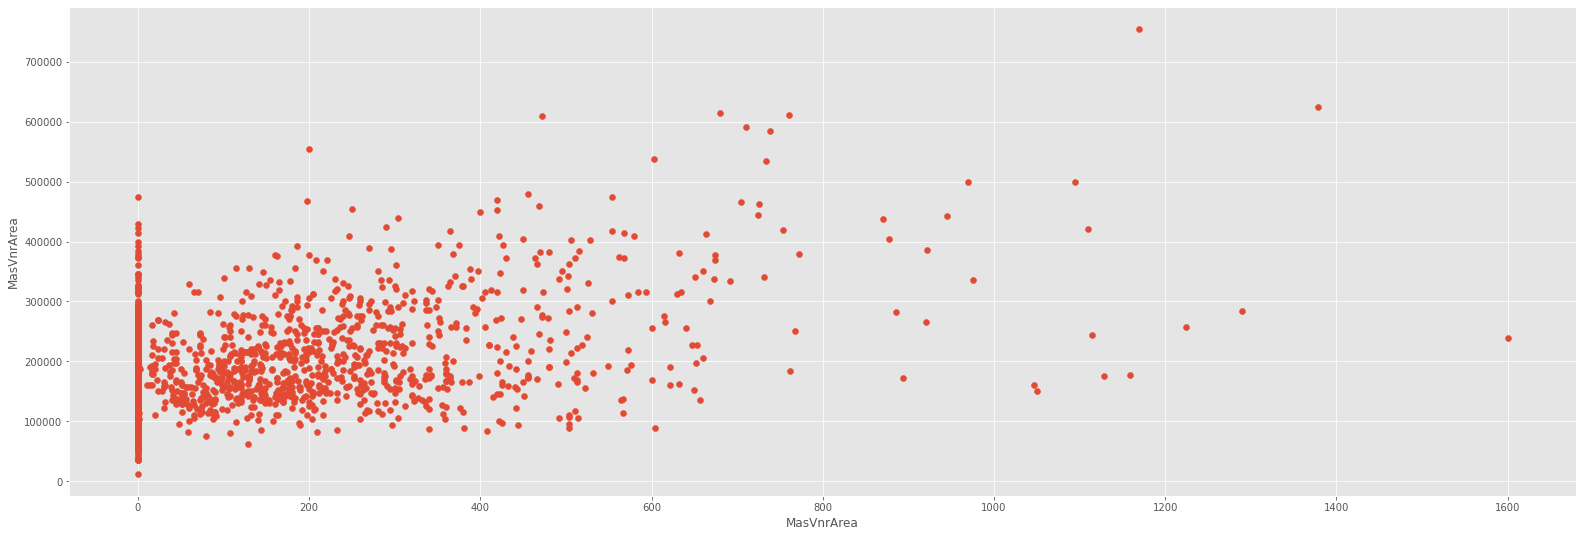

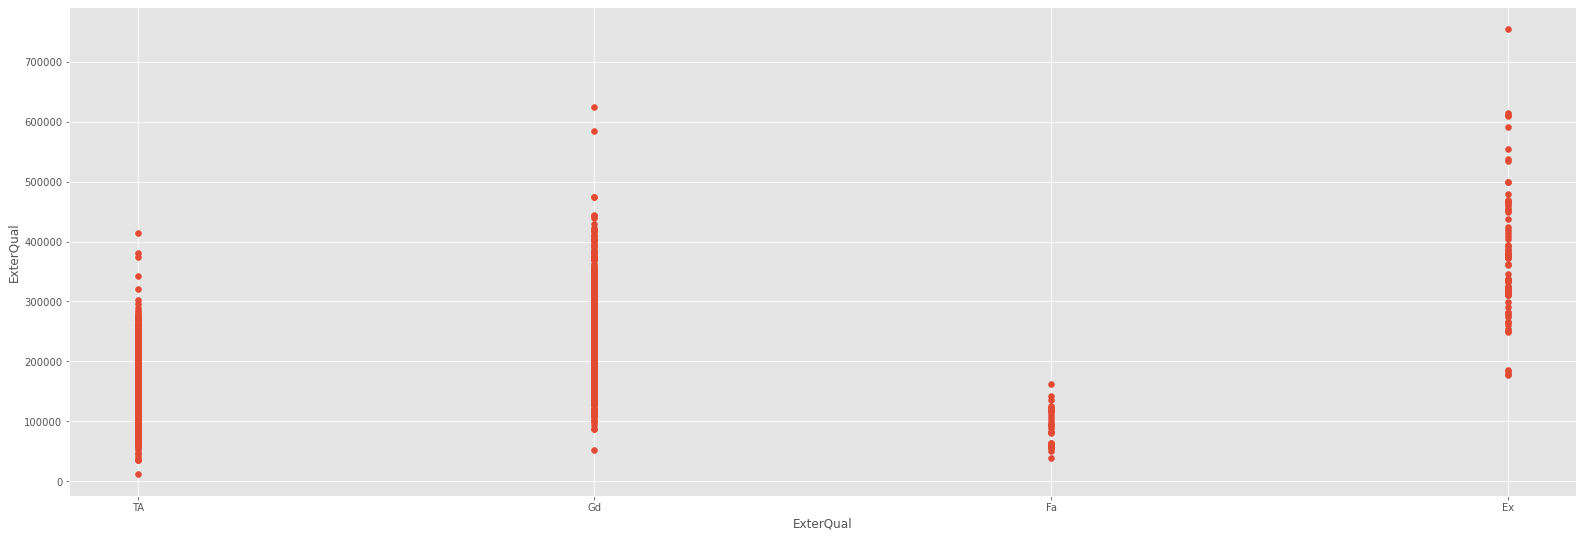

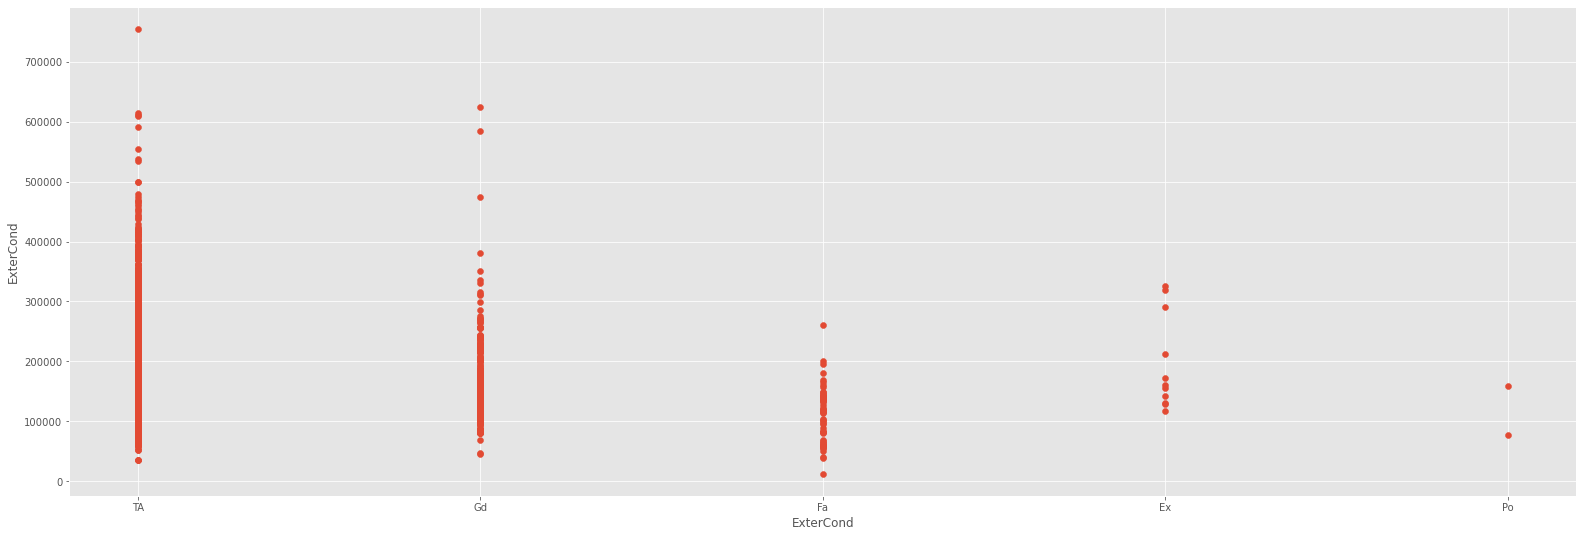

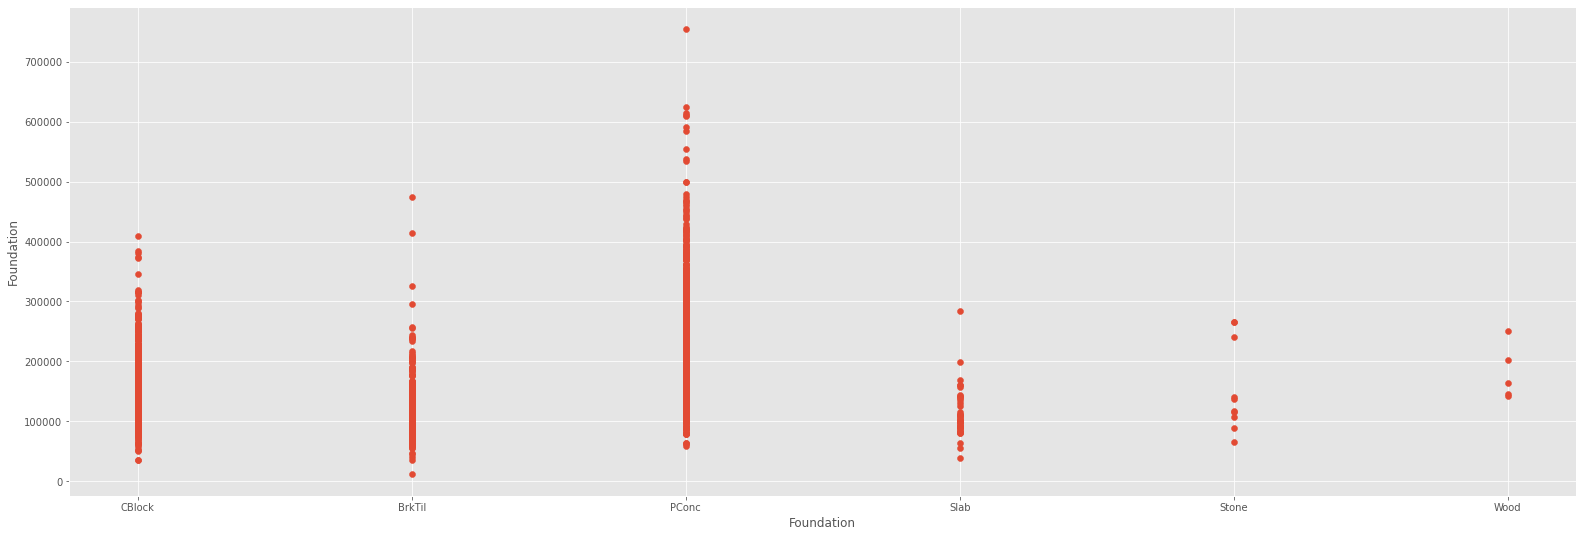

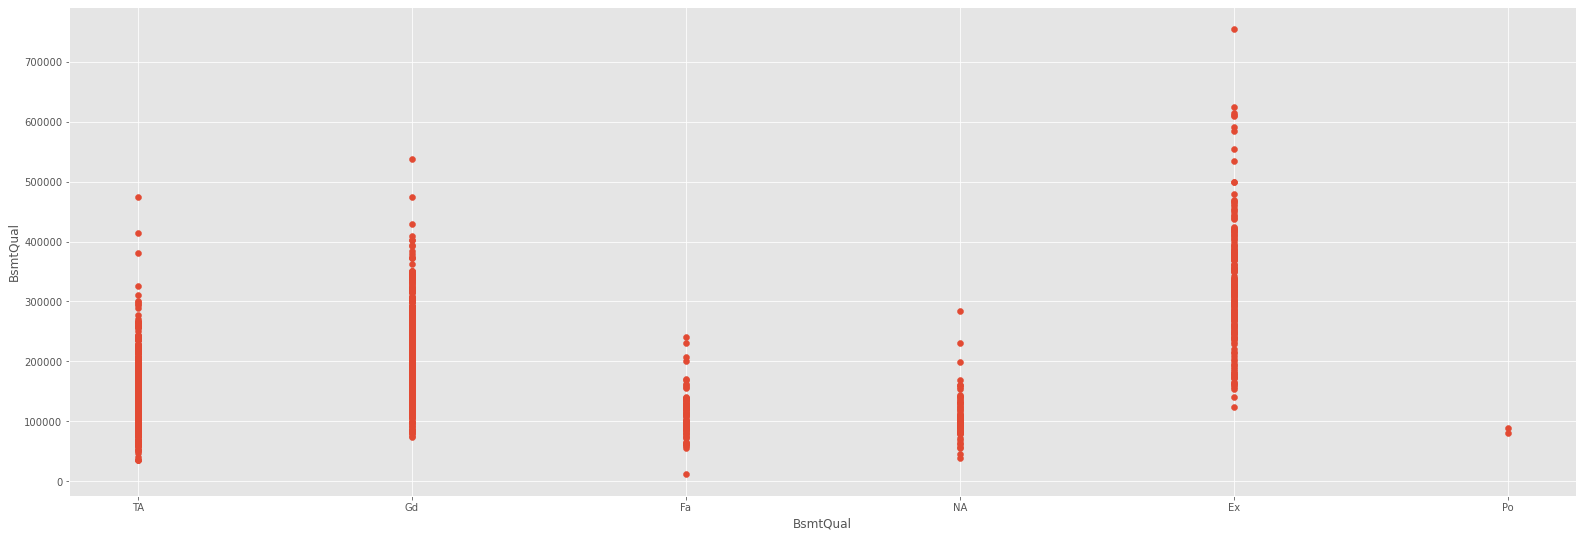

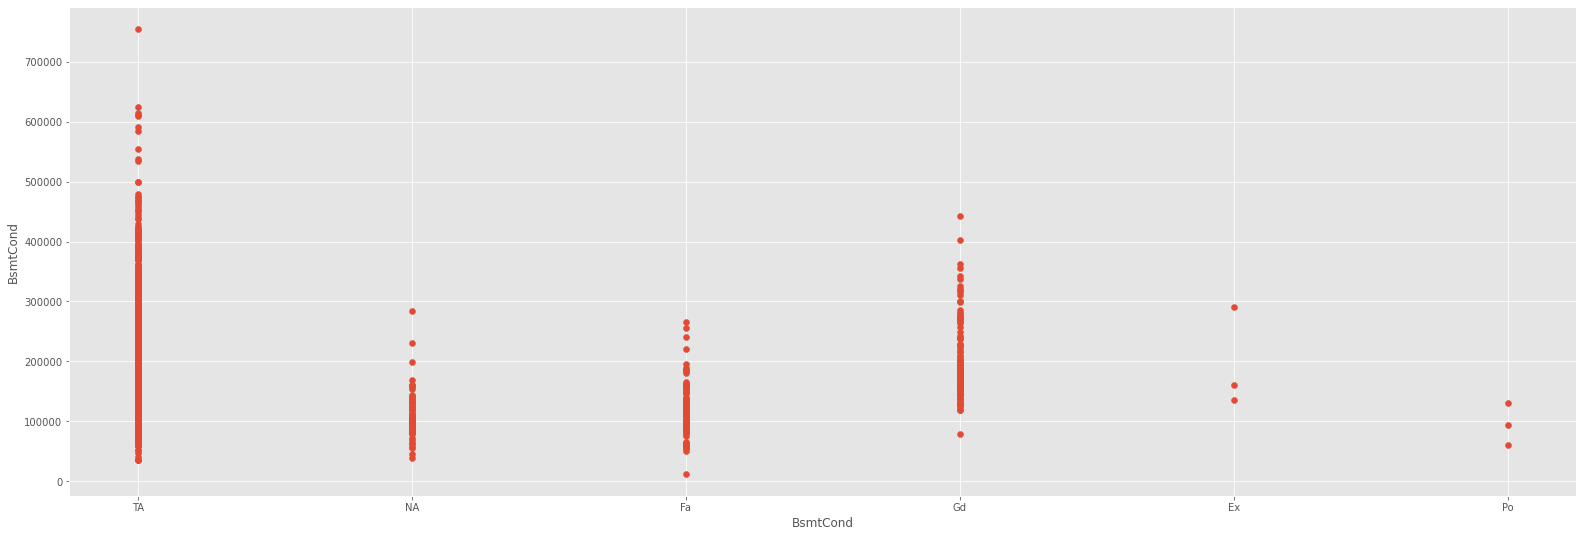

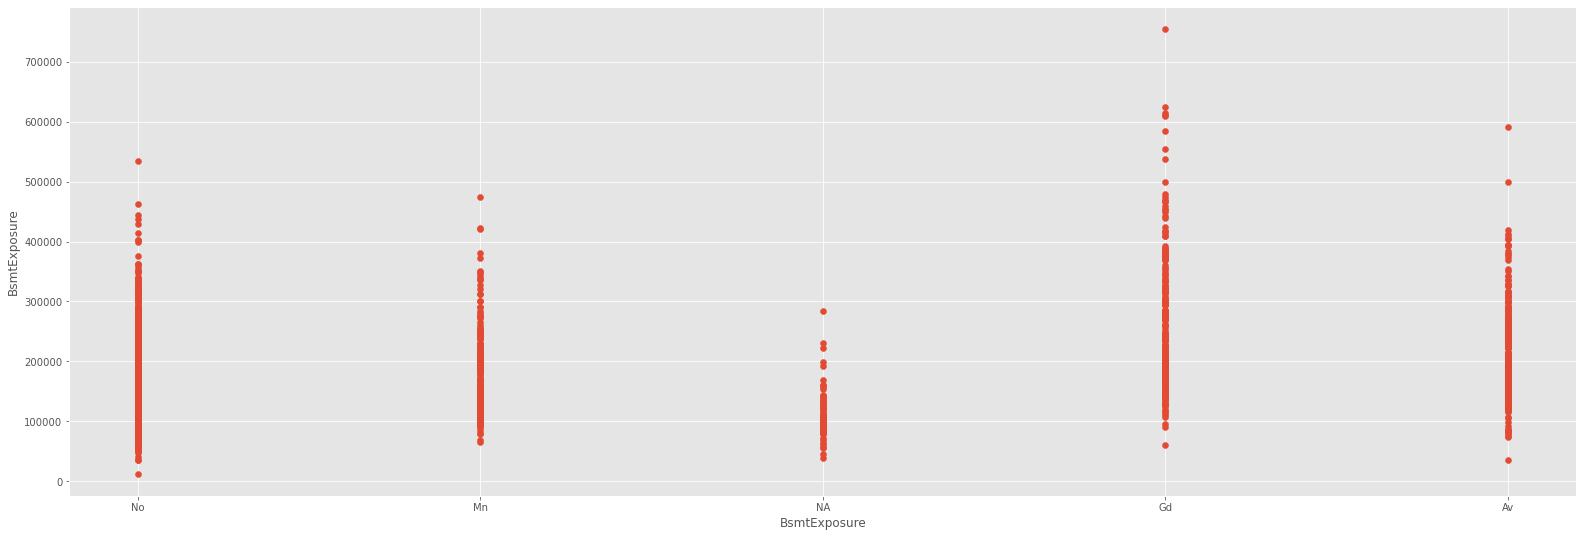

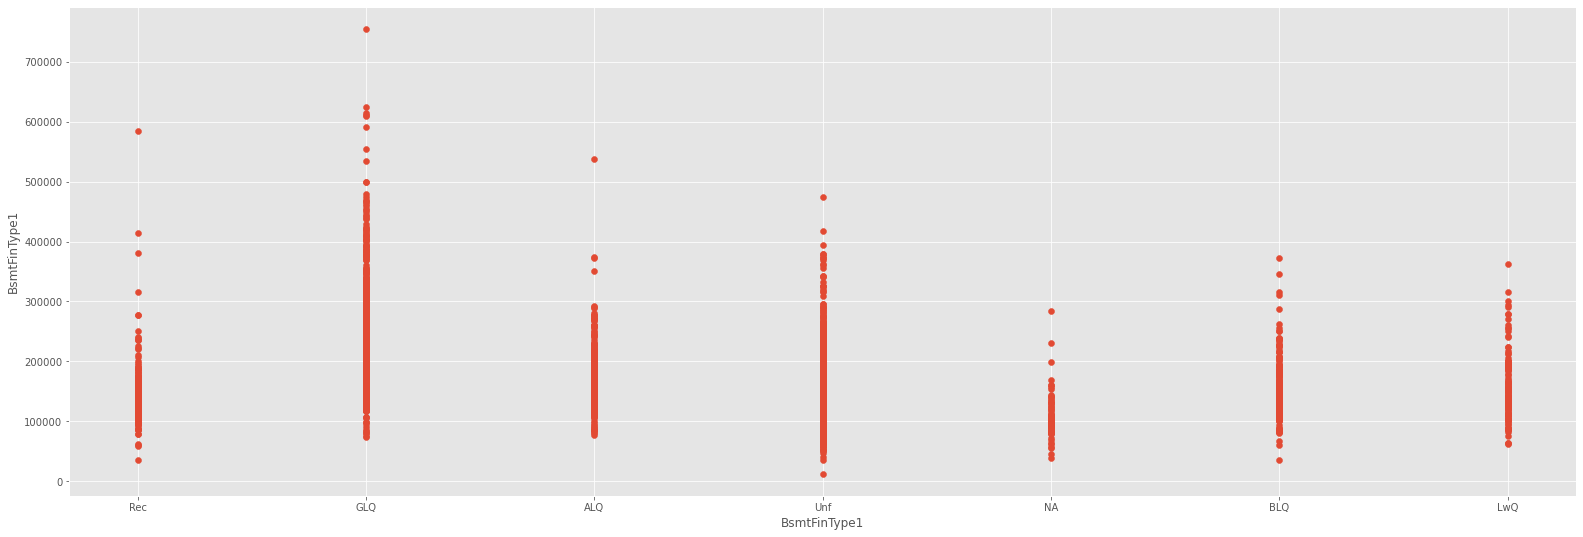

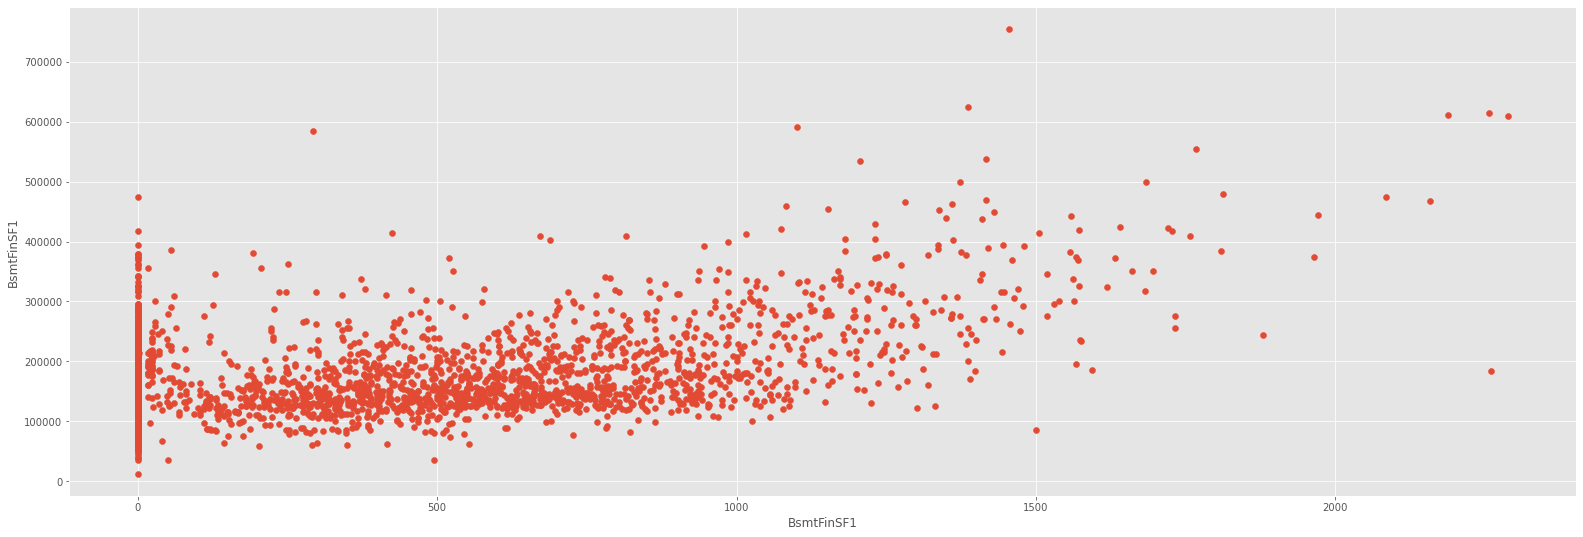

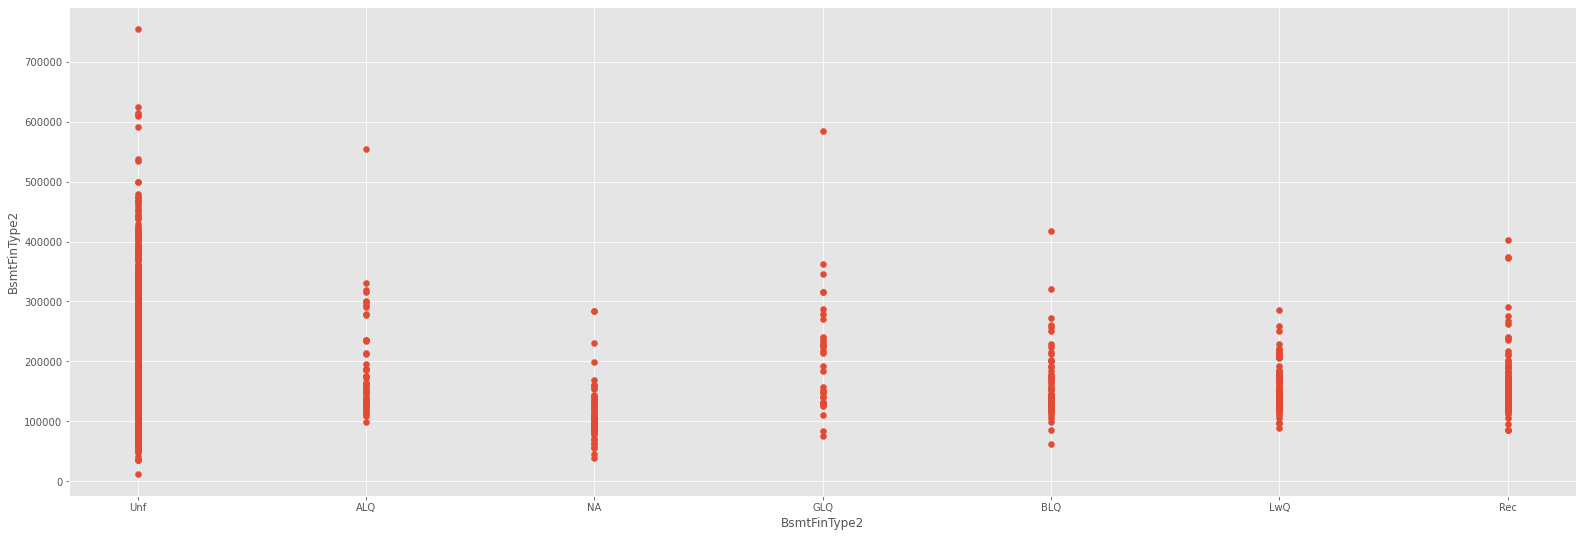

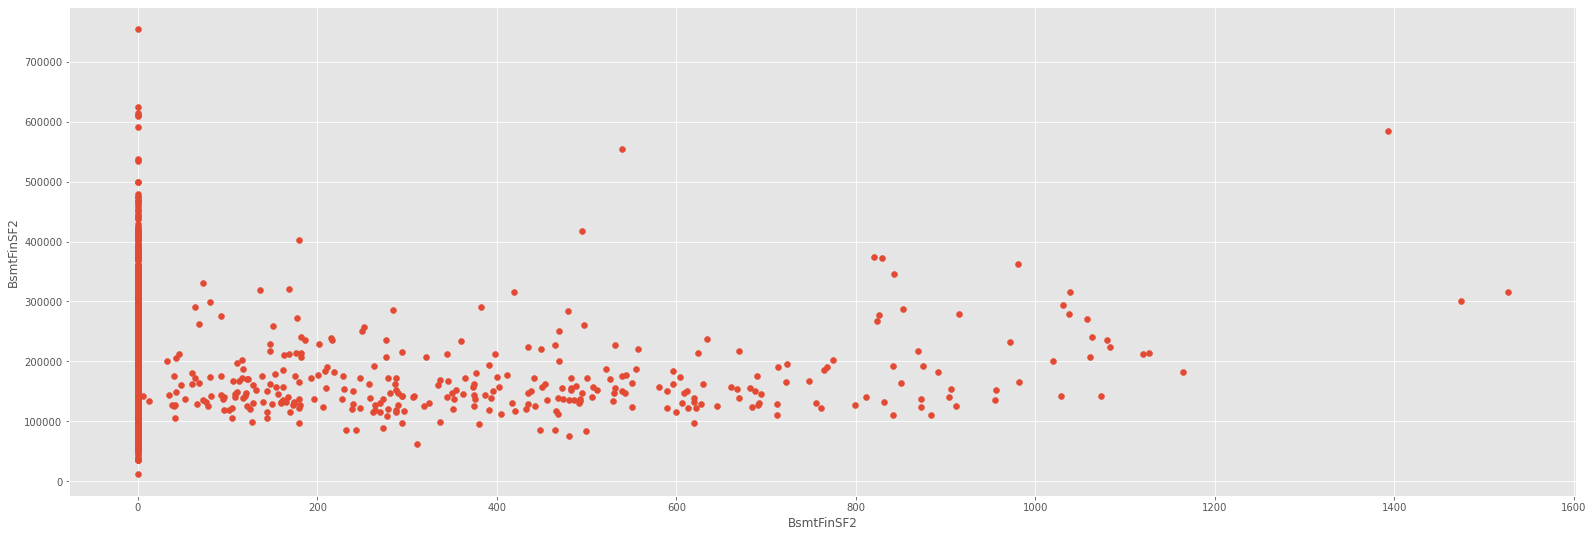

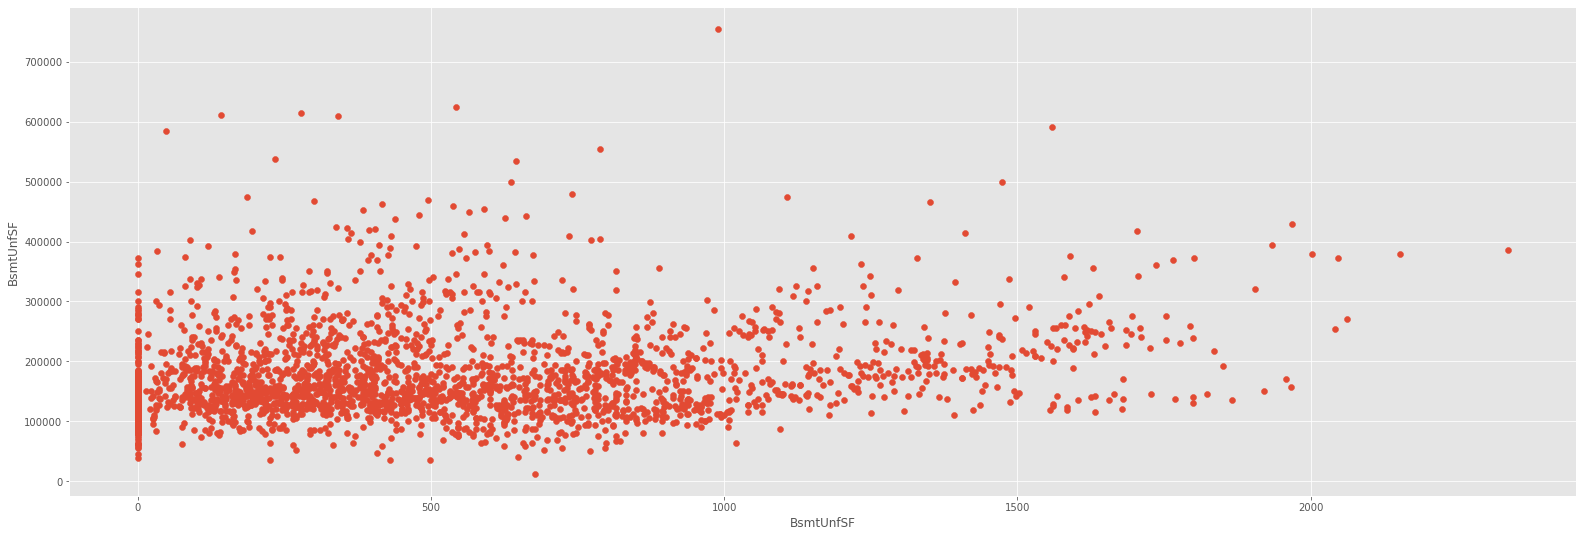

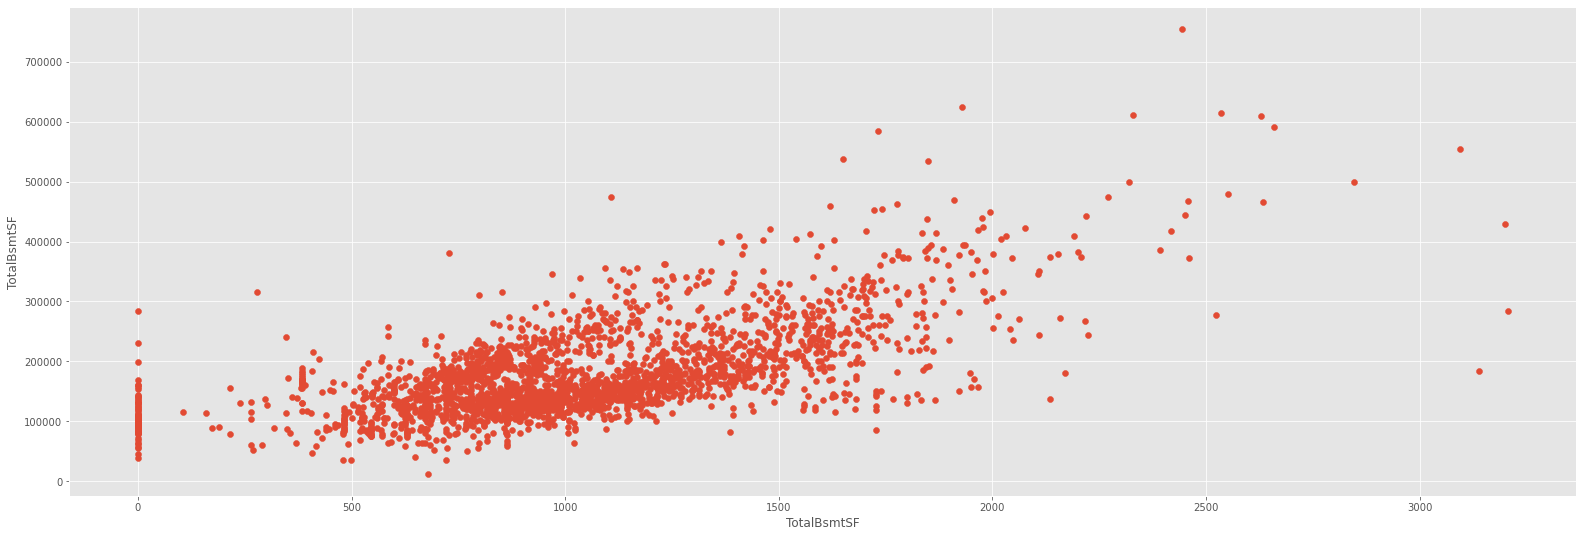

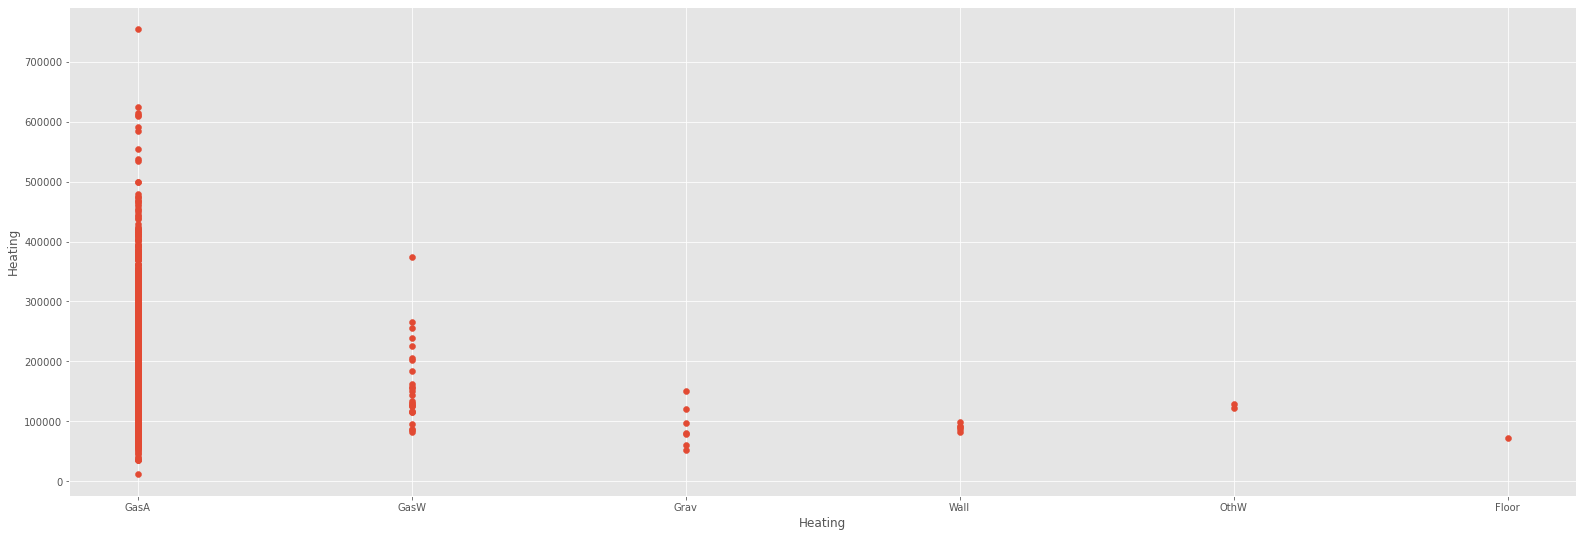

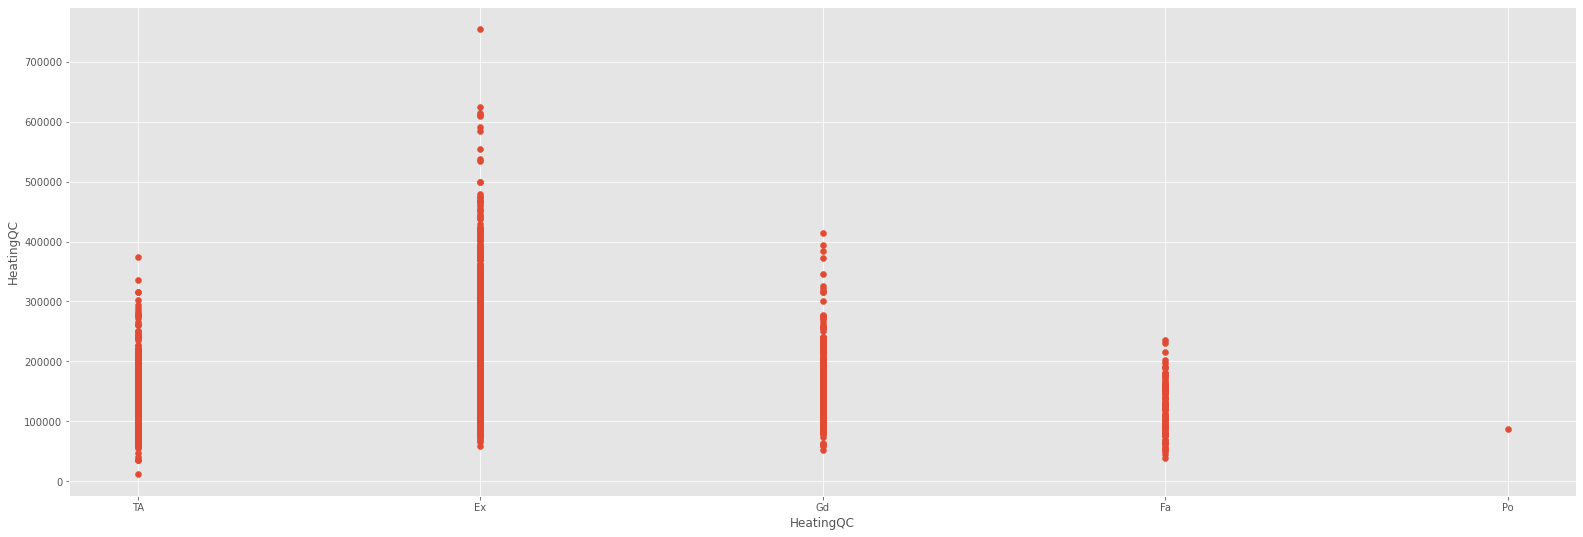

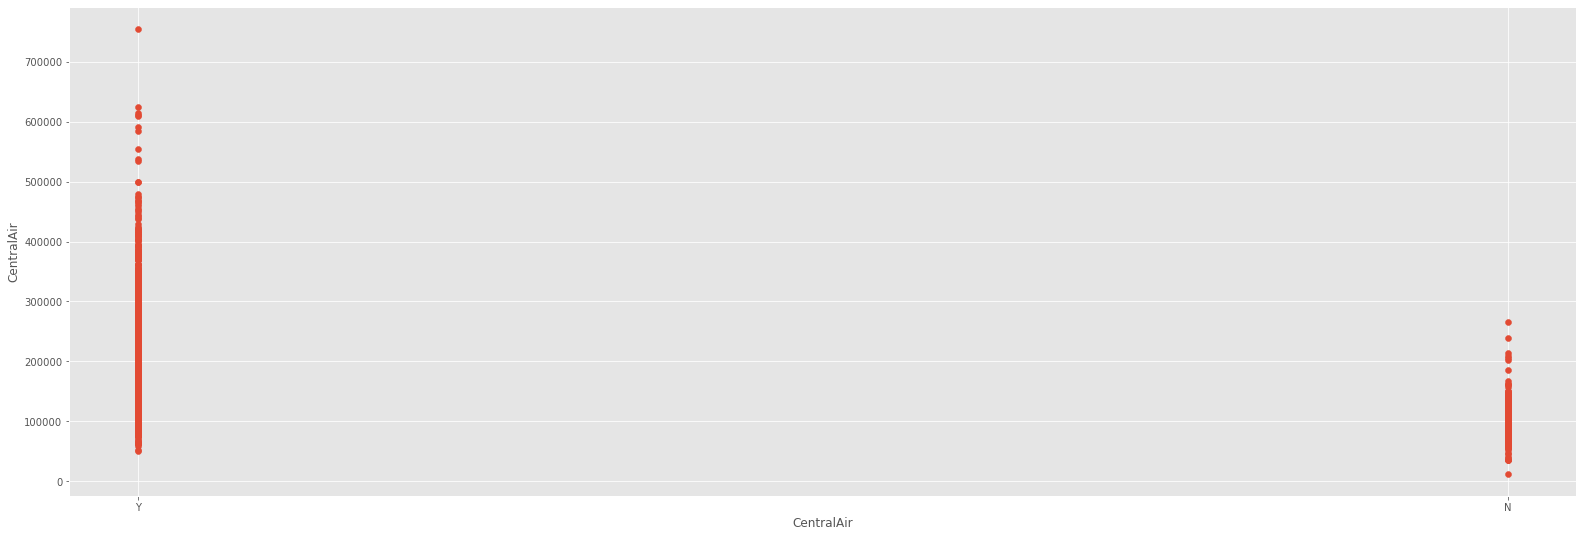

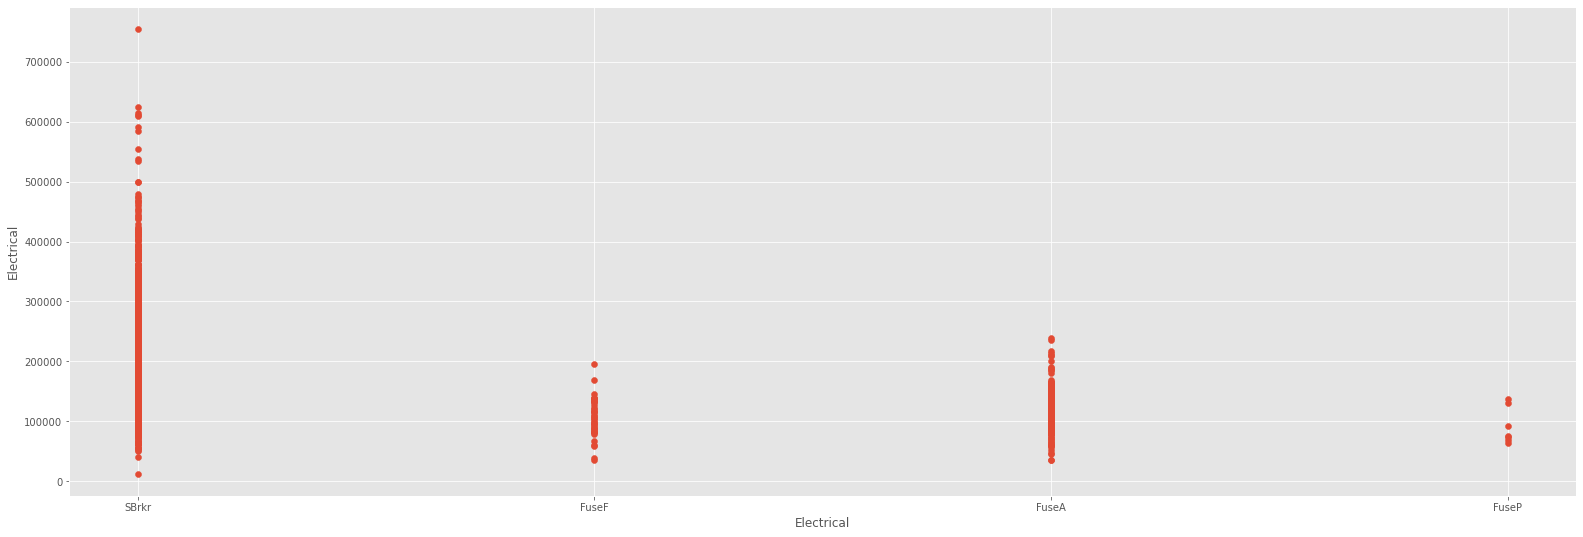

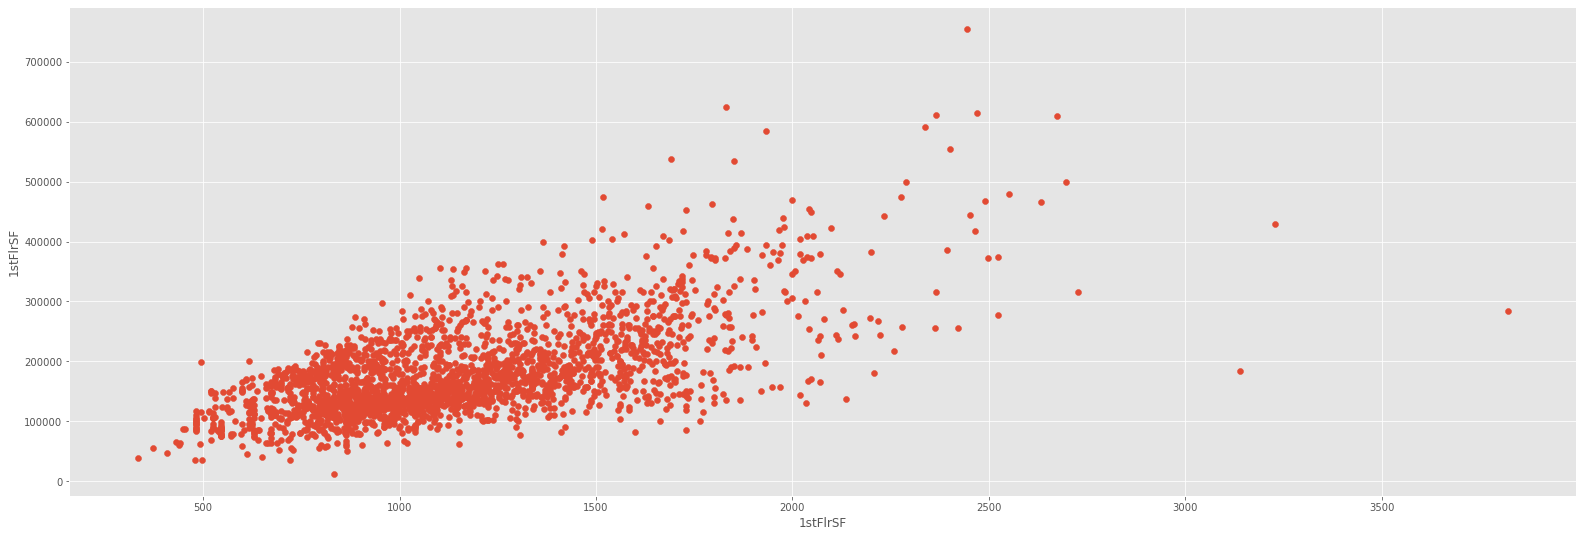

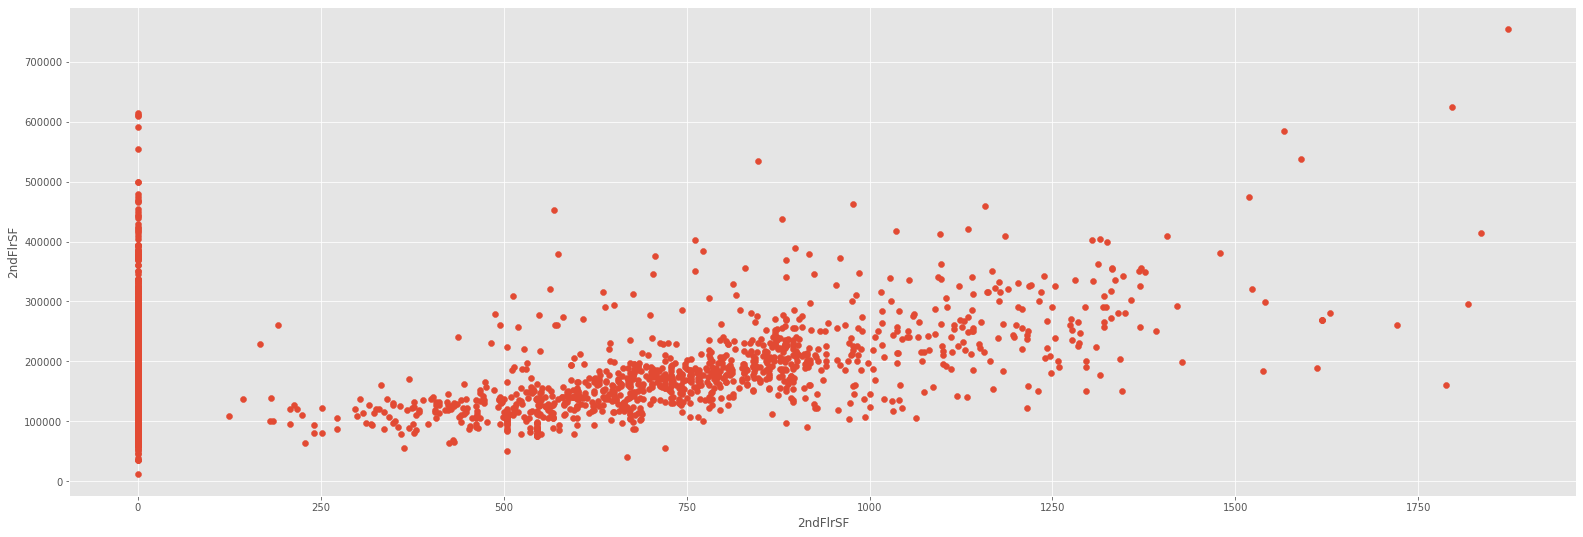

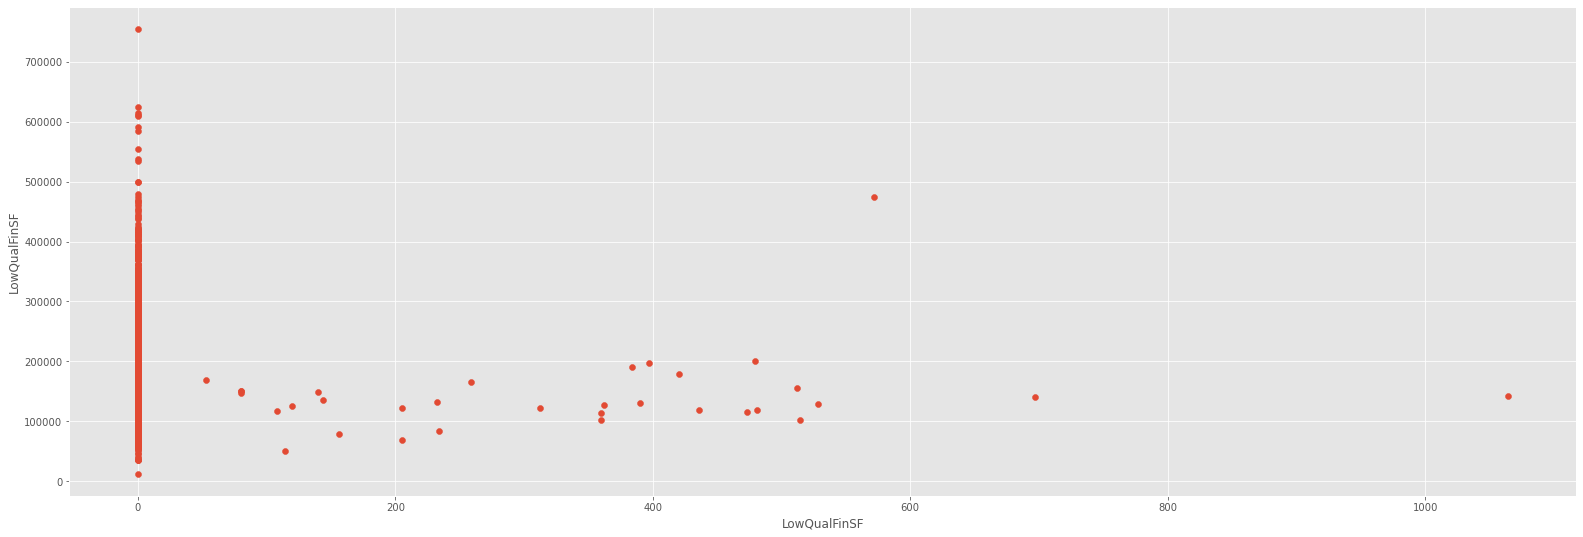

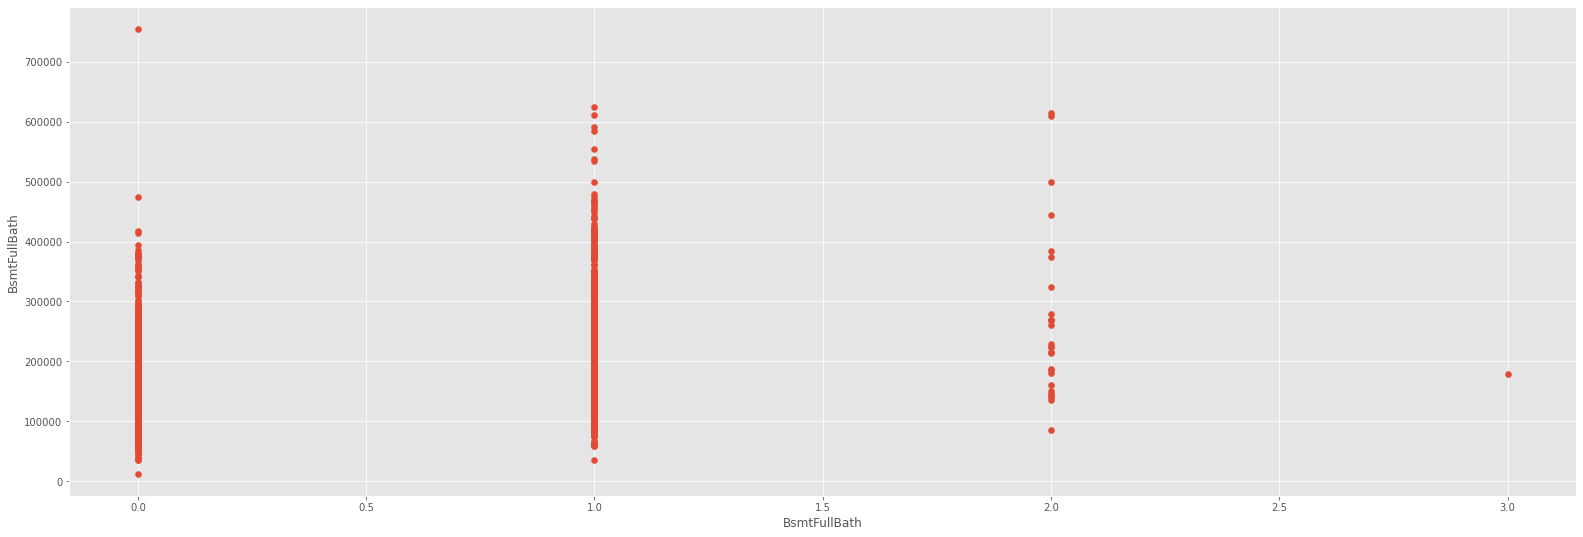

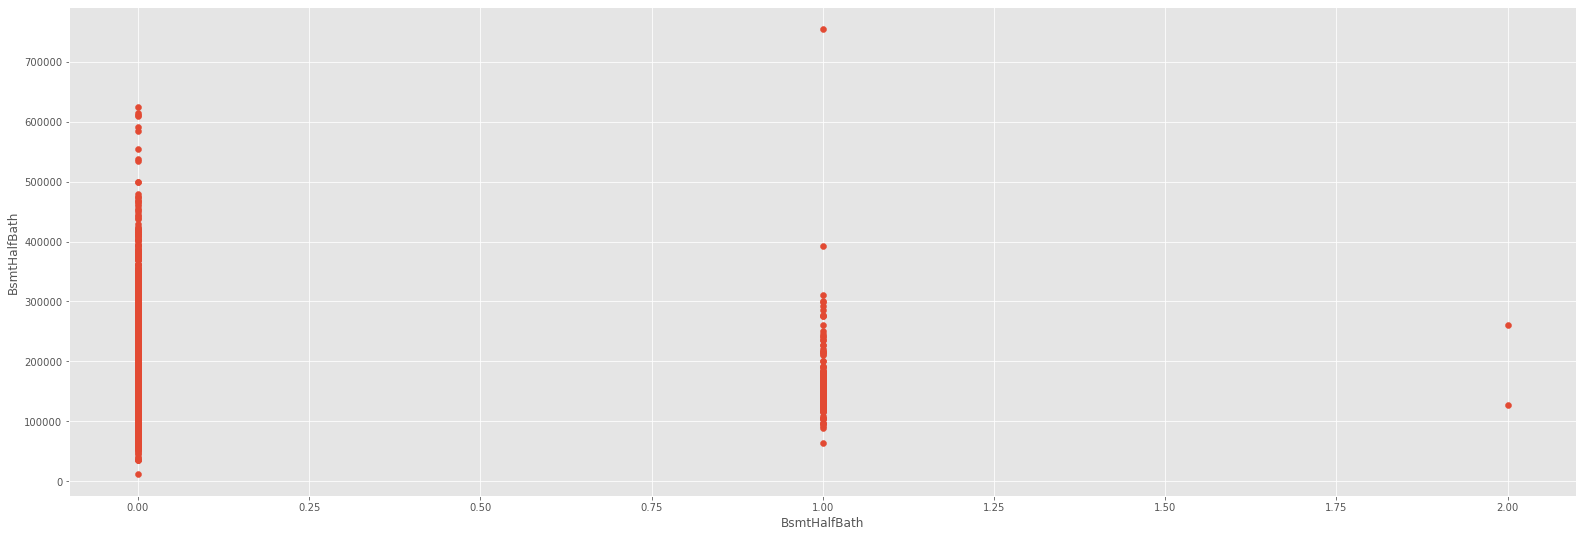

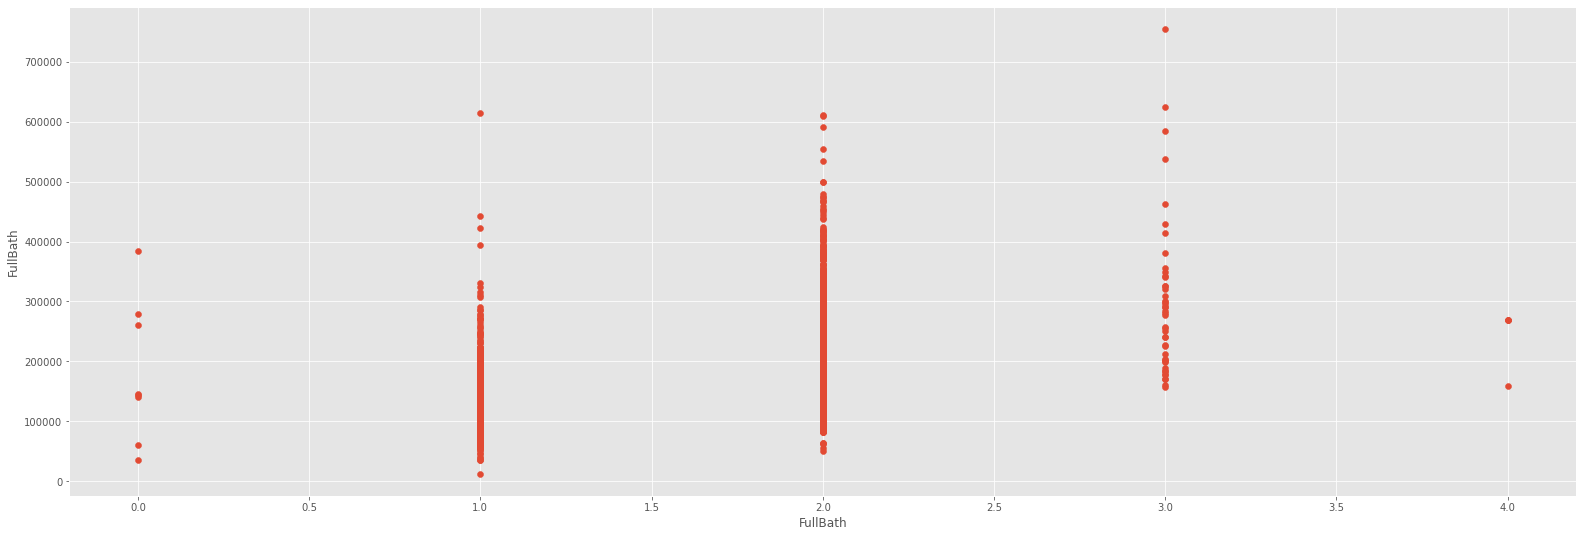

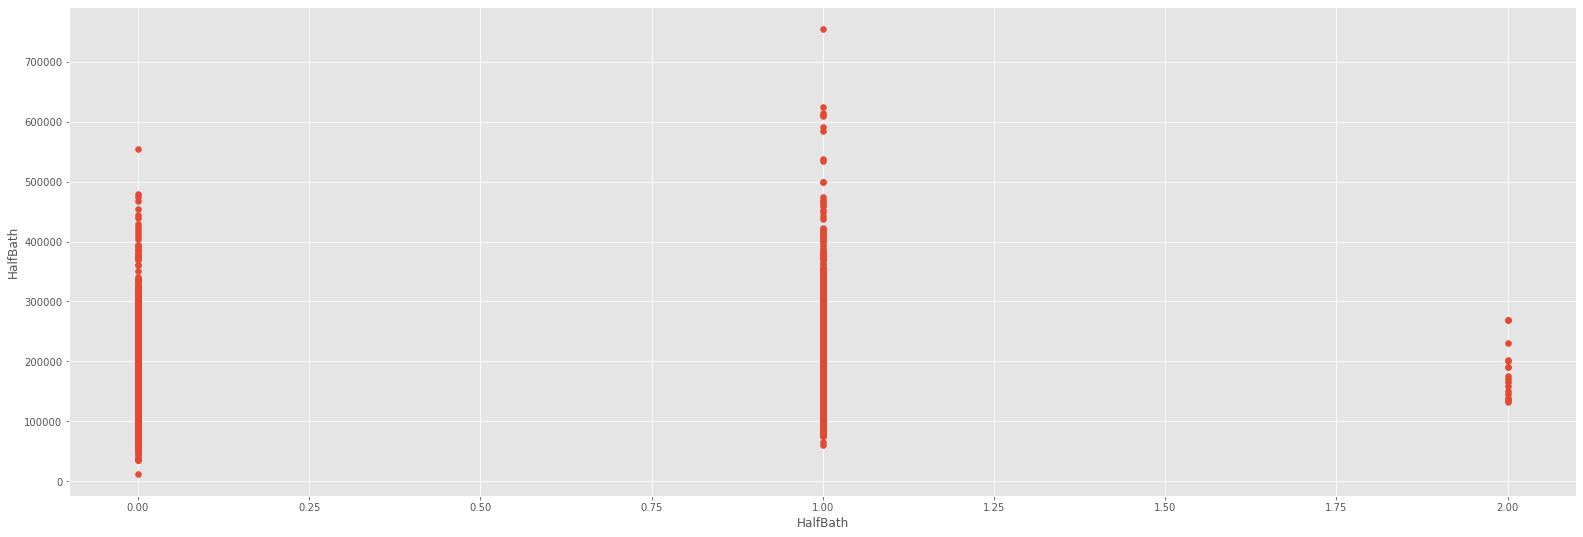

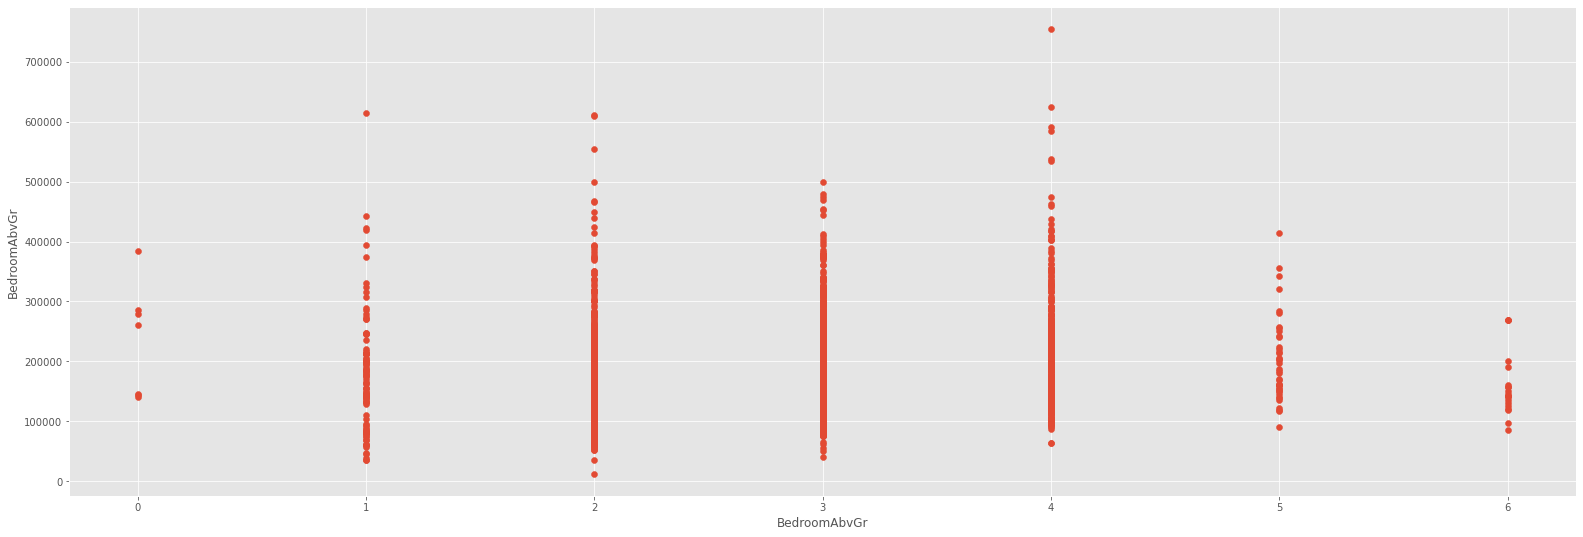

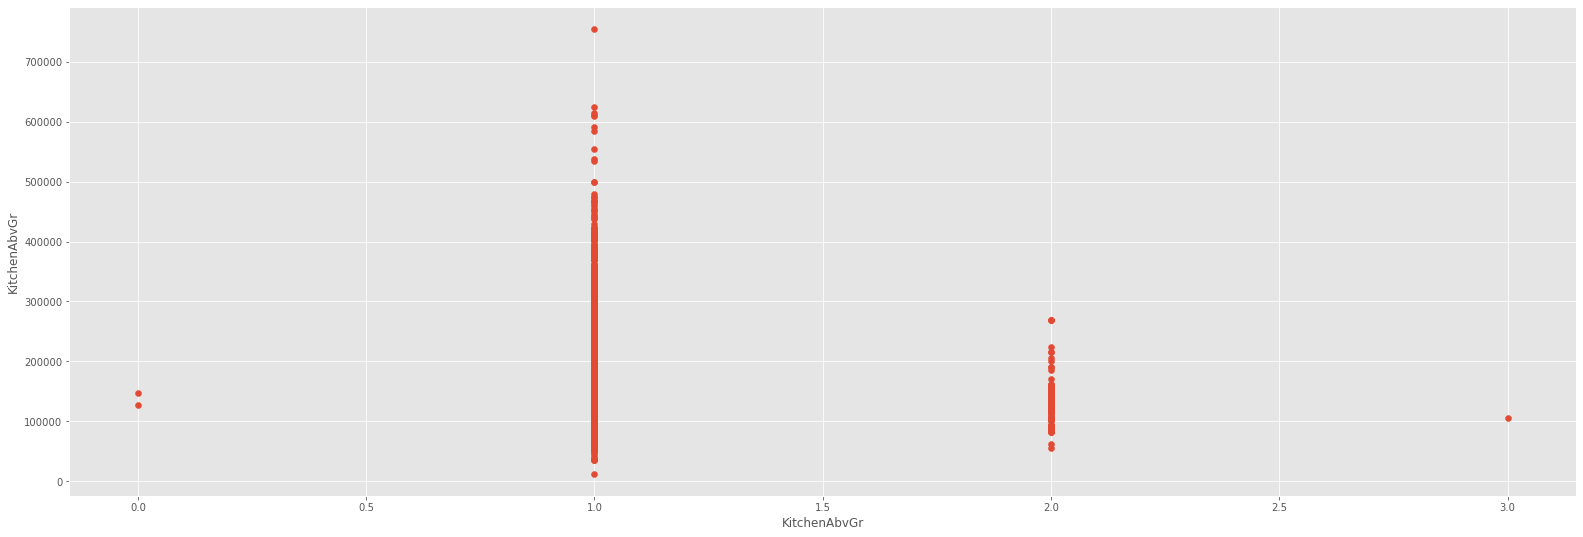

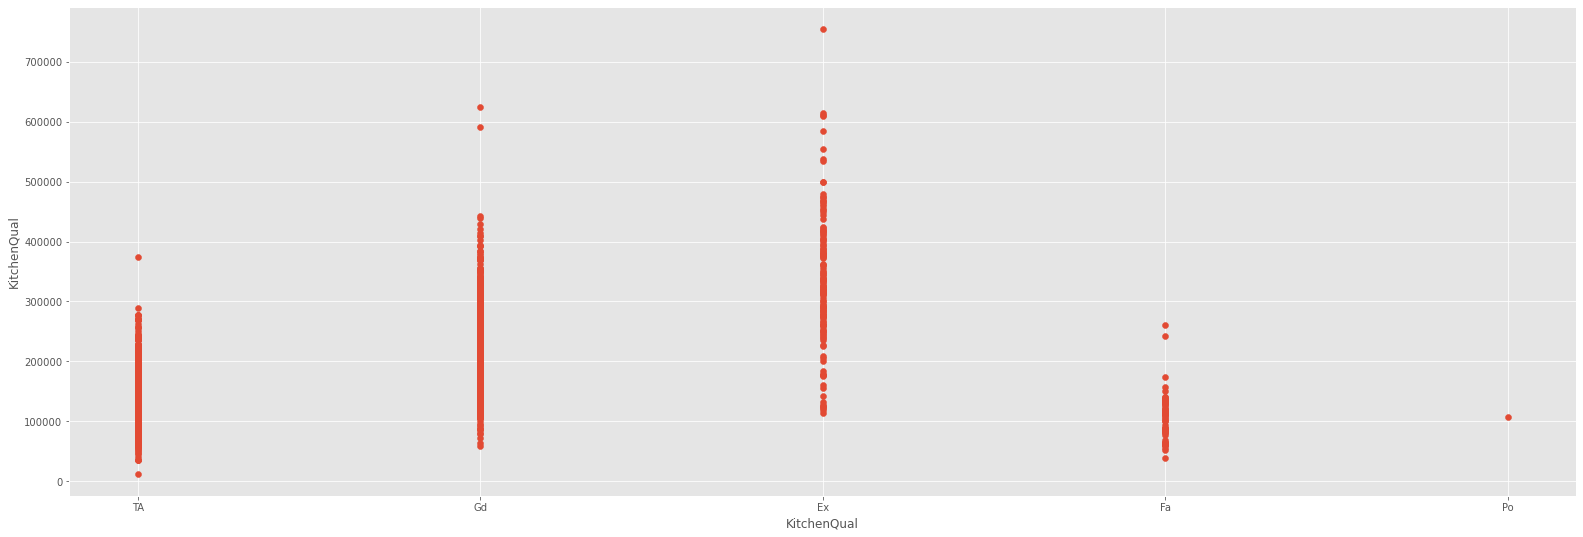

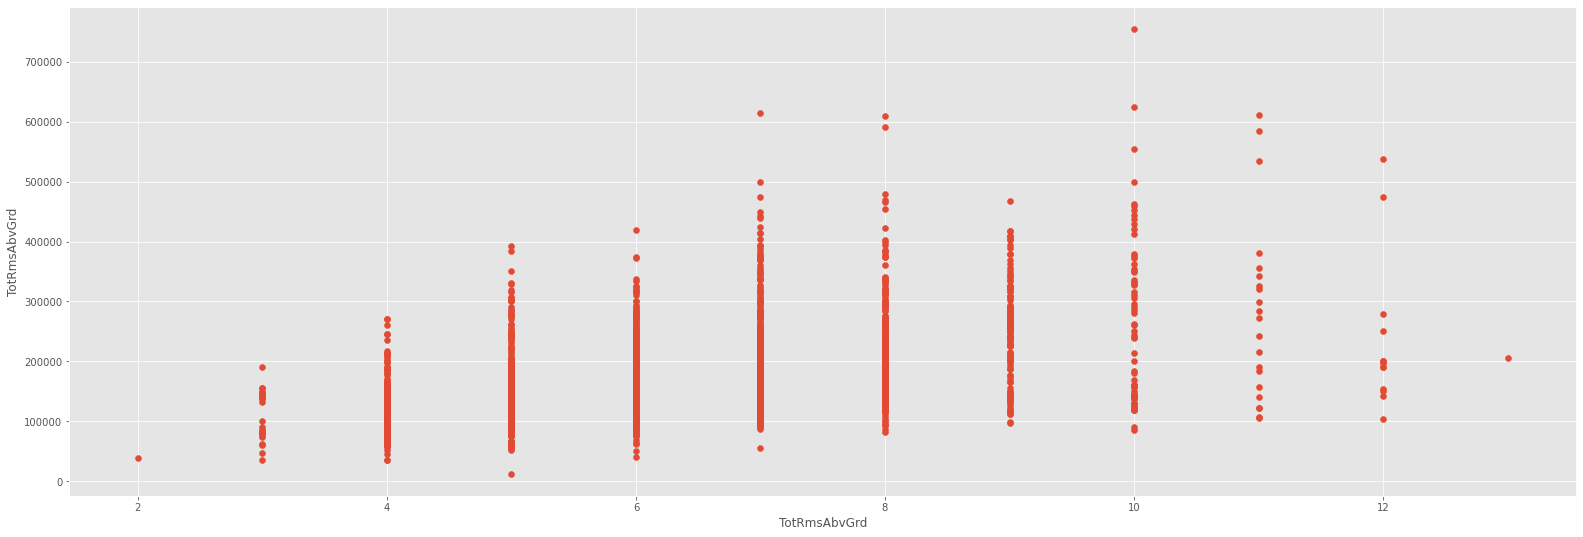

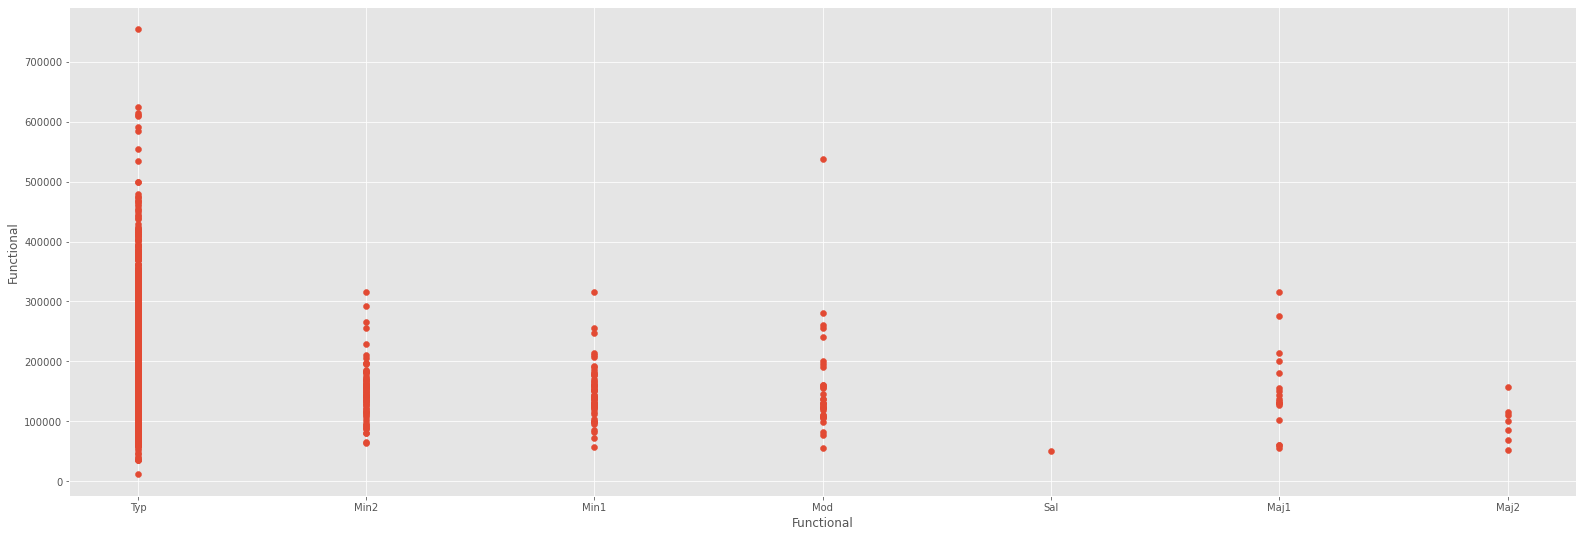

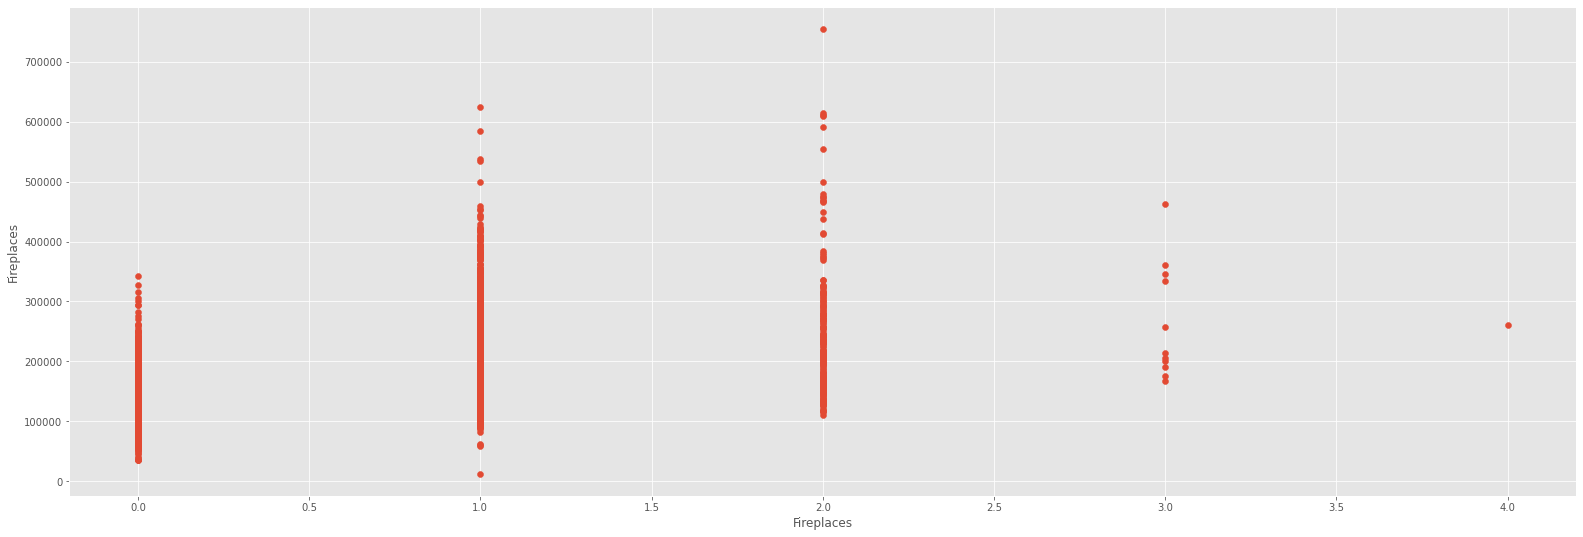

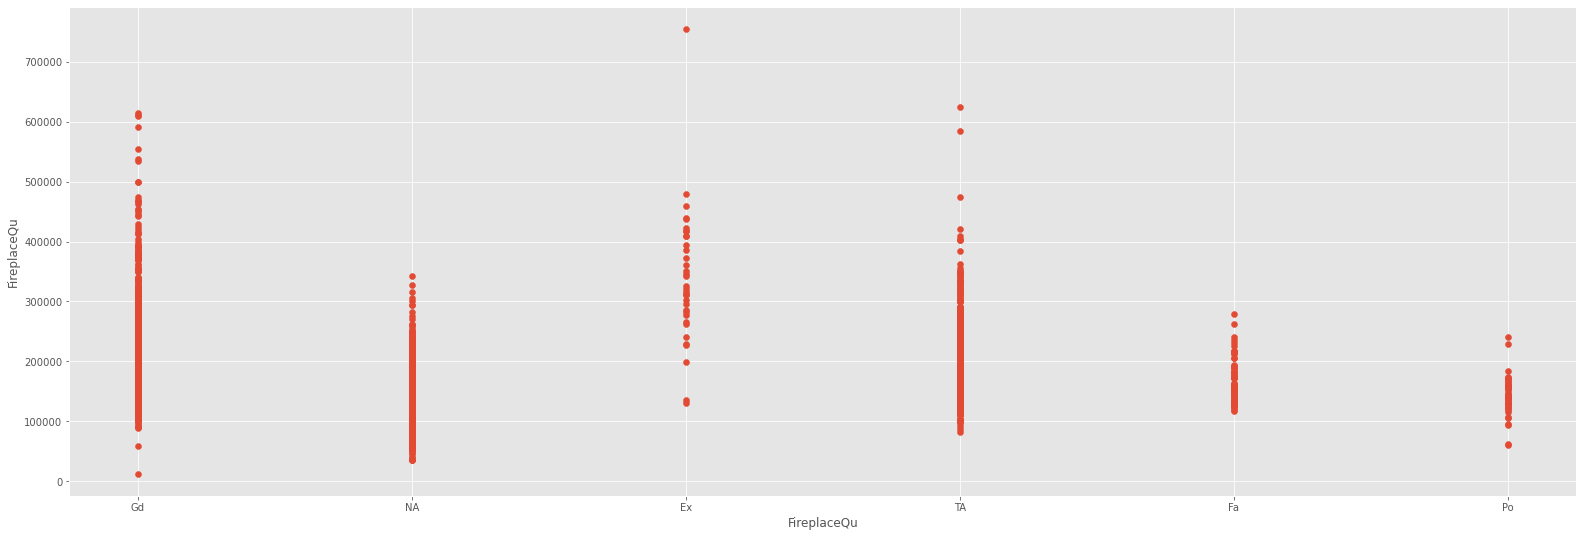

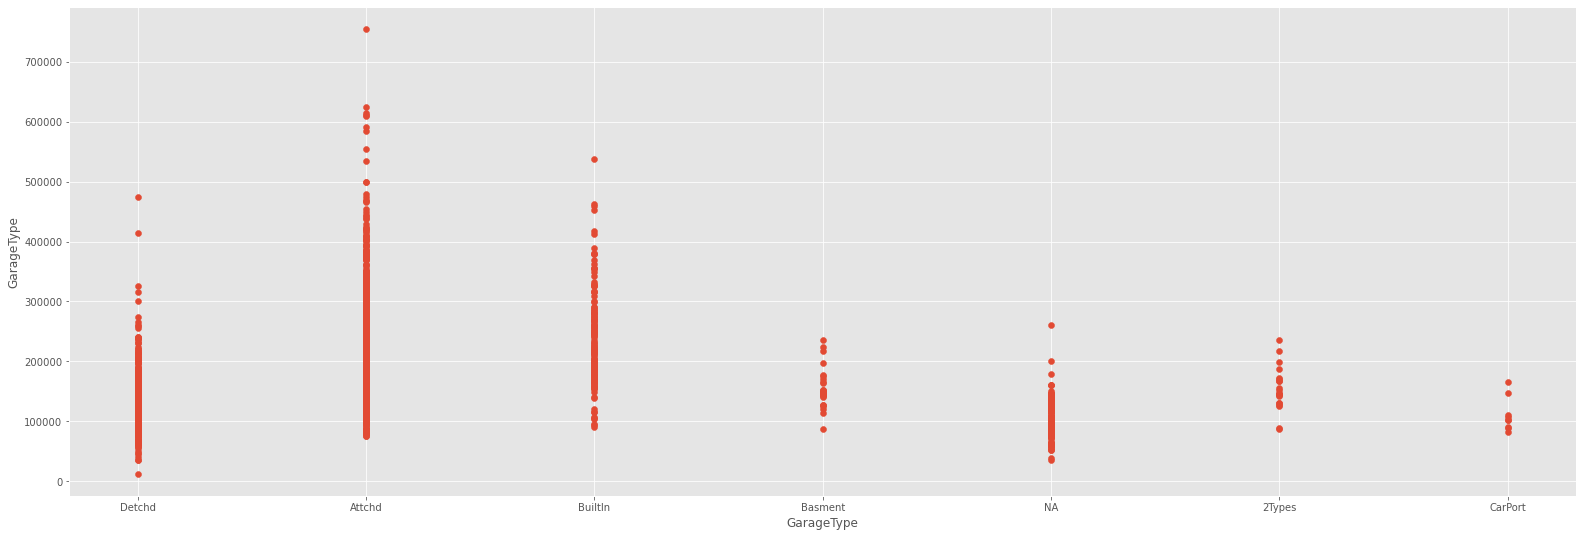

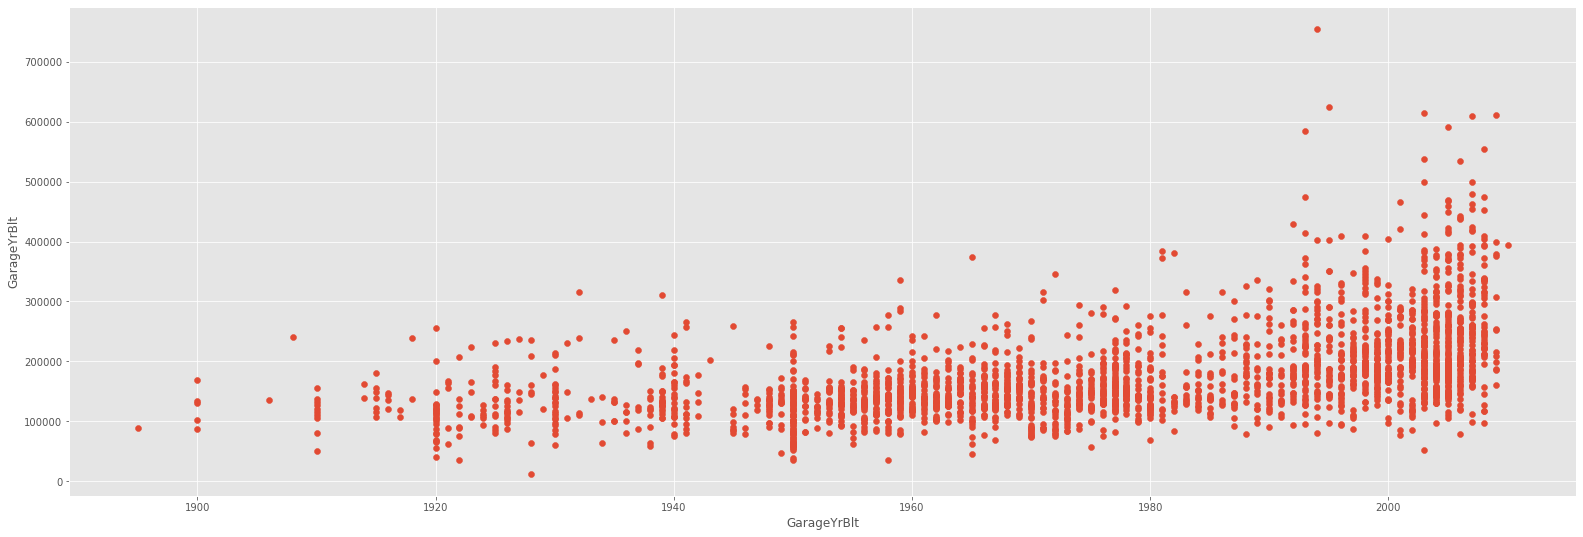

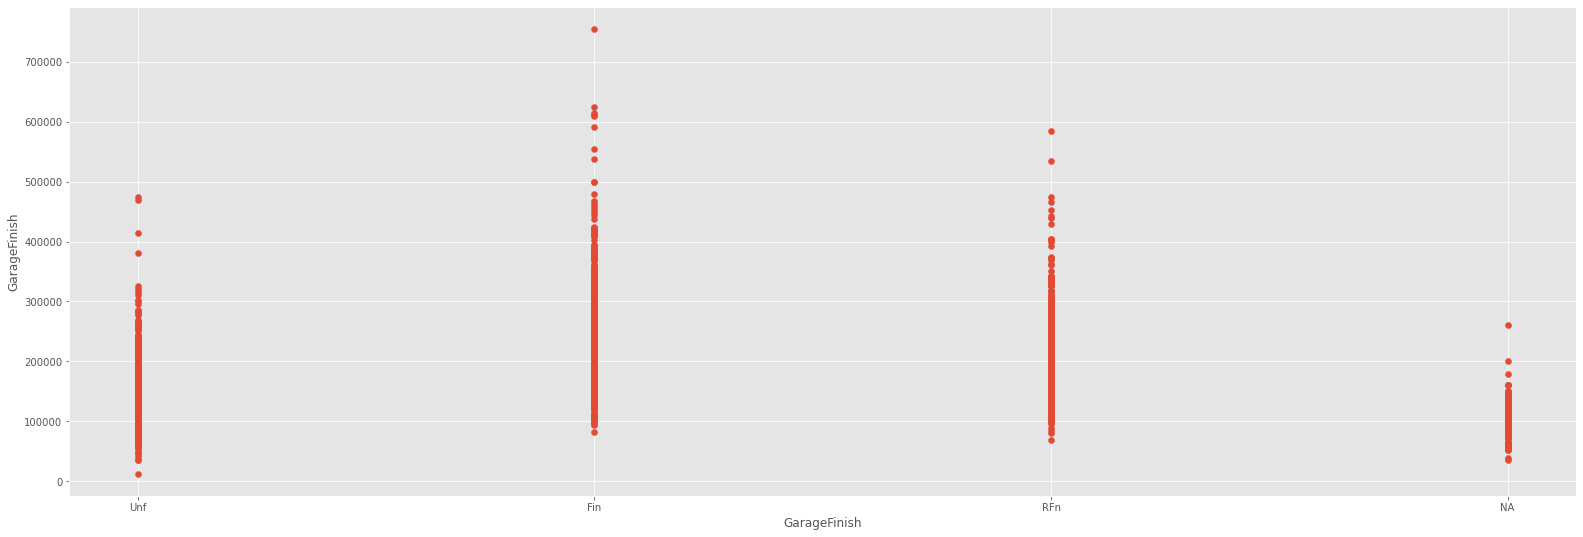

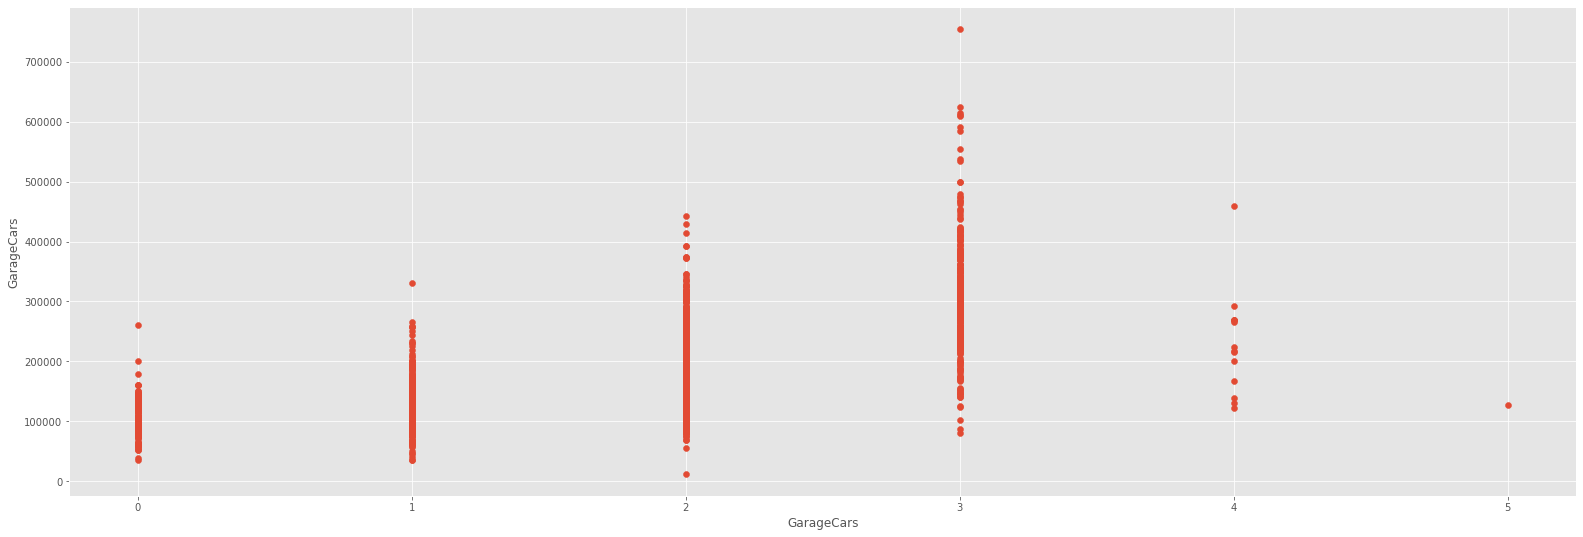

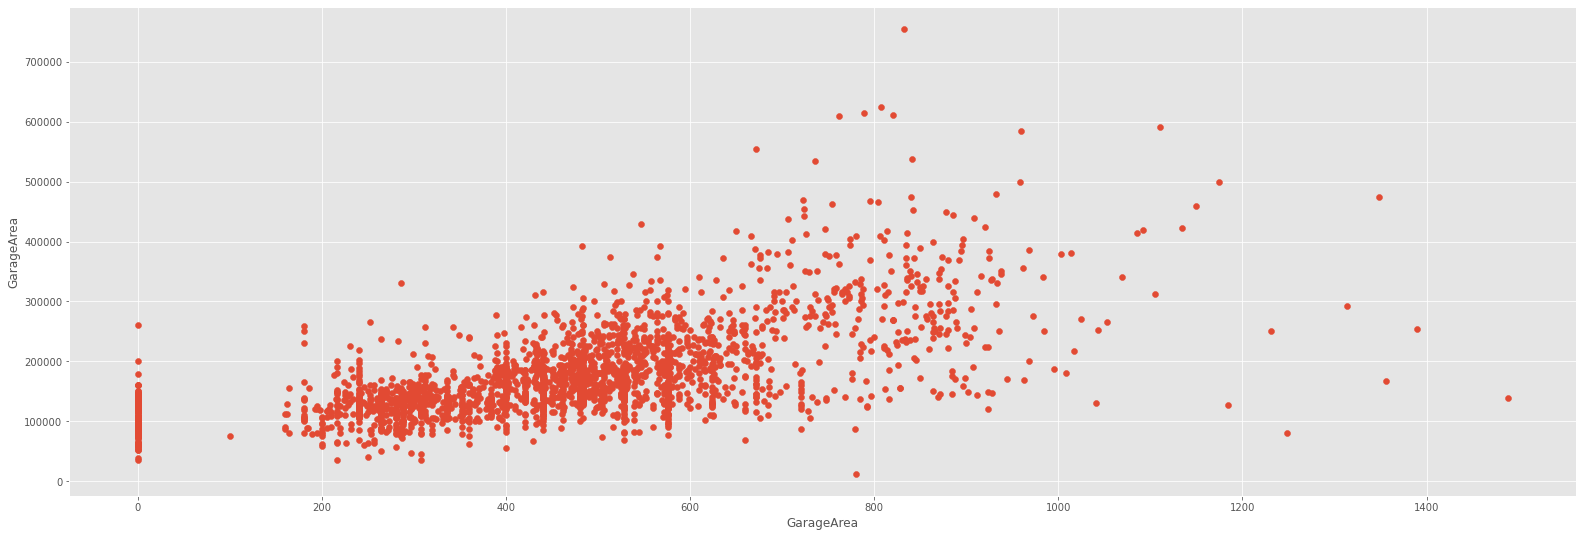

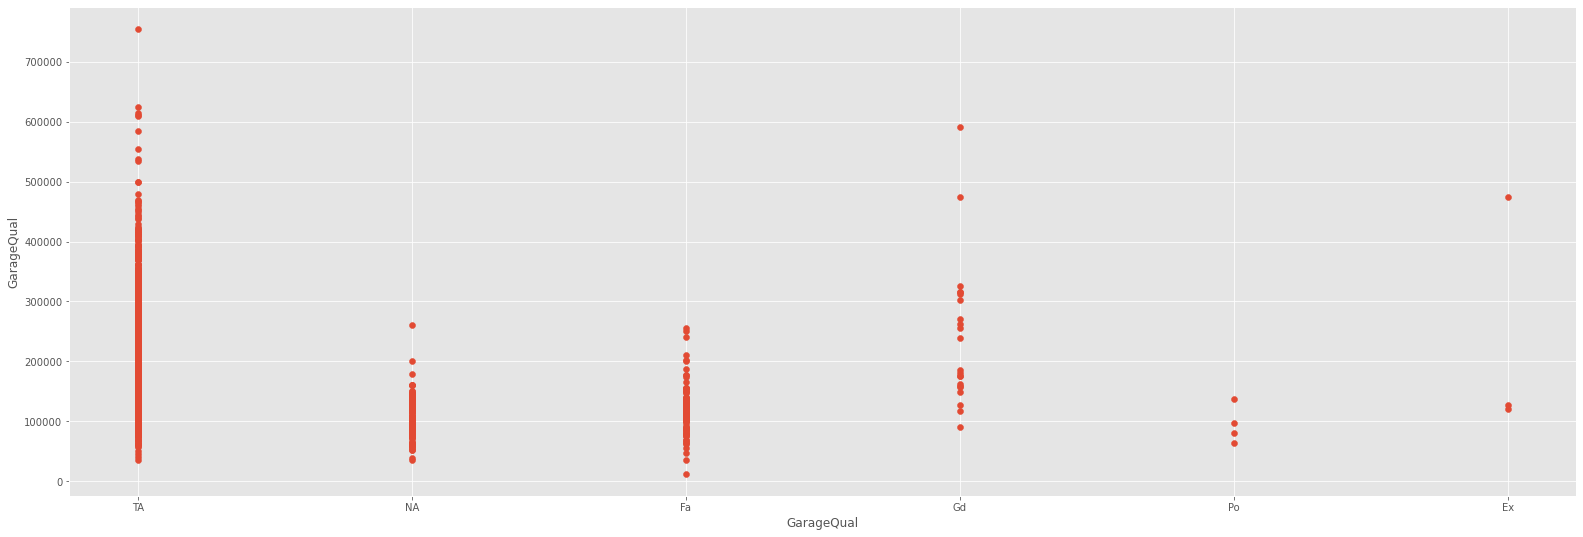

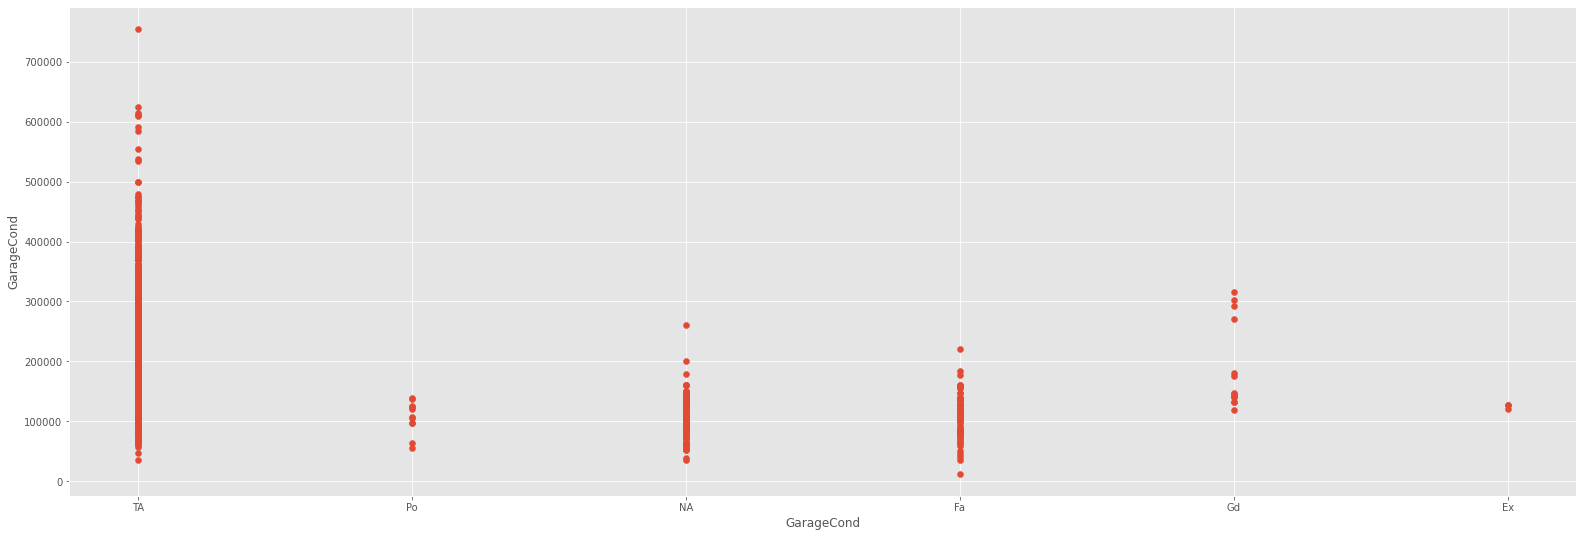

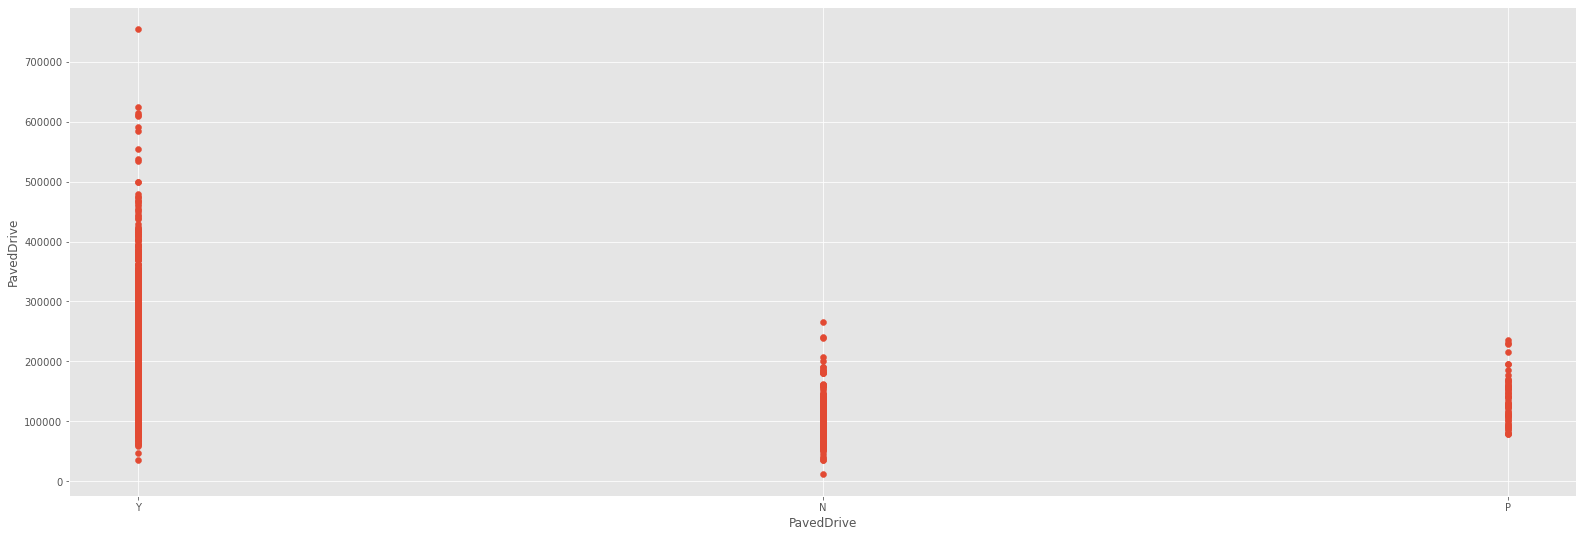

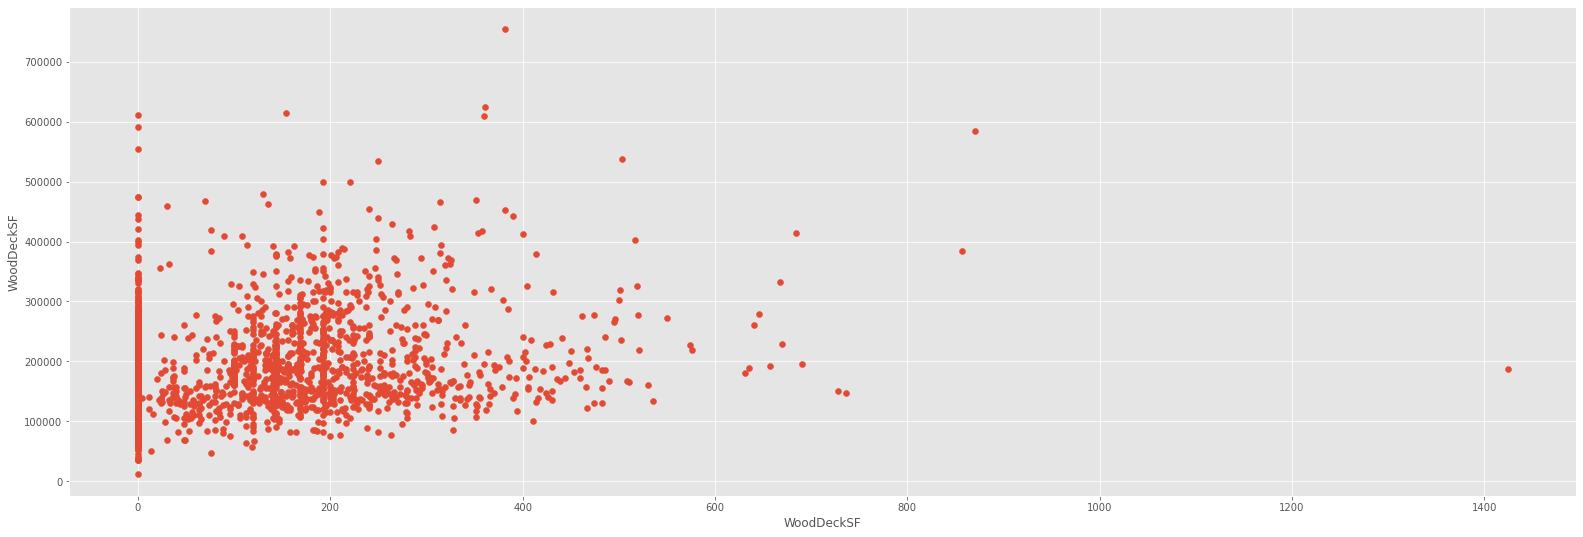

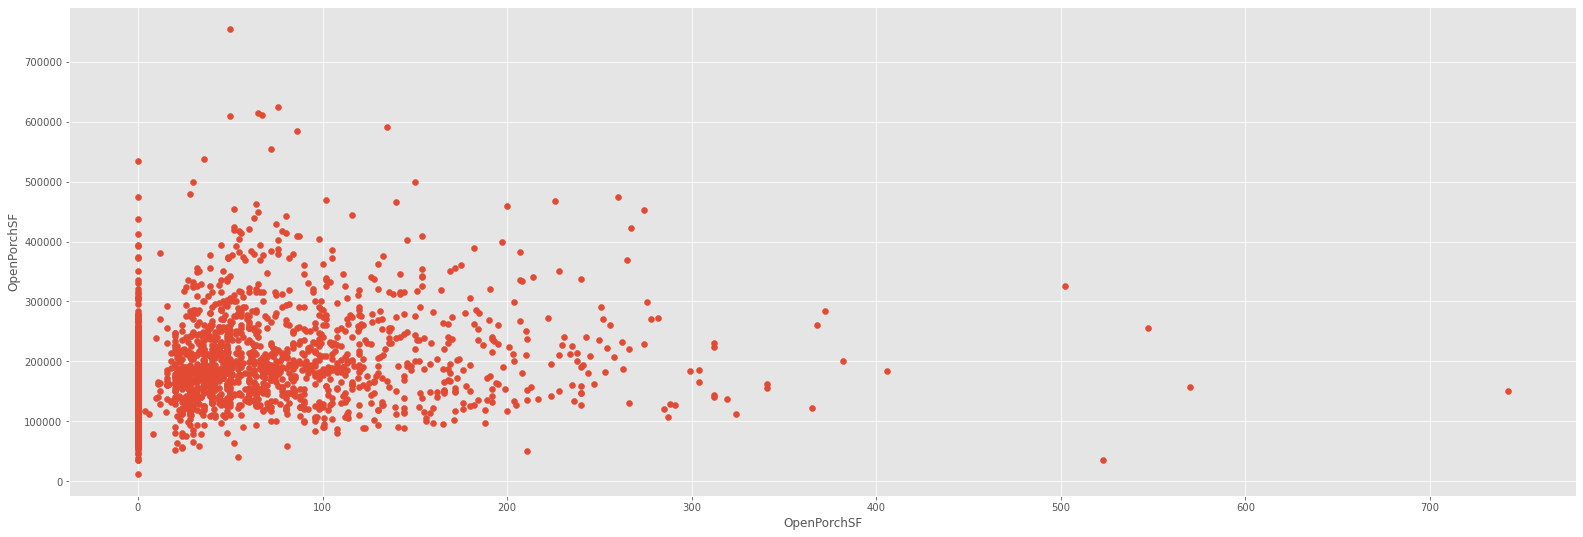

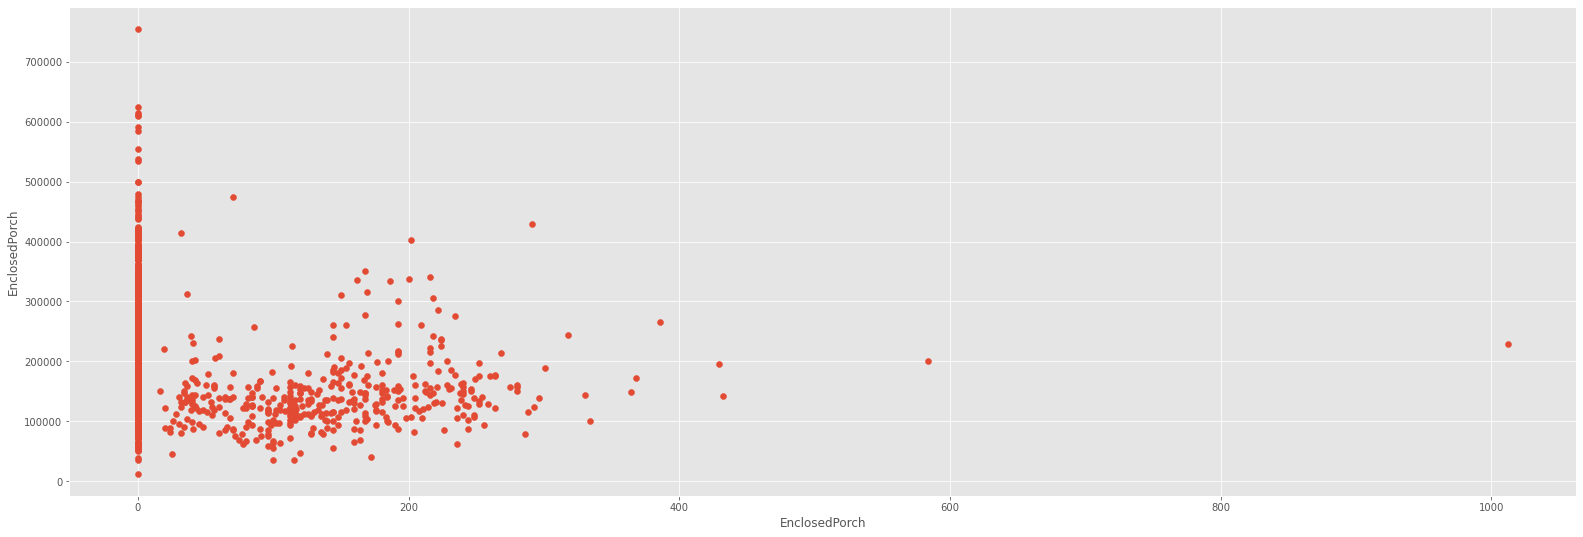

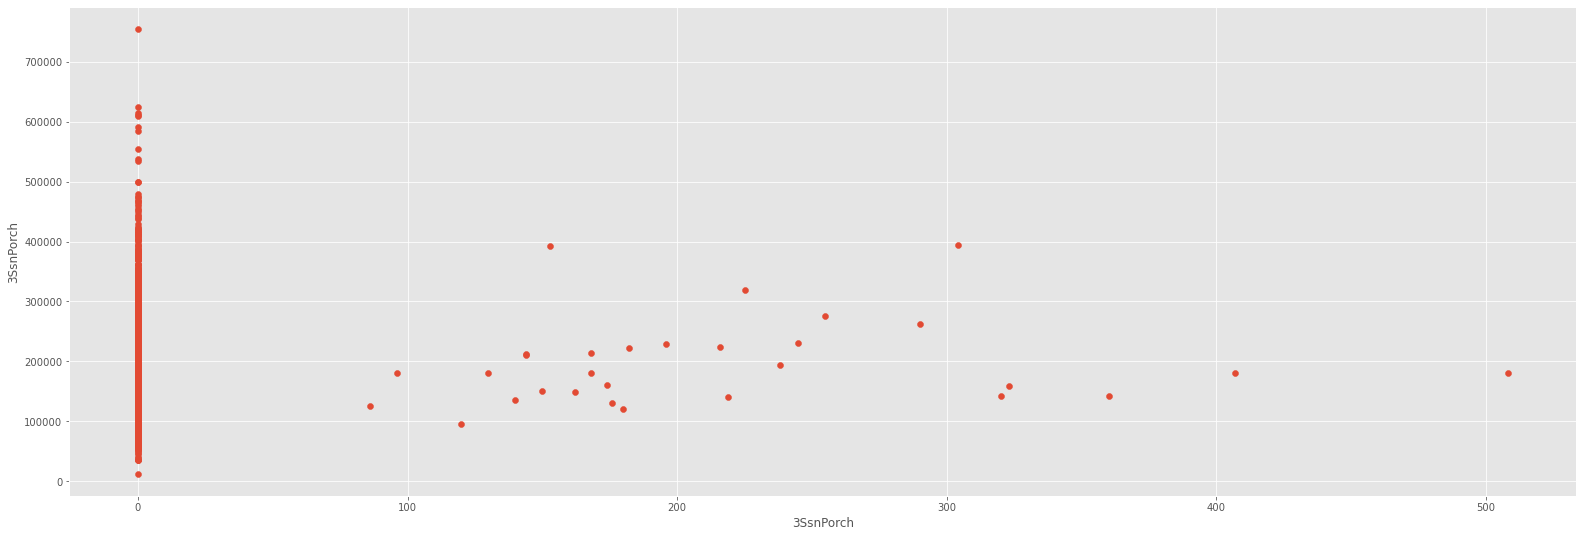

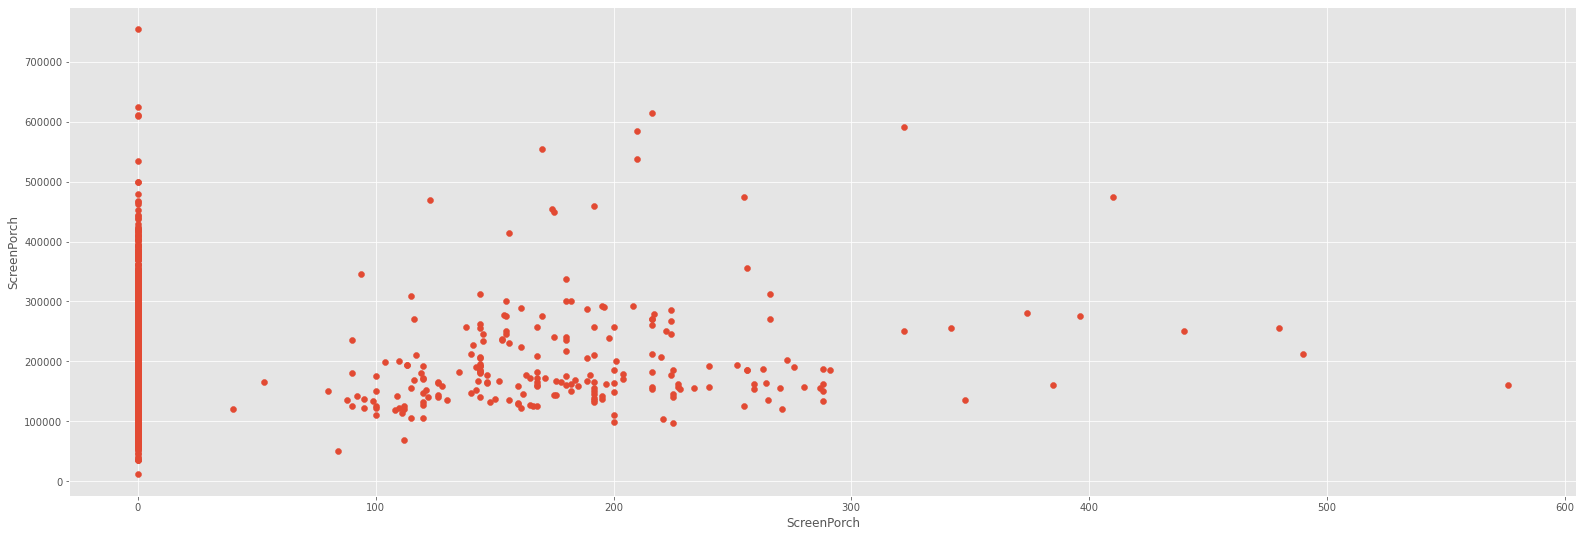

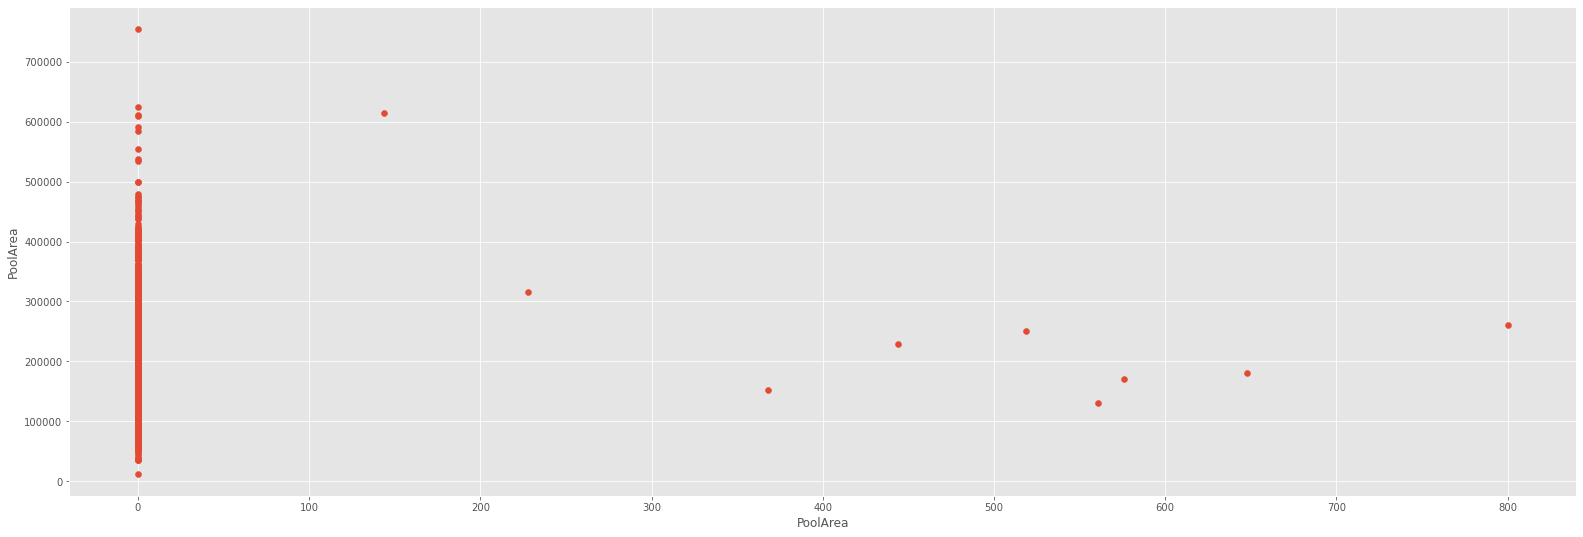

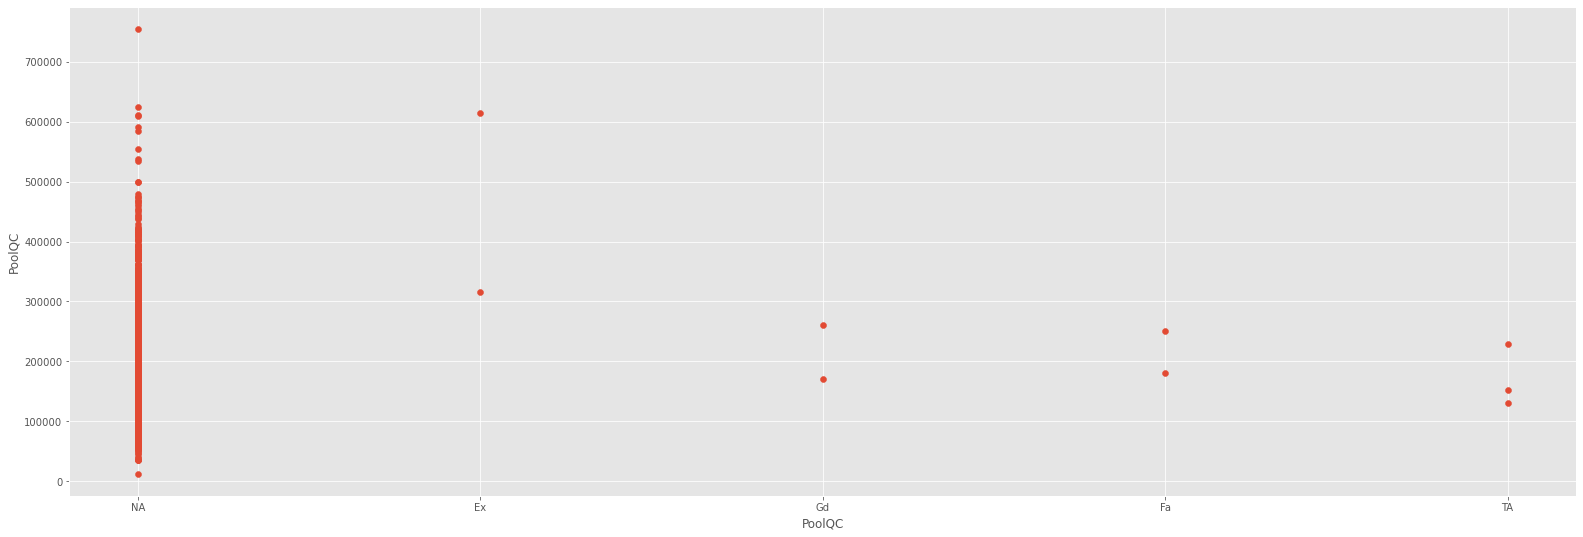

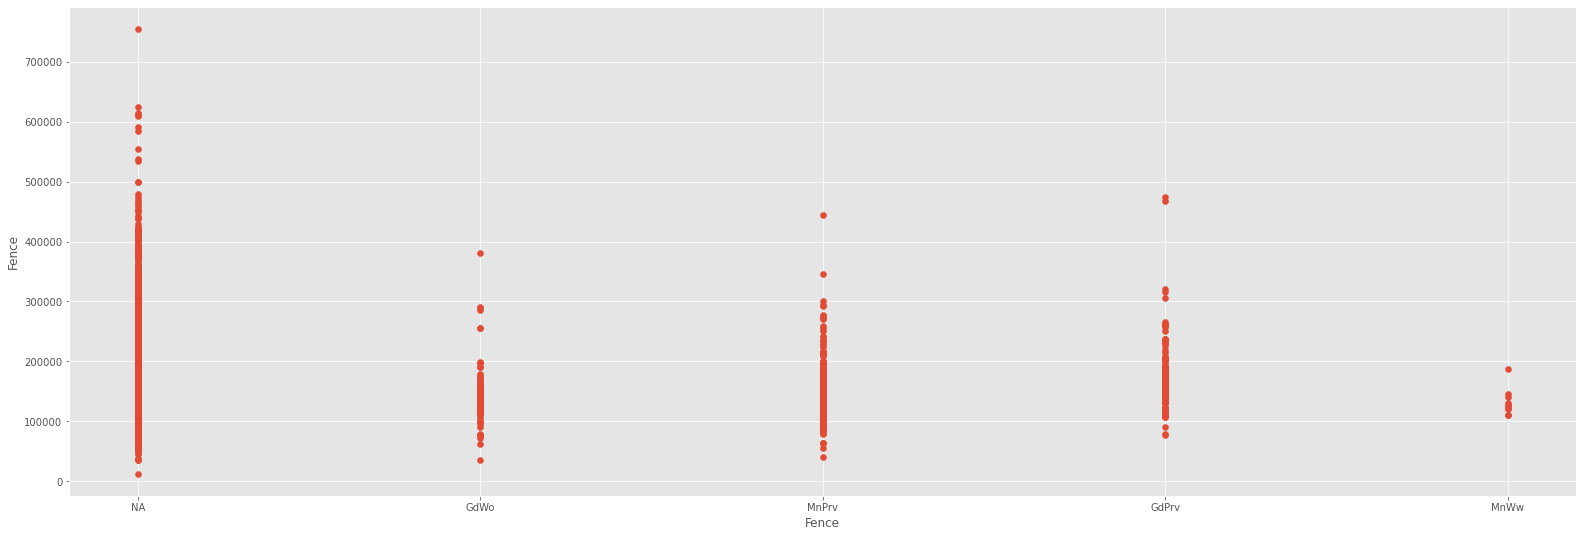

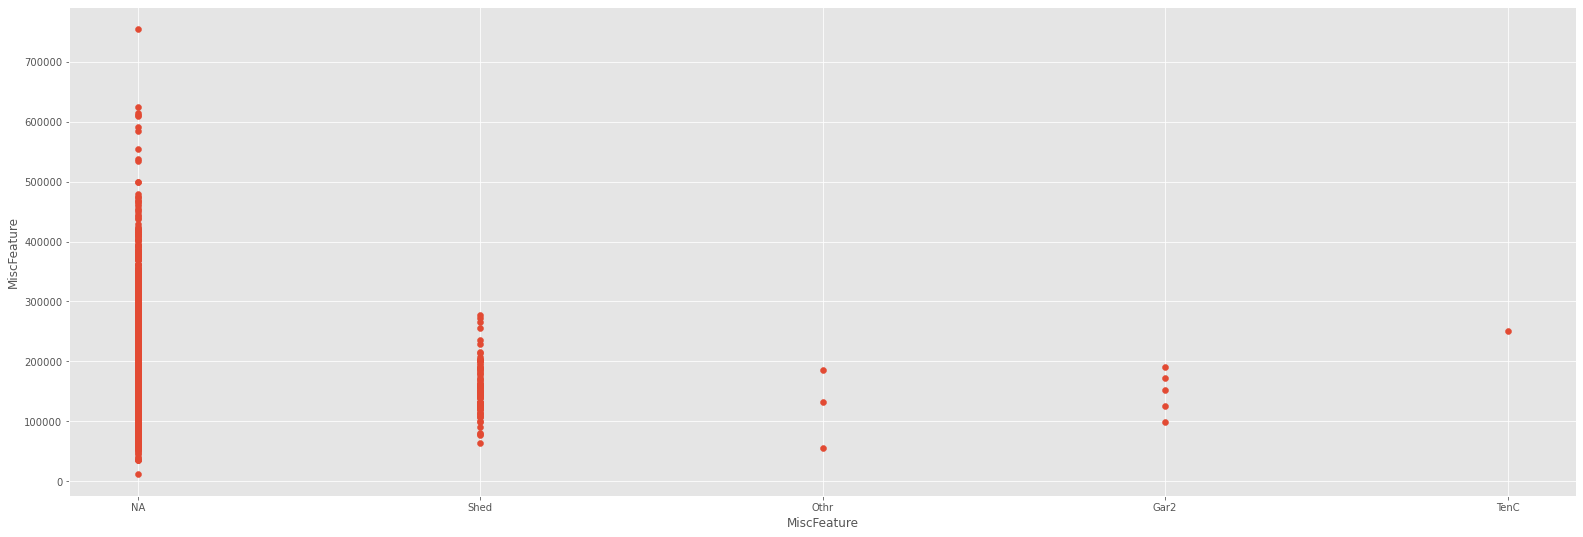

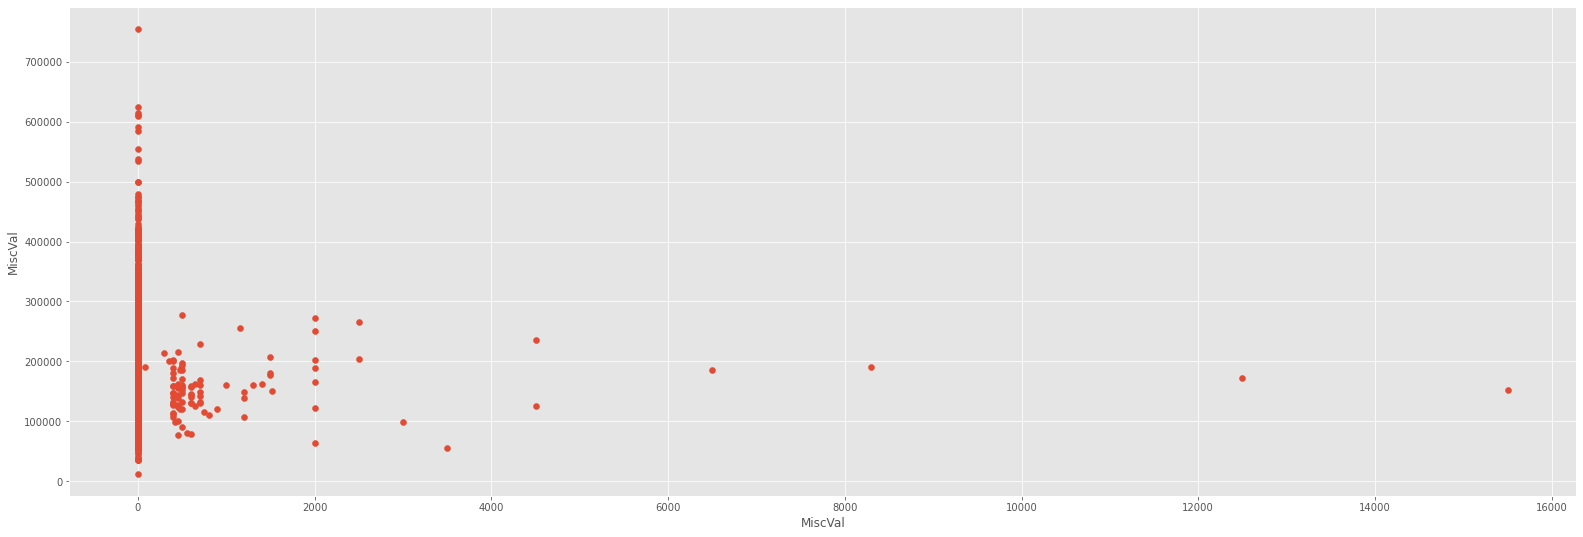

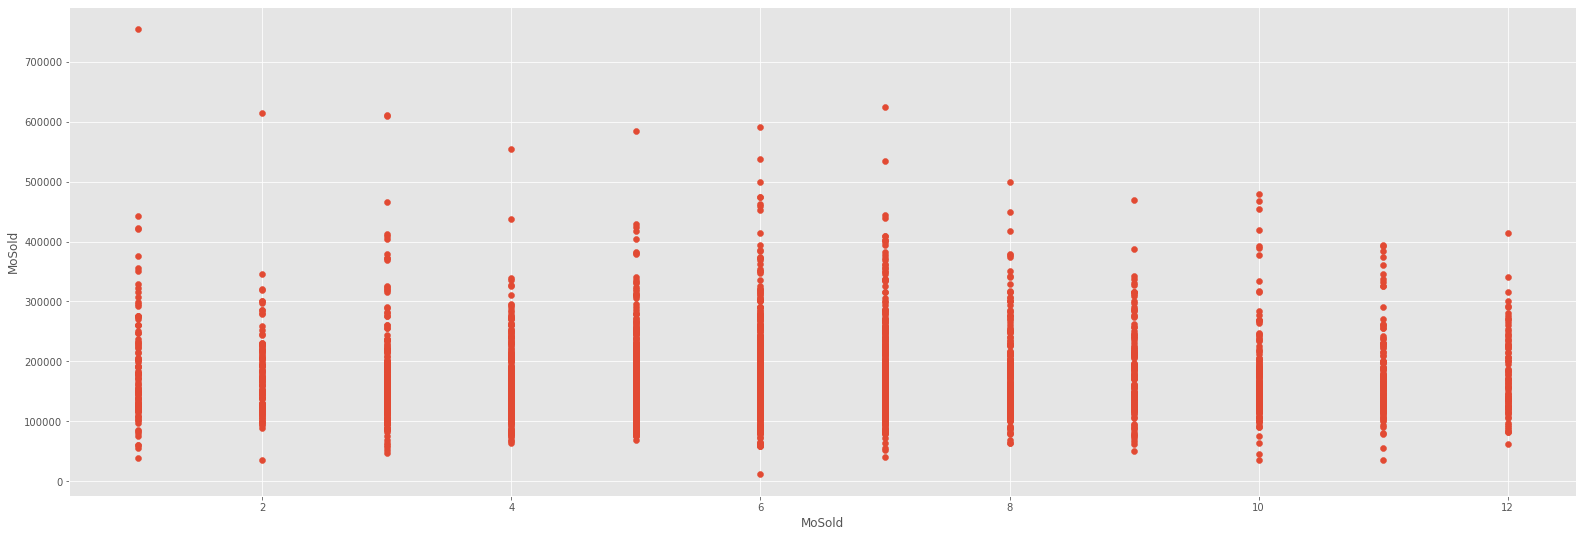

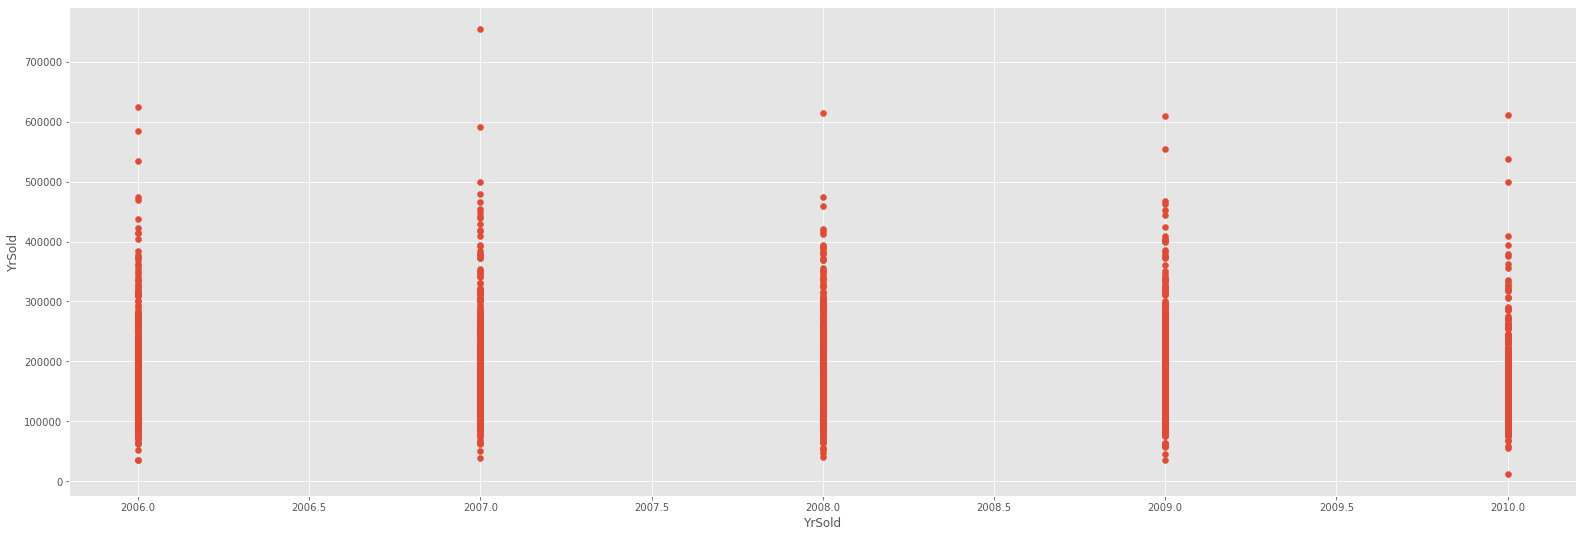

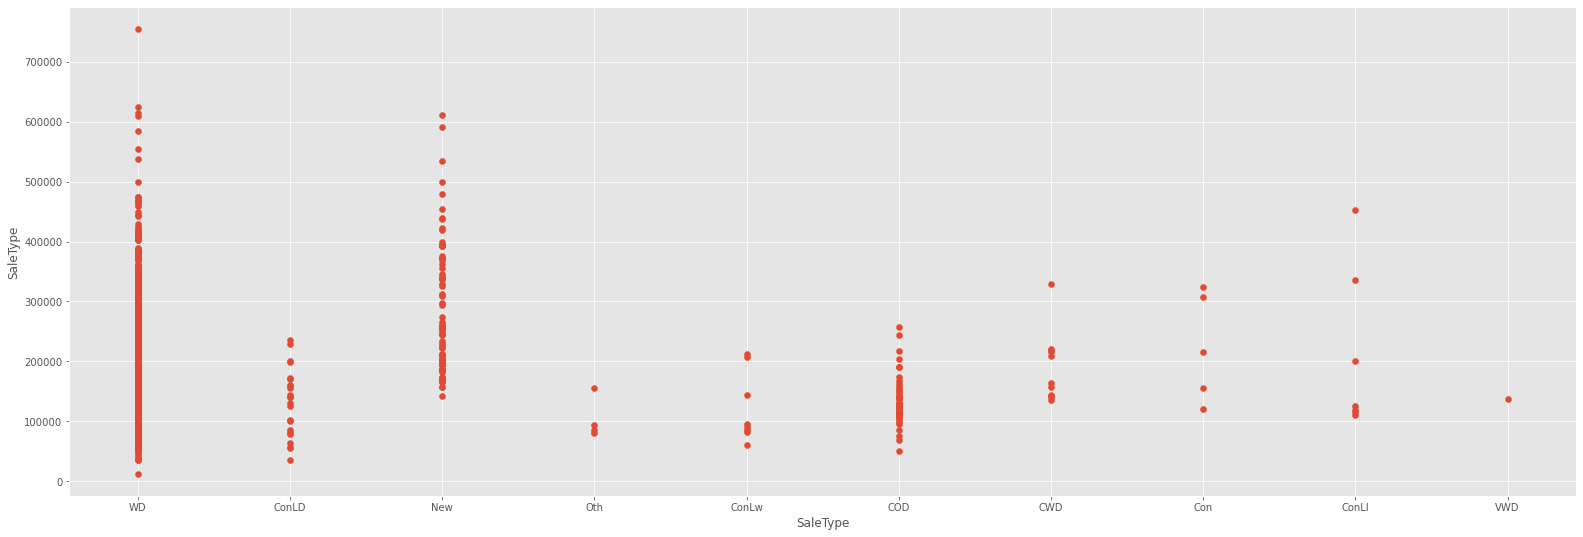

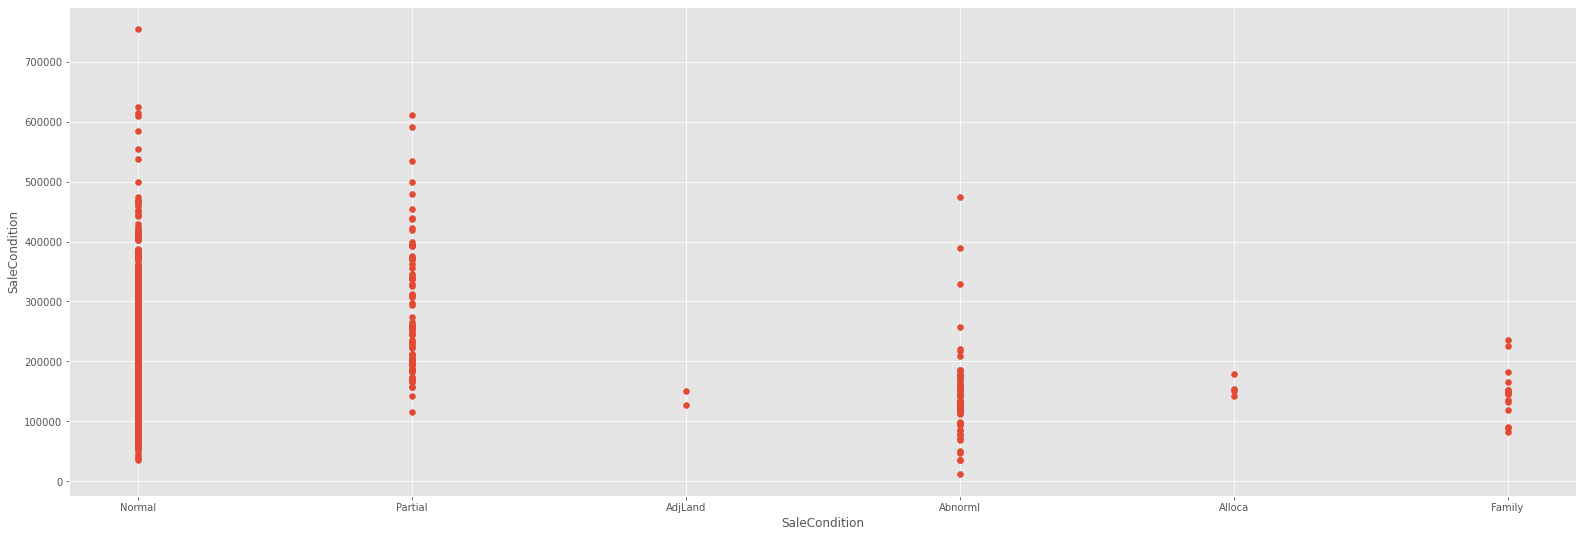

In [78]:
for i in features:
    plt.scatter(data_House_price[i],data_House_price[sale_price])
    plt.xlabel(i)
    plt.ylabel(i)
    plt.show()

In [150]:
pid=data_House_price.PID.unique()
data_House_price['PID'].value_counts()
data_House_price.shape

(2580, 81)

In [151]:
duplicate_obersvation = data_House_price[data_House_price.duplicated()]
duplicate_obersvation

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1818,909276070,1717,194000,50,RL,80.0,12400,Pave,NA,Reg,...,113,0,NA,NA,NA,0,2,2006,WD,Normal


In [152]:
#removing duplicates
data_House_price=data_House_price.drop_duplicates(subset=None, keep='first', inplace=False)
duplicate_obersvation = data_House_price[data_House_price.duplicated()]
duplicate_obersvation

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


In [153]:
data_House_price.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,909176150,856,126000,30,RL,81.468023,7890,Pave,NA,Reg,...,166,0,NA,NA,NA,0,3,2010,WD,Normal
2,905476230,1049,139500,120,RL,42.000000,4235,Pave,NA,Reg,...,0,0,NA,NA,NA,0,2,2009,WD,Normal
3,911128020,1001,124900,30,C (all),60.000000,6060,Pave,NA,Reg,...,0,0,NA,NA,NA,0,11,2007,WD,Normal
4,535377150,1039,114000,70,RL,80.000000,8146,Pave,NA,Reg,...,111,0,NA,NA,NA,0,5,2009,WD,Normal
5,534177230,1665,227000,60,RL,70.000000,8400,Pave,NA,Reg,...,0,0,NA,NA,NA,0,11,2009,WD,Normal


array([[<AxesSubplot:title={'center':'PID'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'SalePrice'}>,
        <AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>],
       [<AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>],
       [<AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>,
        <AxesSubplot:title={'center':'TotalBsmtSF'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>],
       [<AxesSubplot:title={'center':'BsmtFullBath'}>

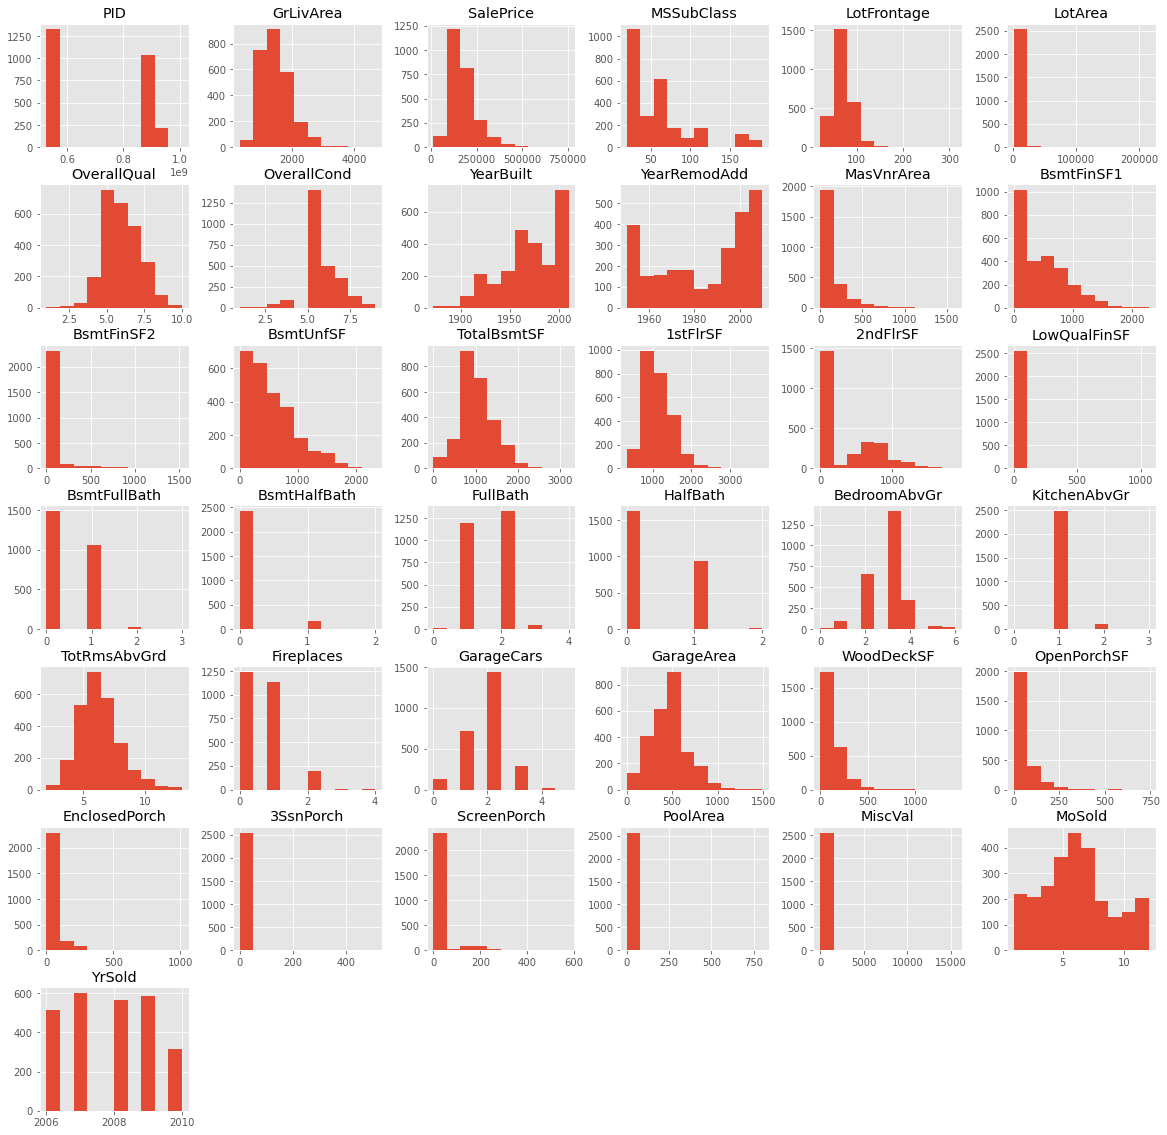

In [154]:
#Histogram of all numeric variables
data_House_price.hist(figsize=(20,20))

In [155]:
data_House_price.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond

In [156]:
#numerical variables
numerical_variables=data_House_price.select_dtypes(exclude=["bool_","object_"])
#categorical variables
categorical_variables=data_House_price.select_dtypes(exclude=["number"])
categorical_variables

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
1,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,...,1939.0,Unf,TA,TA,Y,NA,NA,NA,WD,Normal
2,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,...,1984.0,Fin,TA,TA,Y,NA,NA,NA,WD,Normal
3,C (all),Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,...,1930.0,Unf,TA,Po,N,NA,NA,NA,WD,Normal
4,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,...,1940.0,Unf,TA,TA,N,NA,NA,NA,WD,Normal
5,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,2001.0,Fin,TA,TA,Y,NA,NA,NA,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,...,1916.0,Unf,Fa,Po,P,NA,NA,NA,WD,Normal
2577,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,...,1955.0,Unf,TA,TA,Y,NA,NA,NA,WD,Normal
2578,RH,Pave,NA,Reg,HLS,AllPub,Inside,Gtl,Crawfor,Norm,...,1949.0,Unf,TA,TA,Y,NA,NA,NA,WD,Normal
2579,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,2000.0,Fin,TA,TA,Y,NA,NA,NA,WD,Normal


In [157]:
#categorical variables distribution and analysis
categorical_columns=categorical_variables.columns

for feature in categorical_columns:
    print(data_House_price[feature].value_counts())
    print('')  


RL         2007
RM          418
FV          113
RH           21
C (all)      17
I (all)       2
A (agr)       1
Name: MSZoning, dtype: int64

Pave    2569
Grvl      10
Name: Street, dtype: int64

NA      2411
Grvl     105
Pave      63
Name: Alley, dtype: int64

Reg    1640
IR1     855
IR2      71
IR3      13
Name: LotShape, dtype: int64

Lvl    2337
Bnk      95
HLS      95
Low      52
Name: LandContour, dtype: int64

AllPub    2577
NoSewr       2
Name: Utilities, dtype: int64

Inside     1885
Corner      439
CulDSac     164
FR2          78
FR3          13
Name: LotConfig, dtype: int64

Gtl    2458
Mod     108
Sev      13
Name: LandSlope, dtype: int64

NAmes      410
CollgCr    236
OldTown    213
Edwards    165
Somerst    143
Gilbert    143
Sawyer     139
NWAmes     123
NridgHt    121
SawyerW    113
Mitchel    104
BrkSide    103
Crawfor     92
IDOTRR      76
NoRidge     67
Timber      54
StoneBr     43
SWISU       42
ClearCr     40
MeadowV     34
BrDale      29
Blmngtn     23
Veenker   

In [158]:
#Null count in categorical
for feature in categorical_columns:
    print(feature)
    print(np.sum(data_House_price[feature].isnull()))
    print('')

MSZoning
0

Street
0

Alley
0

LotShape
0

LandContour
0

Utilities
0

LotConfig
0

LandSlope
0

Neighborhood
0

Condition1
0

Condition2
0

BldgType
0

HouseStyle
0

RoofStyle
0

RoofMatl
0

Exterior1st
0

Exterior2nd
0

MasVnrType
0

ExterQual
0

ExterCond
0

Foundation
0

BsmtQual
0

BsmtCond
0

BsmtExposure
0

BsmtFinType1
0

BsmtFinType2
0

Heating
0

HeatingQC
0

CentralAir
0

Electrical
0

KitchenQual
0

Functional
0

FireplaceQu
0

GarageType
0

GarageYrBlt
0

GarageFinish
0

GarageQual
0

GarageCond
0

PavedDrive
0

PoolQC
0

Fence
0

MiscFeature
0

SaleType
0

SaleCondition
0



In [159]:
#Null count in numerical variables
for nfeature in numerical_variables:
    print(nfeature)
    print(np.sum(data_House_price[nfeature].isnull()))
    print('')

PID
0

GrLivArea
0

SalePrice
0

MSSubClass
0

LotFrontage
0

LotArea
0

OverallQual
0

OverallCond
0

YearBuilt
0

YearRemodAdd
0

MasVnrArea
0

BsmtFinSF1
0

BsmtFinSF2
0

BsmtUnfSF
0

TotalBsmtSF
0

1stFlrSF
0

2ndFlrSF
0

LowQualFinSF
0

BsmtFullBath
0

BsmtHalfBath
0

FullBath
0

HalfBath
0

BedroomAbvGr
0

KitchenAbvGr
0

TotRmsAbvGrd
0

Fireplaces
0

GarageCars
0

GarageArea
0

WoodDeckSF
0

OpenPorchSF
0

EnclosedPorch
0

3SsnPorch
0

ScreenPorch
0

PoolArea
0

MiscVal
0

MoSold
0

YrSold
0



In [160]:
#correlation between numerical variables
corr_numerical_matrix = numerical_variables.corr(method ='pearson')
corr_numerical_matrix

,PID,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
PID,1.000000,-0.102485,-0.226410,-0.005257,-0.087511,0.041946,-0.246941,0.119904,-0.337693,-0.128180,...,-0.199589,-0.041592,-0.054581,0.168961,-0.021163,-0.032351,-0.006506,-0.022490,-0.059359,0.002799
GrLivArea,-0.102485,1.000000,0.719980,0.070821,0.309074,0.260286,0.560125,-0.105739,0.228643,0.306512,...,0.476107,0.247890,0.321950,0.000263,0.008733,0.097582,0.057947,-0.003922,0.038694,-0.008007
SalePrice,-0.226410,0.719980,1.000000,-0.084574,0.332631,0.274427,0.790661,-0.101123,0.544569,0.514720,...,0.634706,0.333332,0.306629,-0.123209,0.031269,0.121392,0.030849,-0.018869,0.012725,-0.001261
MSSubClass,-0.005257,0.070821,-0.084574,1.000000,-0.402105,-0.198025,0.056422,-0.075520,0.053792,0.056671,...,-0.091358,-0.017710,-0.007698,-0.028561,-0.041806,-0.055012,-0.013435,-0.027233,0.007147,-0.025459
LotFrontage,-0.087511,0.309074,0.332631,-0.402105,1.000000,0.330942,0.163019,-0.046359,0.086987,0.055080,...,0.309299,0.102743,0.133337,0.005202,0.022842,0.077640,0.085269,0.003793,0.004878,-0.006202
LotArea,0.041946,0.260286,0.274427,-0.198025,0.330942,1.000000,0.080701,-0.032731,0.012510,0.010478,...,0.199195,0.155787,0.085048,0.017734,0.017732,0.053665,0.052643,0.040231,0.010377,-0.017174
OverallQual,-0.246941,0.560125,0.790661,0.056422,0.163019,0.080701,1.000000,-0.095839,0.574278,0.546157,...,0.538249,0.250016,0.286714,-0.134417,0.014199,0.049816,-0.002500,-0.025857,0.016328,0.005255
OverallCond,0.119904,-0.105739,-0.101123,-0.075520,-0.046359,-0.032731,-0.095839,1.000000,-0.397229,0.065353,...,-0.168336,0.014261,-0.067353,0.085962,0.041918,0.050222,-0.021186,0.046029,0.012422,0.017824
YearBuilt,-0.337693,0.228643,0.544569,0.053792,0.086987,0.012510,0.574278,-0.397229,1.000000,0.572041,...,0.463873,0.227066,0.179431,-0.361158,0.009476,-0.042013,0.004904,-0.027398,-0.008154,0.014804
YearRemodAdd,-0.128180,0.306512,0.514720,0.056671,0.055080,0.010478,0.546157,0.065353,0.572041,1.000000,...,0.347432,0.217936,0.226371,-0.205549,0.028495,-0.042087,-0.018738,-0.016740,0.001485,0.063208


In [161]:
#Top 20 most and 5 least correlated features to 'SalePrice'
higly_corr=corr_numerical_matrix['SalePrice'].nlargest(20)
negatively_corr=corr_numerical_matrix['SalePrice'].nsmallest(5)

# print('higly_corr: ',higly_corr)
# print('negatively_corr: ',negatively_corr)

In [162]:
#Top 5 most and 3 least correlated features to all numerical features
for nfeature in numerical_variables:
    print('Feature: ',nfeature)
    higly_corr=corr_numerical_matrix[nfeature].nlargest(6)
    higly_corr=higly_corr.drop([nfeature])
    negatively_corr=corr_numerical_matrix[nfeature].nsmallest(3)
#     print('higly_corr: ',sep='\n')
#     print(higly_corr)
#     print('negatively_corr: ', sep='\n')
#     print(negatively_corr)
#     print('')



Feature:  PID
Feature:  GrLivArea
Feature:  SalePrice
Feature:  MSSubClass
Feature:  LotFrontage
Feature:  LotArea
Feature:  OverallQual
Feature:  OverallCond
Feature:  YearBuilt
Feature:  YearRemodAdd
Feature:  MasVnrArea
Feature:  BsmtFinSF1
Feature:  BsmtFinSF2
Feature:  BsmtUnfSF
Feature:  TotalBsmtSF
Feature:  1stFlrSF
Feature:  2ndFlrSF
Feature:  LowQualFinSF
Feature:  BsmtFullBath
Feature:  BsmtHalfBath
Feature:  FullBath
Feature:  HalfBath
Feature:  BedroomAbvGr
Feature:  KitchenAbvGr
Feature:  TotRmsAbvGrd
Feature:  Fireplaces
Feature:  GarageCars
Feature:  GarageArea
Feature:  WoodDeckSF
Feature:  OpenPorchSF
Feature:  EnclosedPorch
Feature:  3SsnPorch
Feature:  ScreenPorch
Feature:  PoolArea
Feature:  MiscVal
Feature:  MoSold
Feature:  YrSold


In [163]:
import plotly.express as plt
fig_corr_numerical = plt.imshow(corr_numerical_matrix, text_auto=True, aspect="auto")
fig_corr_numerical.show()
#fig_corr_numerical.write_html("independent.html")

In [164]:
#creating new column since built or remodeled
data_House_price['YearRemodAdd']
todays_date = date.today()
data_House_price['YearSinceBuiltRemodeled']=data_House_price['YrSold']-data_House_price['YearRemodAdd']
data_House_price['YearSinceBuiltRemodeled']


C:\Users\Monika\AppData\Local\Temp\ipykernel_21940\2355558131.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1       60
2       25
3        0
4        6
5        8
        ..
2576    59
2577    54
2578    57
2579     7
2580    12
Name: YearSinceBuiltRemodeled, Length: 2579, dtype: int64

In [165]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
#Numerical:
#LotArea, GrLivArea, YearBuilt,BedroomAbvGr,

#Nominal Categorical:
    
    #BldgType :1Fam,2FmCon,TwnhsE,Twnhs,Duplex
    #OverallQual
    #OverallCond
    #LandSlope: Gtl,Mod,Sev
    
#conditional:
    #PavedDrive,MSZoning
    
multi_linear_var=data_House_price[['SalePrice','LotArea', 'GrLivArea', 'BedroomAbvGr','LandSlope','YearBuilt','MSZoning','BldgType','OverallQual','OverallCond','PavedDrive']]    

multi_linear_var

enc = OrdinalEncoder()
enc.fit(multi_linear_var[["OverallQual","BldgType","OverallCond","LandSlope"]])
multi_linear_var[["OverallQual","BldgType","OverallCond","LandSlope"]] = enc.transform(multi_linear_var[["OverallQual","BldgType","OverallCond","LandSlope"]])


multi_linear_var = pd.get_dummies(multi_linear_var, columns = ['PavedDrive'],drop_first = True)
multi_linear_var = pd.get_dummies(multi_linear_var, columns = ['MSZoning'],drop_first = True)

x2=multi_linear_var.iloc[: , 1:]
y2=multi_linear_var['SalePrice']

ols2 = linear_model.LinearRegression()
lm_test2=ols2.fit(x2, y2)
print(lm_test2.score(x2, y2))
###################Summary

features2 = sm.add_constant(x2)
ols_sm2   = OLS(y2,features2)
lm_test2_1    = ols_sm2.fit()

print(lm_test2_1.summary())


0.8116536008490596
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     690.0
Date:                Fri, 20 May 2022   Prob (F-statistic):               0.00
Time:                        12:05:20   Log-Likelihood:                -30458.
No. Observations:                2579   AIC:                         6.095e+04
Df Residuals:                    2562   BIC:                         6.105e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.2

C:\Users\Monika\AppData\Local\Temp\ipykernel_21940\233612721.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Monika\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.



In [166]:
#Removing Mszoning FV, C,I,A
print(data_House_price['MSZoning'].unique())

data_House_price = data_House_price[(data_House_price['MSZoning']!='FV')]
data_House_price = data_House_price[(data_House_price['MSZoning']!='C (all)')]
data_House_price = data_House_price[(data_House_price['MSZoning']!='I (all)')]
data_House_price = data_House_price[(data_House_price['MSZoning']!='A (agr)')]

print(data_House_price['MSZoning'].unique())



['RL' 'C (all)' 'RM' 'FV' 'RH' 'I (all)' 'A (agr)']
['RL' 'RM' 'RH']


In [167]:
print(data_House_price['SaleCondition'].unique())
data_House_price = data_House_price[(data_House_price['SaleCondition']=='Normal')]
data_House_price['SaleCondition'].unique()

['Normal' 'Partial' 'AdjLand' 'Abnorml' 'Alloca' 'Family']


array(['Normal'], dtype=object)

In [168]:
data_House_price=data_House_price.drop(['Street','MiscFeature'], axis=1)
data_House_price.shape

(2305, 80)

In [169]:
tmp.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedD

In [170]:
# Decide how to map string values to numerical values for ordinal variables
Ordstr = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', \
              'BsmtFinType2','HeatingQC','KitchenQual','FireplaceQu','GarageQual', \
              'GarageCond','PoolQC','Fence','MasVnrType','LotShape','Foundation','GarageFinish','PoolArea']

ord2dummies01 = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
ord_vars01 = ['ExterQual','ExterCond','HeatingQC','KitchenQual']

ord2dummies02 = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, "NA":0}
ord_vars02 = ['BsmtQual','BsmtCond','FireplaceQu','GarageQual','GarageCond']

ord2dummies03 = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
ord_vars03 = ['BsmtExposure']

ord2dummies04 = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}
ord_vars04 = ['BsmtFinType1','BsmtFinType2']

ord2dummies05 = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0}
ord_vars05 = ['PoolQC']

ord2dummies06 = {'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'NA':0}
ord_vars06 = ['Fence']

ord2dummies07 = {'Stone':4,'BrkCmn':3,'BrkFace':2,'CBlock':1,'None':0}
ord_vars07 = ['MasVnrType']

ord2dummies08 = {'Reg':3,'IR1':2,'IR2':1,'IR3':0}
ord_vars08 = ['LotShape']

ord2dummies09 = {'PConc':5,'Slab':4,'CBlock':3,'BrkTil':2,'Stone':1,'Wood':0}
ord_vars09 = ['Foundation']

ord2dummies10 = {'Fin':3,'RFn':2,'Unf':1,'NA':0}
ord_vars10 = ['GarageFinish']

In [171]:
# Map the values in the dataframe
for i in ord_vars01:
    data_House_price[i].replace(ord2dummies01, inplace=True)

for i in ord_vars02:
    data_House_price[i].replace(ord2dummies02, inplace=True)

for i in ord_vars03:
    data_House_price[i].replace(ord2dummies03, inplace=True)

for i in ord_vars04:
    data_House_price[i].replace(ord2dummies04, inplace=True)

for i in ord_vars05:
    data_House_price[i].replace(ord2dummies05, inplace=True)

for i in ord_vars06:
    data_House_price[i].replace(ord2dummies06, inplace=True)
    
for i in ord_vars07:
    data_House_price[i].replace(ord2dummies07, inplace=True)

for i in ord_vars08:
    data_House_price[i].replace(ord2dummies08, inplace=True)

for i in ord_vars09:
    data_House_price[i].replace(ord2dummies09, inplace=True)
    
for i in ord_vars10:
    data_House_price[i].replace(ord2dummies10, inplace=True)
    
# Assign a binary value for whether or not a house has a pool
data_House_price.loc[data_House_price['PoolArea'] > 0] = 1

In [172]:
data_House_price[Ordstr]
data_House_price.columns[data_House_price.isin(['NA']).any()]

Index(['Alley', 'GarageType', 'GarageYrBlt'], dtype='object')

In [173]:
data_House_price.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedD

In [174]:
Nomstr = ['MSZoning','Alley','LandContour','Utilities', \
               'LotConfig','LandSlope','Neighborhood','Condition1','Condition2', \
               'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st', \
               'Exterior2nd','Heating', \
               'CentralAir','Electrical','Functional','GarageType', \
               'PavedDrive','SaleType','SaleCondition']
for i in Nomstr:   
    dummy = pd.get_dummies(data_House_price[i], prefix=i, prefix_sep='__')
    dummy = dummy.drop(i+'__'+str(data_House_price[i].mode()[0]), axis=1)
    data_House_price = pd.concat([data_House_price.drop(i, axis=1), dummy], axis=1)

In [175]:
data_House_price

,PID,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,...,SaleType__1,SaleType__COD,SaleType__CWD,SaleType__Con,SaleType__ConLD,SaleType__ConLI,SaleType__ConLw,SaleType__Oth,SaleType__VWD,SaleCondition__1
1,909176150,856,126000,30,81.468023,7890,3,6,6,1939,...,0,0,0,0,0,0,0,0,0,0
2,905476230,1049,139500,120,42.000000,4235,3,5,5,1984,...,0,0,0,0,0,0,0,0,0,0
4,535377150,1039,114000,70,80.000000,8146,3,4,8,1900,...,0,0,0,0,0,0,0,0,0,0
5,534177230,1665,227000,60,70.000000,8400,3,8,6,2001,...,0,0,0,0,0,0,0,0,0,0
6,908128060,1922,198500,85,64.000000,7301,3,7,5,2003,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576,903205040,952,121000,30,66.633846,8854,3,6,6,1916,...,0,0,0,0,0,0,0,0,0,0
2577,905402060,1733,139600,20,56.456790,13680,2,3,5,1955,...,0,0,0,0,0,0,0,0,0,0
2578,909275030,2002,145000,90,82.000000,6270,3,5,6,1949,...,0,0,0,0,0,0,0,0,0,0
2579,907192040,1842,217500,60,66.633846,8826,3,7,5,2000,...,0,0,0,0,0,0,0,0,0,0
